In [ ]:
import random
import os
import sys
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import numpy as np
import torch
import torchvision
from torch import nn
import albumentations as A
from torchvision import models
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.metrics.cluster import homogeneity_score, completeness_score

**Dataset Downloader**

In [ ]:
dataset = torchvision.datasets.CIFAR10('/content/', train=True, download=True)
dataset

100%|██████████| 170498071/170498071 [00:13<00:00, 12902451.14it/s]


Extracting /content/cifar-10-python.tar.gz to /content/


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/
    Split: Train

**Augmentation**

In [ ]:
alb_transforms = A.Compose(
    [
        # A.HorizontalFlip(),
        A.Rotate(limit=40, p=0.7),
        # A.IAAPerspective(scale=(0.1, 0.1), p=0.7),
        A.IAASuperpixels(p_replace=0.3, p=0.7),
        # A.IAAAdditiveGaussianNoise(scale=(0.1 * 255, 0.2 * 255), p=0.7),
        A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.6, p=0.7),
    ]
)

**DatasetLoader**

In [ ]:
class DatasetLoader(Dataset):
    def __init__(self, dataset, split, train = True, alb_transforms=None):
      if train:
        data = dataset.data[:split_length]
        self.label = dataset.targets[:split_length]
      else:
        data = dataset.data[split_length:]
        self.label = dataset.targets[split_length:]
      
      self.transform = False
      
      if alb_transforms is not None:
        self.transform = True
        data_alb = []
        data_image = []
        for image in tqdm(data):
          # transforming and normalizing image
          image_alb = alb_transforms(image=image)["image"]
          image = image.astype(np.float16)
          image_alb = image_alb.astype(np.float16)

          image = torch.from_numpy(image)
          image = image.float()
          image_alb = torch.from_numpy(image_alb)
          image_alb = image_alb.float()
          # image channel correction
          if len(image.shape) < 3:
              image = image.unsqueeze(0)
              image_alb = image_alb.unsqueeze(0)
          else:
            image = image.movedim(2,0)
            image_alb = image_alb.movedim(2,0)
          data_image.append(image)
          data_alb.append(image_alb)
        
        self.data_alb = torch.stack(data_alb)
        self.data = torch.stack(data_image)
      
      else:
        data_image = []
        for image in tqdm(data):
          # normalizing image
          image = image.astype(np.float16)
          image = torch.from_numpy(image)
          image = image.float()
          # image channel correction
          if len(image.shape) < 3:
            image = image.unsqueeze(0)
          else:
            image = image.movedim(2,0)
          data_image.append(image)
        self.data = torch.stack(data_image)


    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = torch.from_numpy(np.array(self.label[idx], dtype = np.float16))

        if self.transform:
          image_alb = self.data_alb[idx]
          return (image, image_alb, label)
        else:
          return (image, label)

In [ ]:
split_length = int(0.95*len(dataset))
print("Train dataset: ", split_length)
print("Test dataset: ", len(dataset)-split_length)
# training data
print("Training Dataset --->")
trainDatasetLoader = DatasetLoader(dataset, split_length, train = True,
                                   alb_transforms=alb_transforms)
dataloader_train = DataLoader(trainDatasetLoader, batch_size=1024, shuffle=True, num_workers=0, pin_memory=True)
# validation data
print("Validation Dataset --->")
valDatasetLoader = DatasetLoader(dataset, split_length, train = False,
                                   alb_transforms=alb_transforms)
dataloader_val = DataLoader(valDatasetLoader, batch_size=1024, shuffle=True, num_workers=0, pin_memory=True)

Train dataset:  47500
Test dataset:  2500
Training Dataset --->


  0%|          | 0/47500 [00:00<?, ?it/s]

Validation Dataset --->


  0%|          | 0/2500 [00:00<?, ?it/s]

In [ ]:
val = next(iter(dataloader_train))
print(val[0].shape)
print(val[1].shape)
print(val[2].shape)
del val

torch.Size([1024, 3, 32, 32])
torch.Size([1024, 3, 32, 32])
torch.Size([1024])


# Model Architectures

In [ ]:
import numpy as np
import torch
import torch.nn as nn

### **Resnet**

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(16),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(ResidualBlock, 16, 3, stride = 1)
        self.layer1 = self._make_layer(ResidualBlock, 32, 4, stride = 2)
        self.layer2 = self._make_layer(ResidualBlock, 64, 6, stride = 2)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [ ]:
inputs = torch.rand(1,3,32,32)
print(inputs.shape)

torch.Size([1, 3, 32, 32])


In [ ]:
model = ResNet()
output = model(inputs)
output.shape

torch.Size([1, 64, 4, 4])

In [ ]:
class ResNetClusterisator(nn.Module):
    def __init__(self):
        super(ResNetClusterisator, self).__init__()
        final_features = 1024
        self.resnet = ResNet()
        self.flatten = nn.Flatten()
        self.cluster_head = nn.Linear(final_features, 10)
        self.overcluster_head = nn.Linear(final_features, 50)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x, overclustering=False):
        x = self.resnet(x)
        x = self.flatten(x)
        if overclustering:
            x = self.overcluster_head(x)
        else:
            x = self.cluster_head(x)
        return self.softmax(x)

In [ ]:
# weight initializer
def weight_init(model):
    if isinstance(model, nn.Conv2d):
        nn.init.xavier_normal_(model.weight, gain=nn.init.calculate_gain("relu"))
        if model.bias is not None:
            nn.init.zeros_(model.bias)

    elif isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight)
        if model.bias is not None:
            nn.init.zeros_(model.bias)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)
model = ResNetClusterisator()
model.to(device)
print("The model is transfered to", device)
model.apply(weight_init)
print("The weights are Initialised.")

Using cuda
The model is transfered to cuda
The weights are Initialised.


In [ ]:
val = next(iter(dataloader_train))
input_batch = val[0]
input_batch = input_batch.to(device)
print("Model output shape in clustering mode:", model(input_batch).shape)
print("Model output shape in overclustering mode:", model(input_batch, overclustering=True).shape)

Model output shape in clustering mode: torch.Size([1024, 10])
Model output shape in overclustering mode: torch.Size([1024, 50])


**Loss**

In [ ]:
def IID_loss(x_out, x_tf_out, lamb=1.0, EPS=sys.float_info.epsilon):
    _, num_classes = x_out.size()
    # shape: [1024,10,1] * [1024,1,10] => [1024,10,10]
    p_i_j = x_out.unsqueeze(2) * x_tf_out.unsqueeze(1)
    # shape: [10,10]
    p_i_j = p_i_j.sum(dim=0)
    p_i_j = (p_i_j + p_i_j.t()) / 2.0
    p_i_j = p_i_j / p_i_j.sum() # Normalization
    assert p_i_j.size() == (num_classes, num_classes)
    
    p_i = p_i_j.sum(dim=1).view(num_classes, 1).expand(num_classes, num_classes).clone()
    p_j = p_i_j.sum(dim=0).view(1, num_classes).expand(num_classes, num_classes).clone()
    # avoid NaN losses. Effect will get cancelled out by p_i_j tiny anyway
    p_i_j[(p_i_j < EPS).data] = EPS
    p_j[(p_j < EPS).data] = EPS
    p_i[(p_i < EPS).data] = EPS

    loss = -p_i_j * (torch.log(p_i_j) - lamb * torch.log(p_j) - lamb * torch.log(p_i))
    return loss.sum()

In [ ]:
# loss testing
input_batch = val[0]
input_batch = input_batch.to(device)
aug_image_batch = val[1]
aug_image_batch = aug_image_batch.to(device)

lamb = 1.0
outputs = model(input_batch, overclustering = False)
outputs_tf = model(aug_image_batch, overclustering = False)
loss = IID_loss(outputs, outputs_tf, lamb=lamb)
print("Loss:", loss.data.cpu().numpy())

Loss: -0.0026416336


In [ ]:
del val

**Evaluation Function**

In [ ]:
def evaluate(model, dataloader, overclustering=False, lamb=1.0, 
             device=torch.device("cpu")):
    losses = []
    if overclustering:
      print("Overhead Clustering Evaluation --->")
    else:
      print("Clustering Evaluation --->")
    model.eval()
    for batch in tqdm(dataloader):
        inputs = batch[0]
        inputs_tf = batch[1]
        with torch.no_grad():
            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)
            outputs = model(inputs, overclustering)
            outputs_tf = model(inputs_tf, overclustering)
        loss = IID_loss(outputs, outputs_tf, lamb=lamb)
        losses.append(loss.data.cpu().numpy())
    return np.mean(losses)

**Auxilary Function**

In [ ]:
def choose_clustering_regime(epoch, overcluster_period, overcluster_ratio):
    if (
        overcluster_period is not None
        and epoch % overcluster_period < overcluster_period * overcluster_ratio
    ):
        return True
    else:
        return False

def print_while_trainig(epochs_list, loss_history, loss_history_overclustering):
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
    fig.set_figwidth(12)

    ax1.plot(epochs_list, loss_history, label="train_loss")
    ax1.legend()
    ax1.grid()

    ax2.plot(
        epochs_list, loss_history_overclustering, label="train_loss_overclustering"
    )
    ax2.legend()
    ax2.grid()
    plt.show()

In [ ]:
def model_test(model, dataloader,device=torch.device("cpu")):
    model.eval()
    original_labels = []
    cluster_labels = []
    for batch in dataloader:
        images = batch[0].to(device)
        labels = batch[2].to(device)
        outputs = model(images, False)
        original_labels += labels.tolist()
        cluster_labels += torch.argmax(outputs, dim=1).tolist()
    return original_labels, cluster_labels

def visualise_clusetering_results(original_labels, cluster_labels, figwidth=20):
    original_labels = np.array(original_labels)
    cluster_labels = np.array(cluster_labels)
    class_ids = np.unique(original_labels)
    fig, axes = plt.subplots(2, 5, constrained_layout=True)
    fig.set_figwidth(figwidth)

    for idx, ax in enumerate(axes.reshape(-1)):
        labels_distribution = original_labels[cluster_labels == idx]
        counts = np.array([np.sum(labels_distribution == i) for i in range(10)])
        ax.bar(list(range(10)), counts)
        ax.set_xticks(np.arange(10))
        ax.set_xlim([0, 9])
        ax.set_title("Original label: %i" % idx)

**Training Code**

In [ ]:
def train(modeldataset, dataloader, dataloader_val, optimizer, epochs=100,
    device=torch.device("cpu"), eval_every=5, lamb=1.0,
    overcluster_period=20, overcluster_ratio=0.5):
    
    epochs_list = []
    loss_history = []
    loss_history_overclustering = []
    best_cluster_loss = 0
    best_overcluster_loss = 0
    
    for epoch in range(epochs):
        print("Epoch {}/{}:".format(epoch+1, epochs))
        model.train()
        overclustering = choose_clustering_regime(
            epoch, overcluster_period, overcluster_ratio
        )
        for batch in tqdm(dataloader):
            optimizer.zero_grad()
            inputs = batch[0]
            inputs_tf = batch[1]
            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)
            outputs = model(inputs, overclustering)
            outputs_tf = model(inputs_tf, overclustering)
            loss = IID_loss(outputs, outputs_tf, lamb=lamb)
            loss.backward()
            optimizer.step()
        # evaluation
        if (epoch + 1) % eval_every == 0:
            loss_eval = evaluate(
                model, dataloader_val, overclustering=False, lamb=lamb, device=device
            )
            loss_eval_overclustering = evaluate(
                model, dataloader_val, overclustering=True, lamb=lamb, device=device
            )

            loss_history.append(loss_eval)
            print(loss_history)
            loss_history_overclustering.append(loss_eval_overclustering)
            print(loss_history_overclustering)
            epochs_list.append(epoch)
            if loss_eval < best_cluster_loss:
                best_cluster_loss = loss_eval
                torch.save(model.state_dict(), "/content/best_loss_model_cifar10.pth")
            print_while_trainig(epochs_list, loss_history, loss_history_overclustering)
    print("Best Clustering Loss Value:", best_cluster_loss)

Epoch 1/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387]
[-3.6344864]


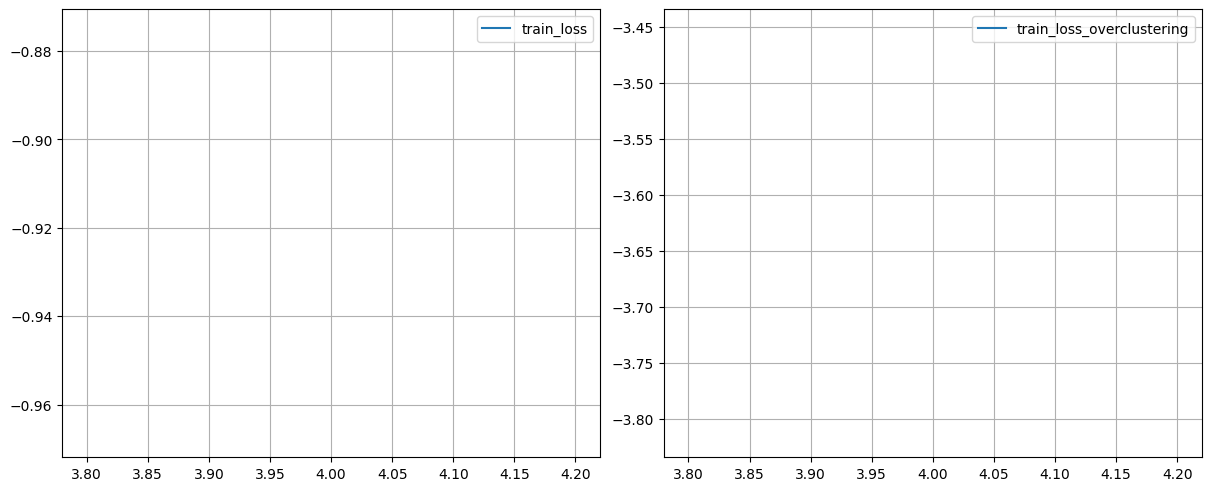

Epoch 6/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983]
[-3.6344864, -3.7921143]


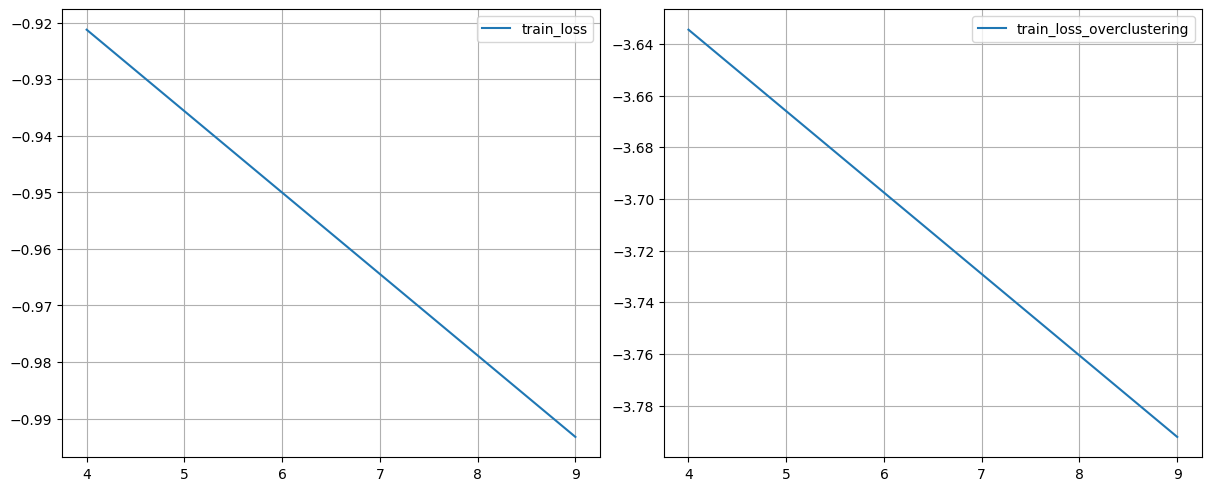

Epoch 11/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983, -2.2909918]
[-3.6344864, -3.7921143, -3.2650044]


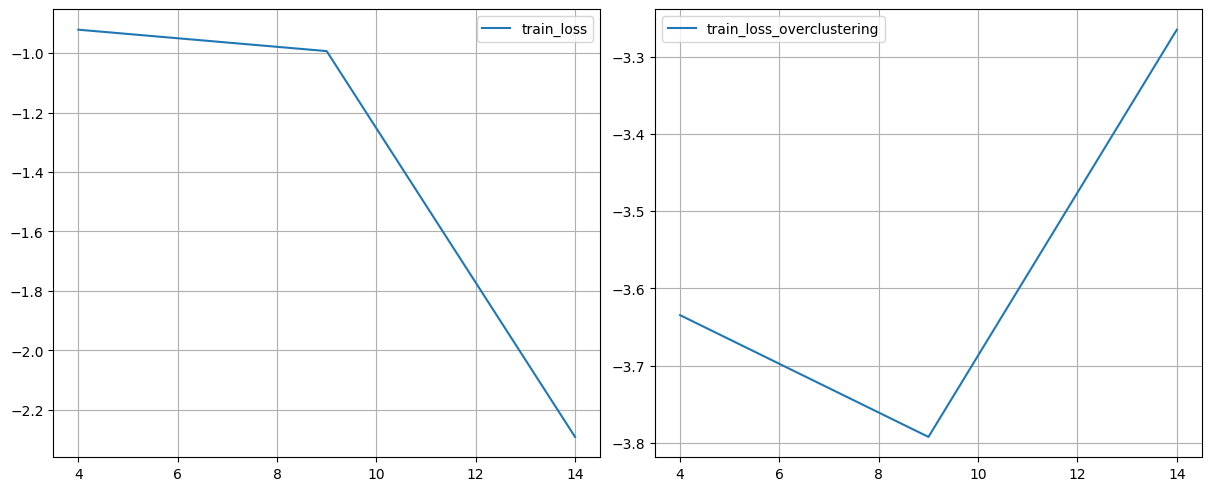

Epoch 16/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 17/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 18/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 19/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 20/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983, -2.2909918, -2.2455857]
[-3.6344864, -3.7921143, -3.2650044, -3.2008274]


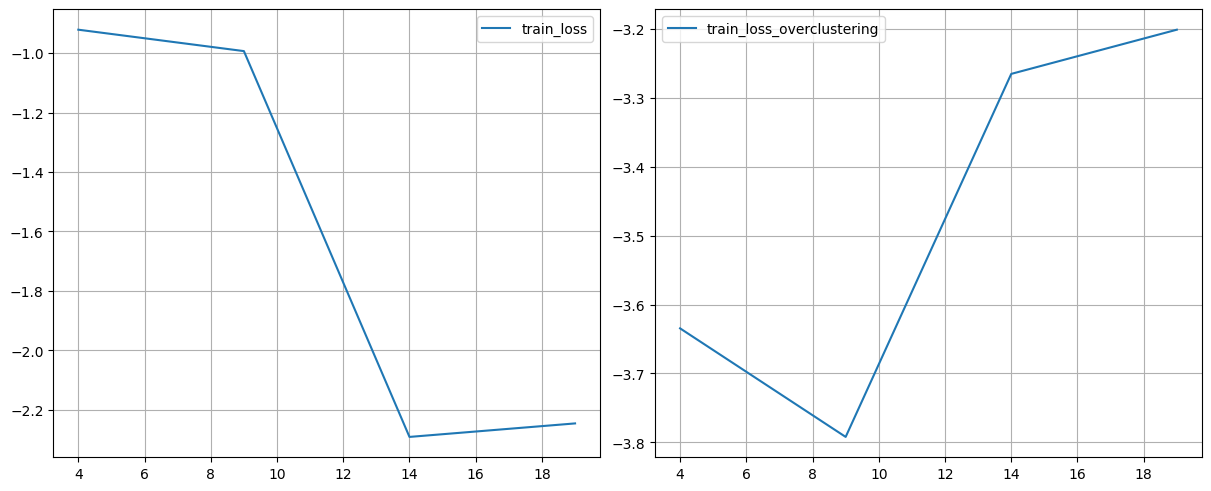

Epoch 21/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 22/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 23/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 24/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 25/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983, -2.2909918, -2.2455857, -2.2133472]
[-3.6344864, -3.7921143, -3.2650044, -3.2008274, -3.787305]


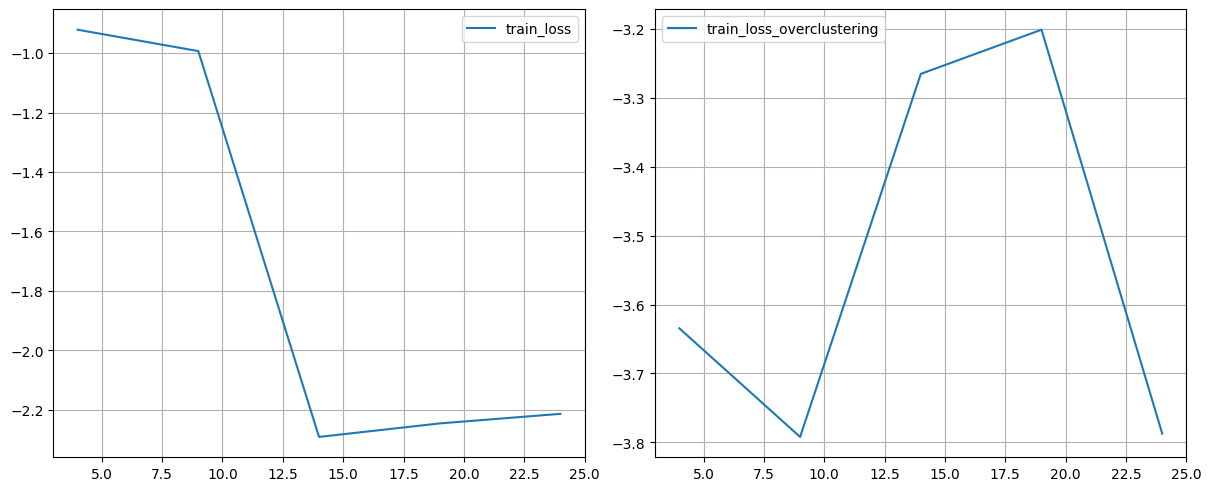

Epoch 26/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 27/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 28/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 29/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 30/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983, -2.2909918, -2.2455857, -2.2133472, -2.2219715]
[-3.6344864, -3.7921143, -3.2650044, -3.2008274, -3.787305, -3.825202]


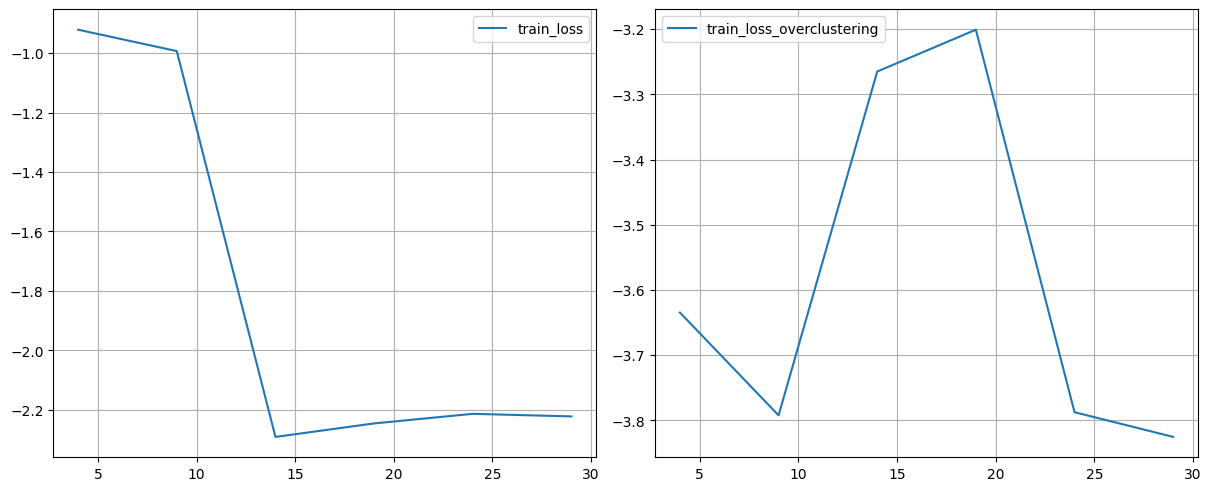

Epoch 31/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 32/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 33/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 34/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 35/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983, -2.2909918, -2.2455857, -2.2133472, -2.2219715, -2.2967308]
[-3.6344864, -3.7921143, -3.2650044, -3.2008274, -3.787305, -3.825202, -3.7212799]


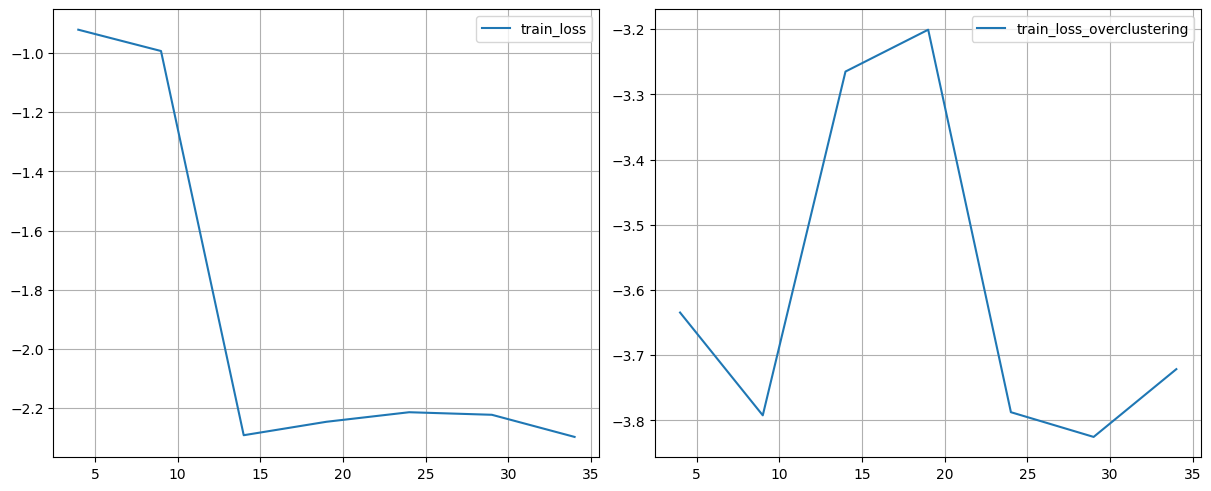

Epoch 36/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 37/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 38/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 39/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 40/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983, -2.2909918, -2.2455857, -2.2133472, -2.2219715, -2.2967308, -2.3143957]
[-3.6344864, -3.7921143, -3.2650044, -3.2008274, -3.787305, -3.825202, -3.7212799, -3.6957104]


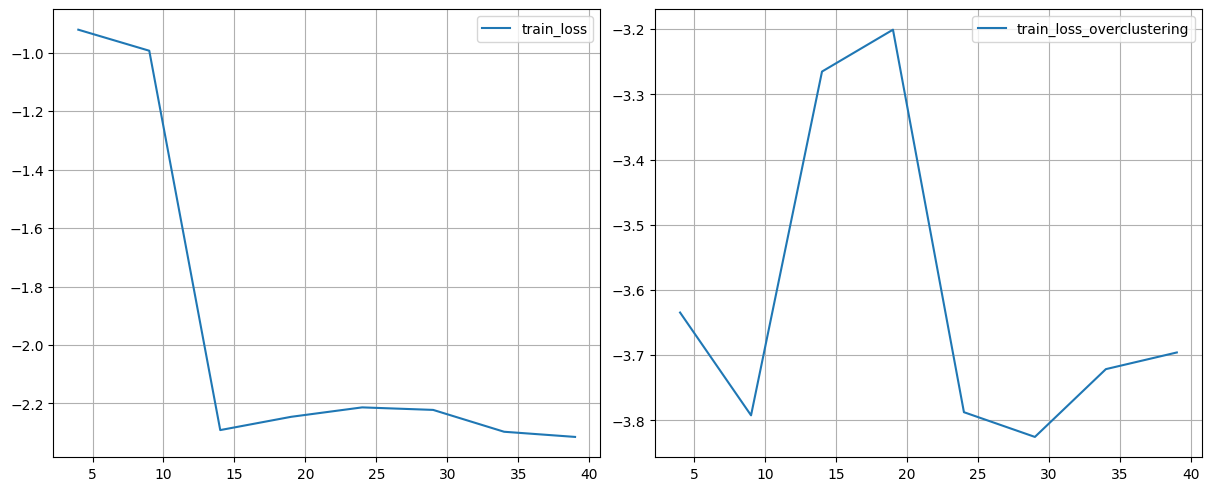

Epoch 41/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 42/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 43/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 44/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 45/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983, -2.2909918, -2.2455857, -2.2133472, -2.2219715, -2.2967308, -2.3143957, -2.282163]
[-3.6344864, -3.7921143, -3.2650044, -3.2008274, -3.787305, -3.825202, -3.7212799, -3.6957104, -3.9696484]


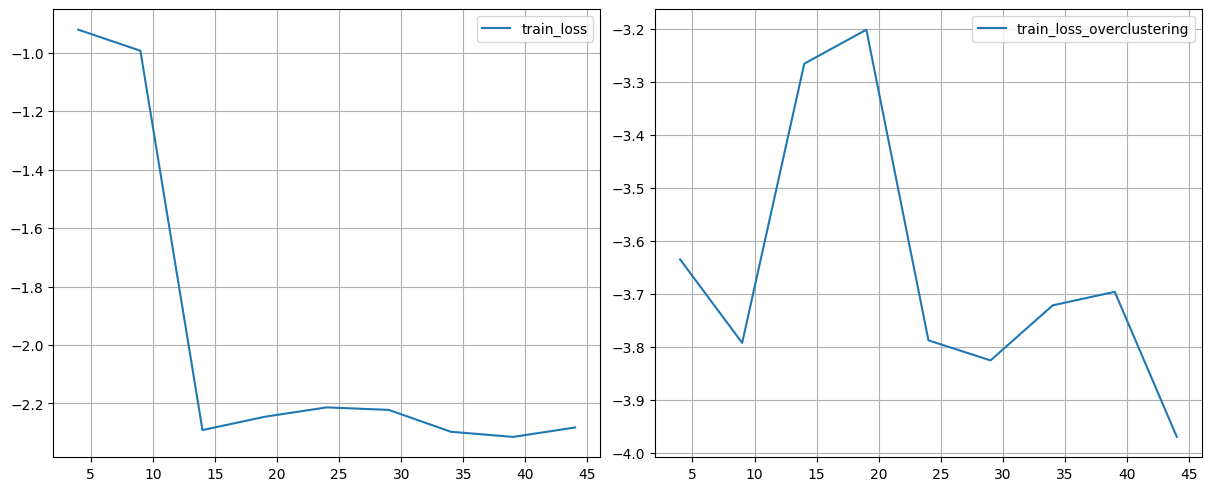

Epoch 46/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 47/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 48/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 49/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 50/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983, -2.2909918, -2.2455857, -2.2133472, -2.2219715, -2.2967308, -2.3143957, -2.282163, -2.325596]
[-3.6344864, -3.7921143, -3.2650044, -3.2008274, -3.787305, -3.825202, -3.7212799, -3.6957104, -3.9696484, -3.9691045]


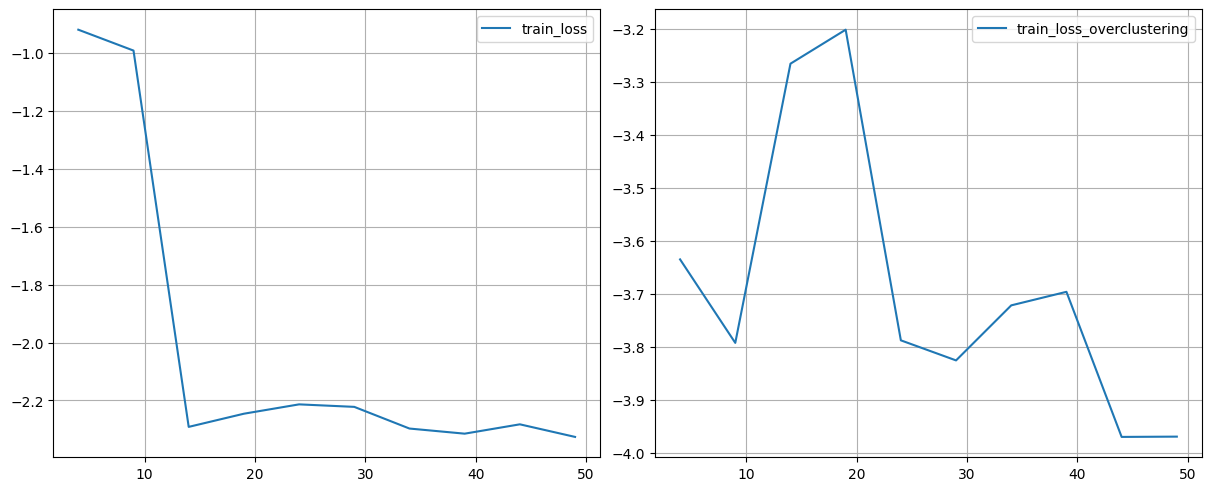

Epoch 51/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 52/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 53/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 54/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 55/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983, -2.2909918, -2.2455857, -2.2133472, -2.2219715, -2.2967308, -2.3143957, -2.282163, -2.325596, -2.3147278]
[-3.6344864, -3.7921143, -3.2650044, -3.2008274, -3.787305, -3.825202, -3.7212799, -3.6957104, -3.9696484, -3.9691045, -3.8135917]


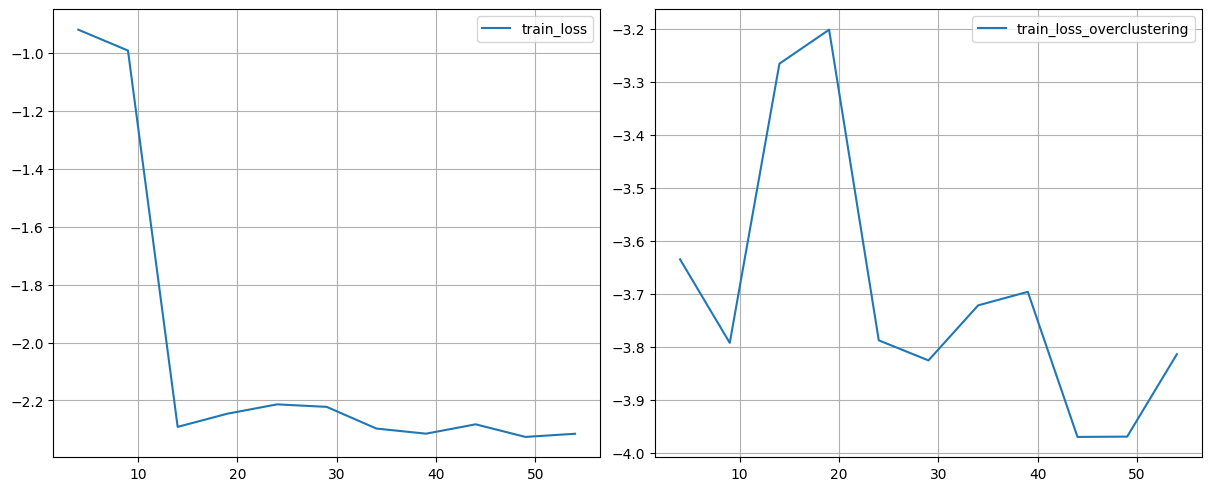

Epoch 56/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 57/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 58/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 59/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 60/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983, -2.2909918, -2.2455857, -2.2133472, -2.2219715, -2.2967308, -2.3143957, -2.282163, -2.325596, -2.3147278, -2.3458853]
[-3.6344864, -3.7921143, -3.2650044, -3.2008274, -3.787305, -3.825202, -3.7212799, -3.6957104, -3.9696484, -3.9691045, -3.8135917, -3.8605006]


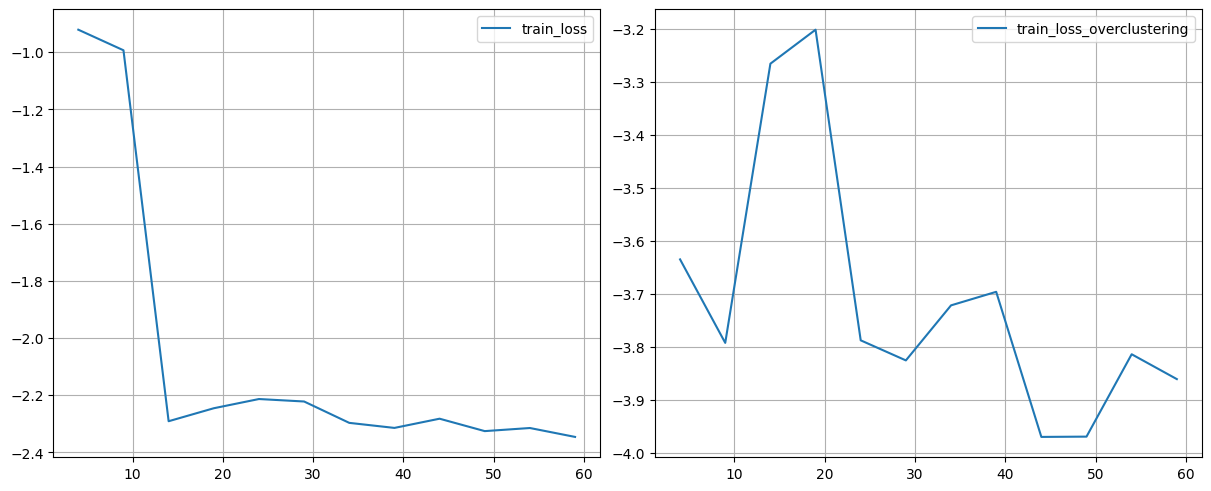

Epoch 61/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 62/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 63/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 64/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 65/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983, -2.2909918, -2.2455857, -2.2133472, -2.2219715, -2.2967308, -2.3143957, -2.282163, -2.325596, -2.3147278, -2.3458853, -2.4133315]
[-3.6344864, -3.7921143, -3.2650044, -3.2008274, -3.787305, -3.825202, -3.7212799, -3.6957104, -3.9696484, -3.9691045, -3.8135917, -3.8605006, -4.006327]


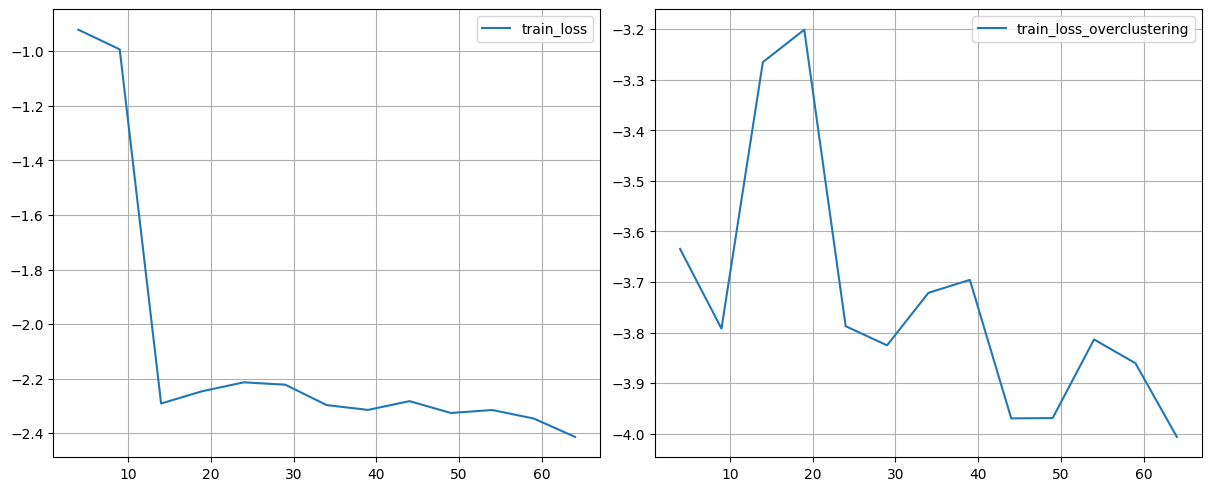

Epoch 66/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 67/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 68/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 69/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 70/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983, -2.2909918, -2.2455857, -2.2133472, -2.2219715, -2.2967308, -2.3143957, -2.282163, -2.325596, -2.3147278, -2.3458853, -2.4133315, -2.383778]
[-3.6344864, -3.7921143, -3.2650044, -3.2008274, -3.787305, -3.825202, -3.7212799, -3.6957104, -3.9696484, -3.9691045, -3.8135917, -3.8605006, -4.006327, -4.048436]


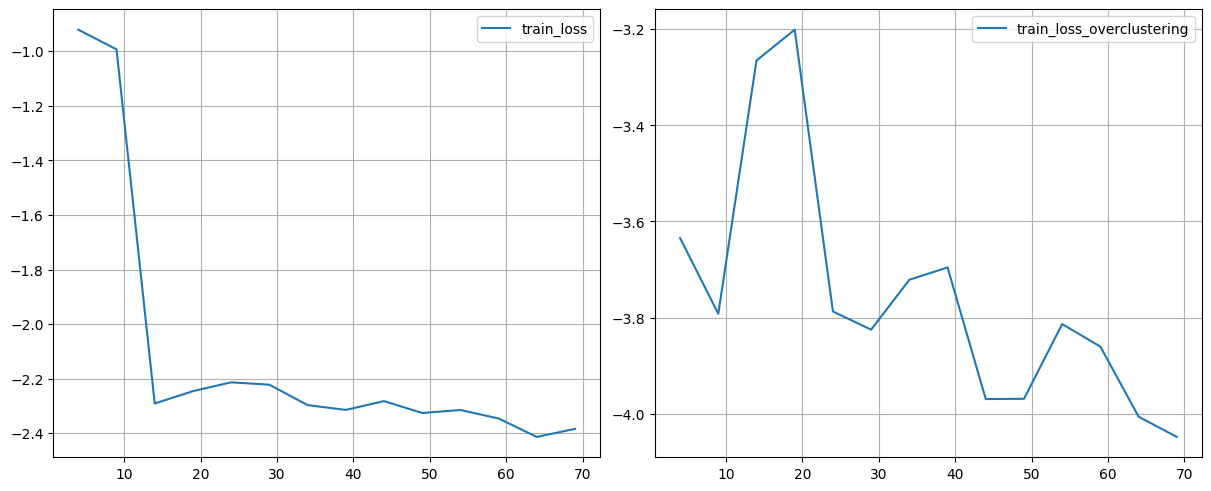

Epoch 71/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 72/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 73/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 74/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 75/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983, -2.2909918, -2.2455857, -2.2133472, -2.2219715, -2.2967308, -2.3143957, -2.282163, -2.325596, -2.3147278, -2.3458853, -2.4133315, -2.383778, -2.360408]
[-3.6344864, -3.7921143, -3.2650044, -3.2008274, -3.787305, -3.825202, -3.7212799, -3.6957104, -3.9696484, -3.9691045, -3.8135917, -3.8605006, -4.006327, -4.048436, -3.8708909]


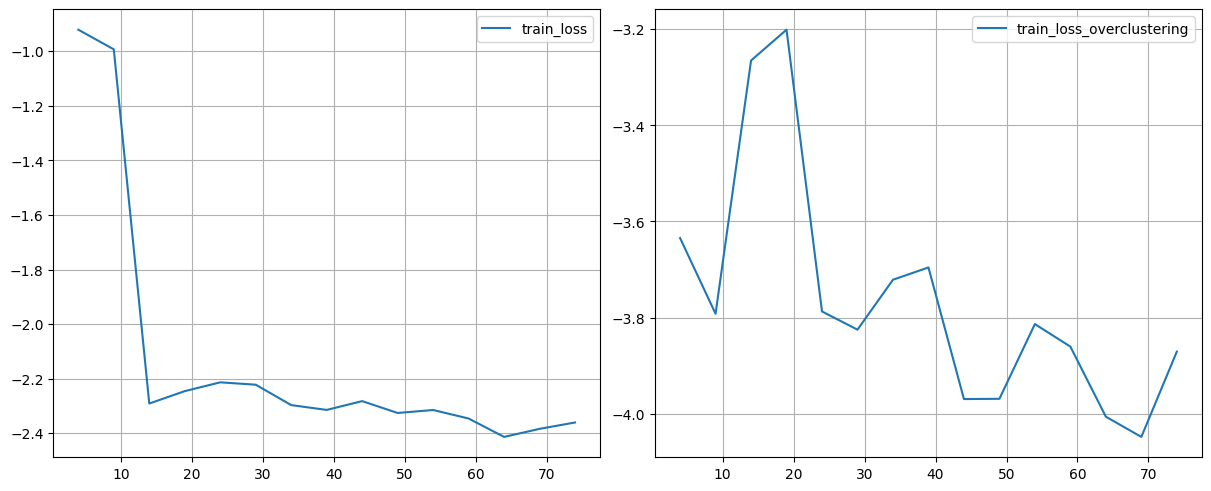

Epoch 76/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 77/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 78/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 79/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 80/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983, -2.2909918, -2.2455857, -2.2133472, -2.2219715, -2.2967308, -2.3143957, -2.282163, -2.325596, -2.3147278, -2.3458853, -2.4133315, -2.383778, -2.360408, -2.3929834]
[-3.6344864, -3.7921143, -3.2650044, -3.2008274, -3.787305, -3.825202, -3.7212799, -3.6957104, -3.9696484, -3.9691045, -3.8135917, -3.8605006, -4.006327, -4.048436, -3.8708909, -3.8727272]


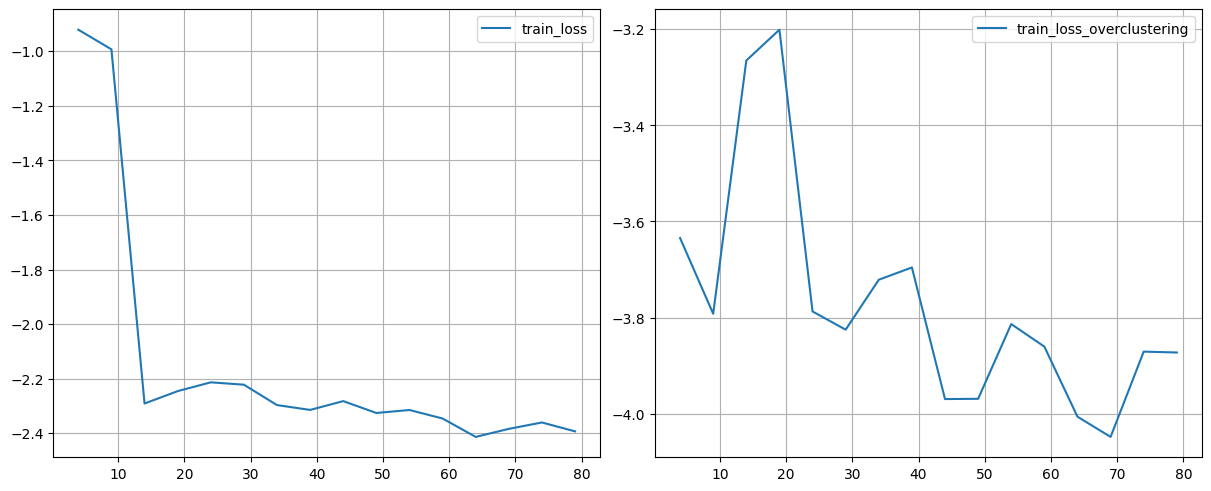

Epoch 81/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 82/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 83/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 84/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 85/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983, -2.2909918, -2.2455857, -2.2133472, -2.2219715, -2.2967308, -2.3143957, -2.282163, -2.325596, -2.3147278, -2.3458853, -2.4133315, -2.383778, -2.360408, -2.3929834, -2.3947752]
[-3.6344864, -3.7921143, -3.2650044, -3.2008274, -3.787305, -3.825202, -3.7212799, -3.6957104, -3.9696484, -3.9691045, -3.8135917, -3.8605006, -4.006327, -4.048436, -3.8708909, -3.8727272, -4.0423408]


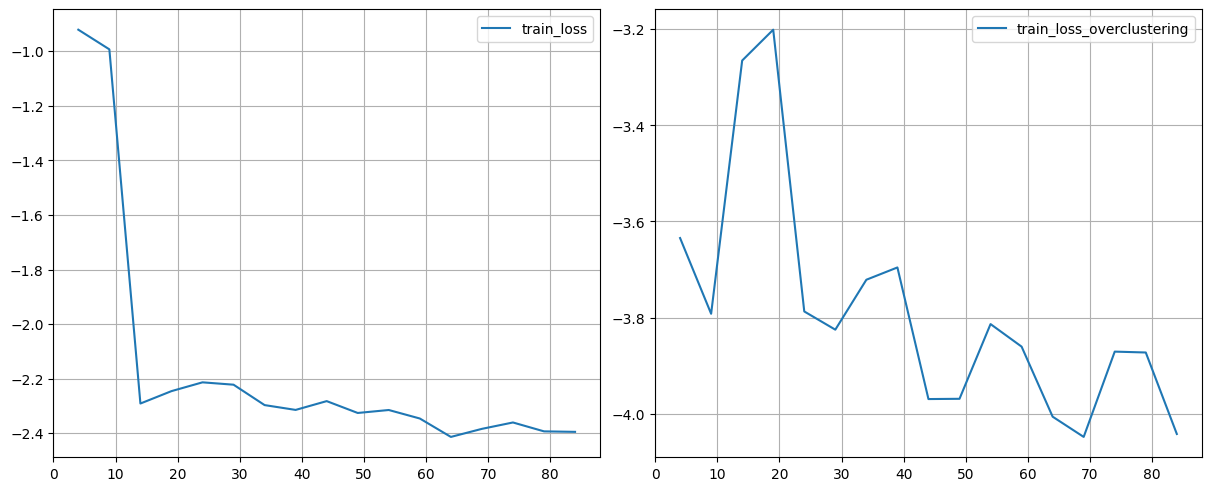

Epoch 86/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 87/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 88/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 89/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 90/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983, -2.2909918, -2.2455857, -2.2133472, -2.2219715, -2.2967308, -2.3143957, -2.282163, -2.325596, -2.3147278, -2.3458853, -2.4133315, -2.383778, -2.360408, -2.3929834, -2.3947752, -2.375284]
[-3.6344864, -3.7921143, -3.2650044, -3.2008274, -3.787305, -3.825202, -3.7212799, -3.6957104, -3.9696484, -3.9691045, -3.8135917, -3.8605006, -4.006327, -4.048436, -3.8708909, -3.8727272, -4.0423408, -4.0122805]


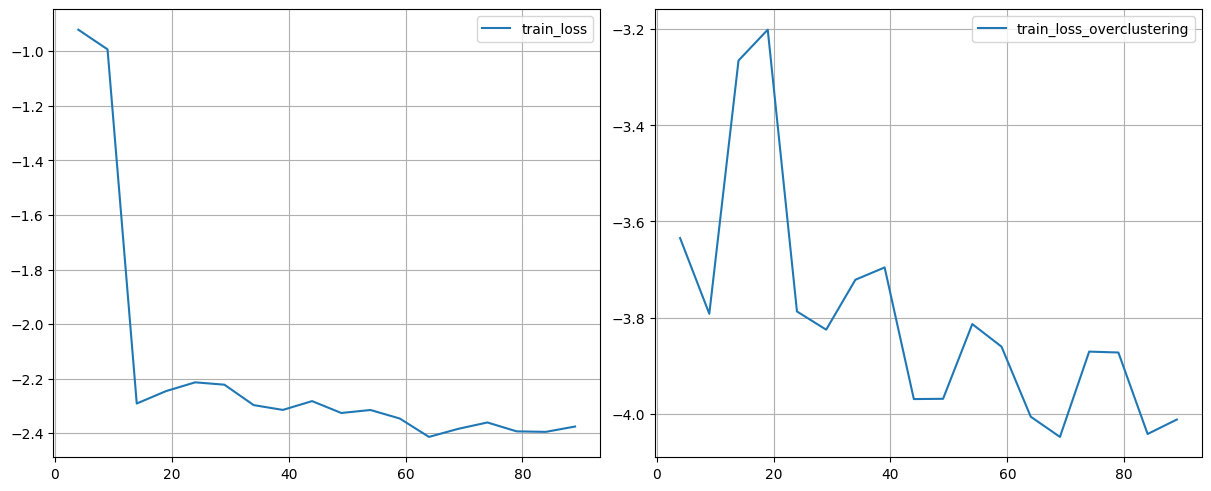

Epoch 91/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 92/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 93/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 94/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 95/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983, -2.2909918, -2.2455857, -2.2133472, -2.2219715, -2.2967308, -2.3143957, -2.282163, -2.325596, -2.3147278, -2.3458853, -2.4133315, -2.383778, -2.360408, -2.3929834, -2.3947752, -2.375284, -2.417454]
[-3.6344864, -3.7921143, -3.2650044, -3.2008274, -3.787305, -3.825202, -3.7212799, -3.6957104, -3.9696484, -3.9691045, -3.8135917, -3.8605006, -4.006327, -4.048436, -3.8708909, -3.8727272, -4.0423408, -4.0122805, -3.9876842]


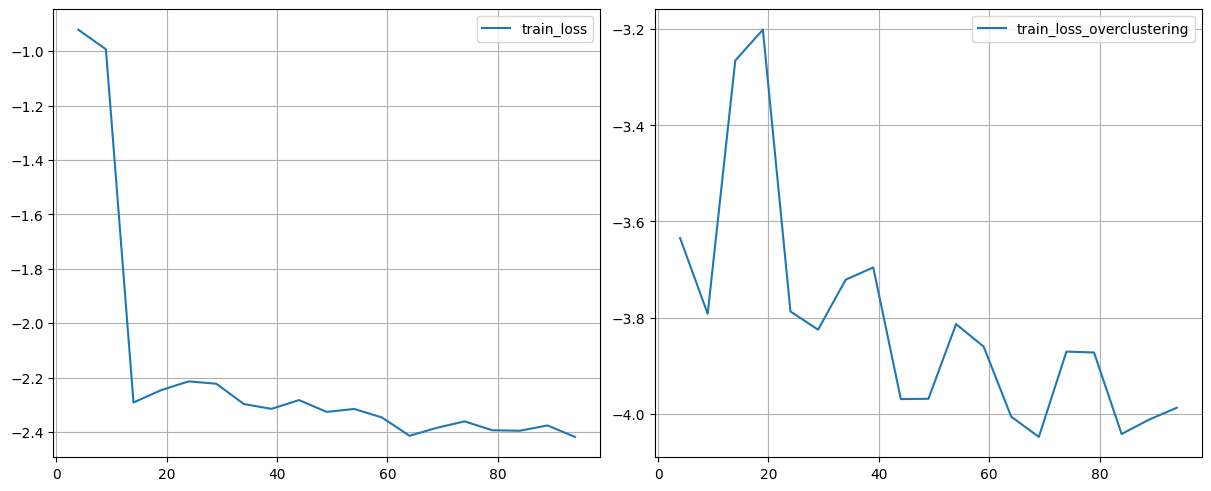

Epoch 96/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 97/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 98/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 99/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 100/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9212387, -0.99324983, -2.2909918, -2.2455857, -2.2133472, -2.2219715, -2.2967308, -2.3143957, -2.282163, -2.325596, -2.3147278, -2.3458853, -2.4133315, -2.383778, -2.360408, -2.3929834, -2.3947752, -2.375284, -2.417454, -2.4386666]
[-3.6344864, -3.7921143, -3.2650044, -3.2008274, -3.787305, -3.825202, -3.7212799, -3.6957104, -3.9696484, -3.9691045, -3.8135917, -3.8605006, -4.006327, -4.048436, -3.8708909, -3.8727272, -4.0423408, -4.0122805, -3.9876842, -3.893095]


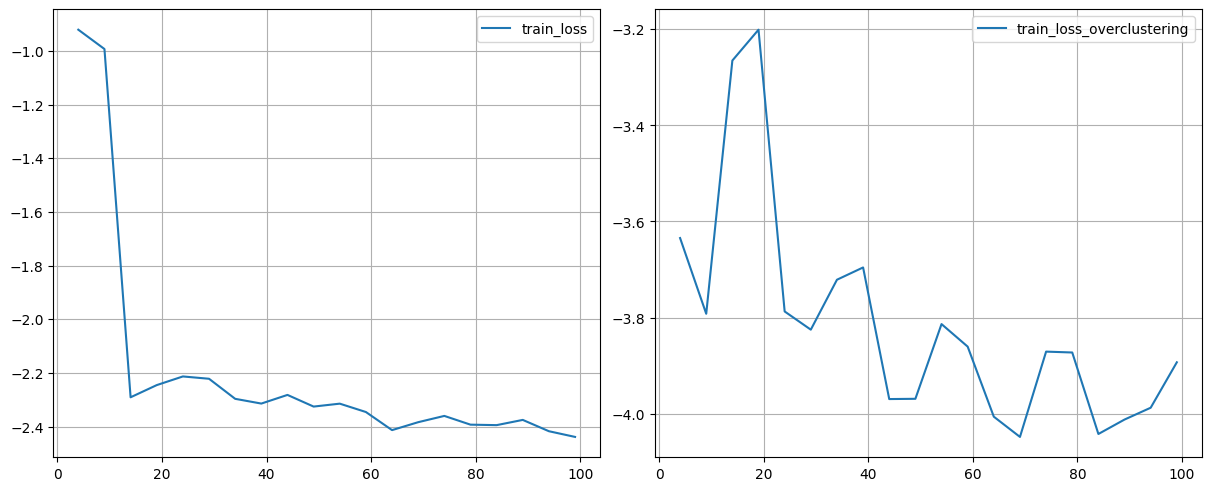

Best Clustering Loss Value: -2.4386666


In [ ]:
# training
optimizer = torch.optim.Adam(
    model.parameters(), lr=4e-4, betas=(0.9, 0.999), eps=1e-08,
    weight_decay=0, amsgrad=False)

train( model, dataloader_train, dataloader_val,
    optimizer, device=device, epochs=100, lamb=1.2,
    overcluster_period=20, overcluster_ratio=0.5)

In [ ]:
test_model = ResNetClusterisator()
test_model.load_state_dict(torch.load("/content/best_loss_model_cifar10.pth"))
test_model.to(device)

ResNetClusterisator(
  (resnet): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer0): Sequential(
      (0): ResidualBlock(
        (conv1): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (conv2): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
      )
      (1): ResidualBlock(
        (conv1): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1)

In [ ]:
# data testing
original_labels, cluster_labels = model_test(
    test_model, dataloader_val, device=device
)

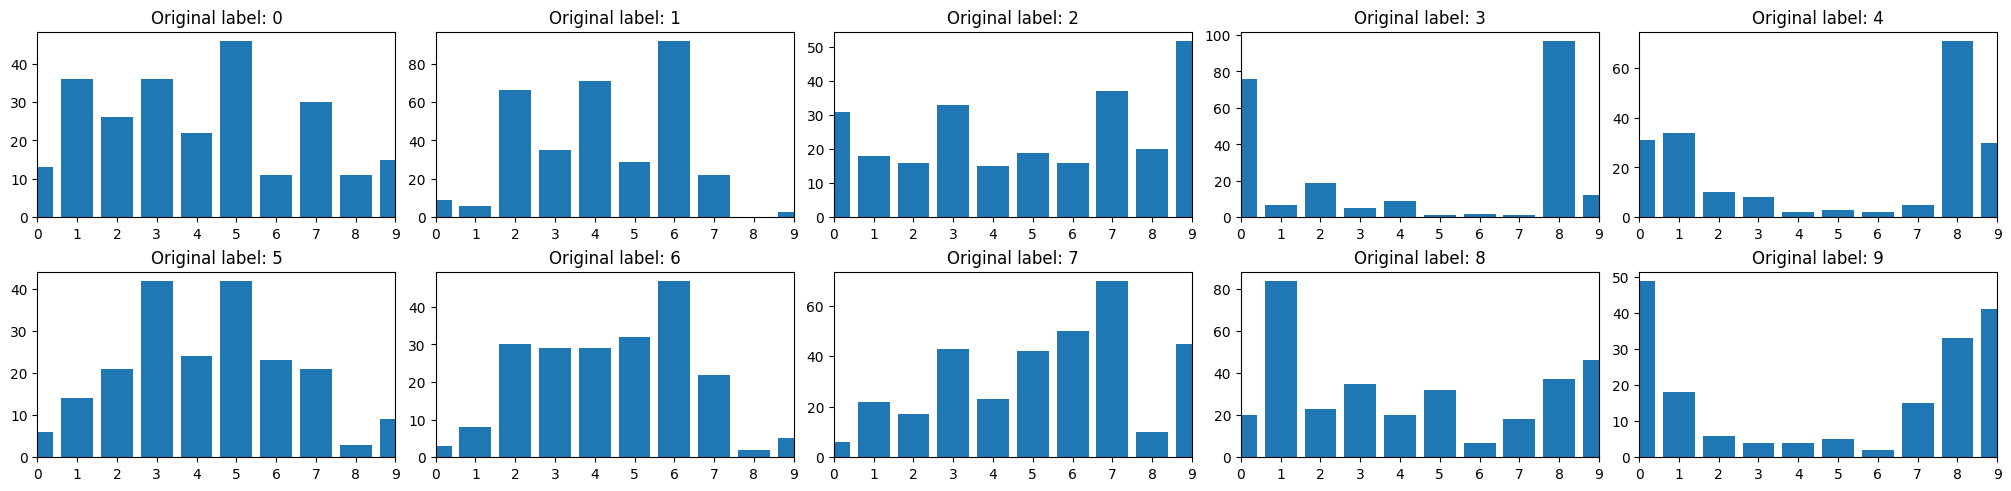

In [ ]:
# visualization
visualise_clusetering_results(original_labels, cluster_labels)

In [ ]:
adj_score = adjusted_rand_score(cluster_labels, original_labels)
hom_score = homogeneity_score(cluster_labels, original_labels)
compl_score = completeness_score(cluster_labels, original_labels)
print("Adjusted rand score: %.3f " % adj_score)
print("Homogeneity score: %.3f " % adj_score)
print("Completeness score: %.3f" % compl_score)

Adjusted rand score: 0.068 
Homogeneity score: 0.068 
Completeness score: 0.135


### **VGG**

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        return out

In [ ]:
model = VGG()
output = model(inputs)
output.shape

torch.Size([1, 256, 4, 4])

In [ ]:
class VGGClusterisator(nn.Module):
    def __init__(self):
        super(VGGClusterisator, self).__init__()
        final_features = 4096
        self.resnet = VGG()
        self.flatten = nn.Flatten()
        self.cluster_head = nn.Linear(final_features, 10)
        self.overcluster_head = nn.Linear(final_features, 50)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x, overclustering=False):
        x = self.resnet(x)
        x = self.flatten(x)
        if overclustering:
            x = self.overcluster_head(x)
        else:
            x = self.cluster_head(x)
        return self.softmax(x)

In [ ]:
# weight initializer
def weight_init(model):
    if isinstance(model, nn.Conv2d):
        nn.init.xavier_normal_(model.weight, gain=nn.init.calculate_gain("relu"))
        if model.bias is not None:
            nn.init.zeros_(model.bias)

    elif isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight)
        if model.bias is not None:
            nn.init.zeros_(model.bias)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)
model = VGGClusterisator()
model.to(device)
print("The model is transfered to", device)
model.apply(weight_init)
print("The weights are Initialised.")

Using cuda
The model is transfered to cuda
The weights are Initialised.


Epoch 1/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701]
[-3.6516407]


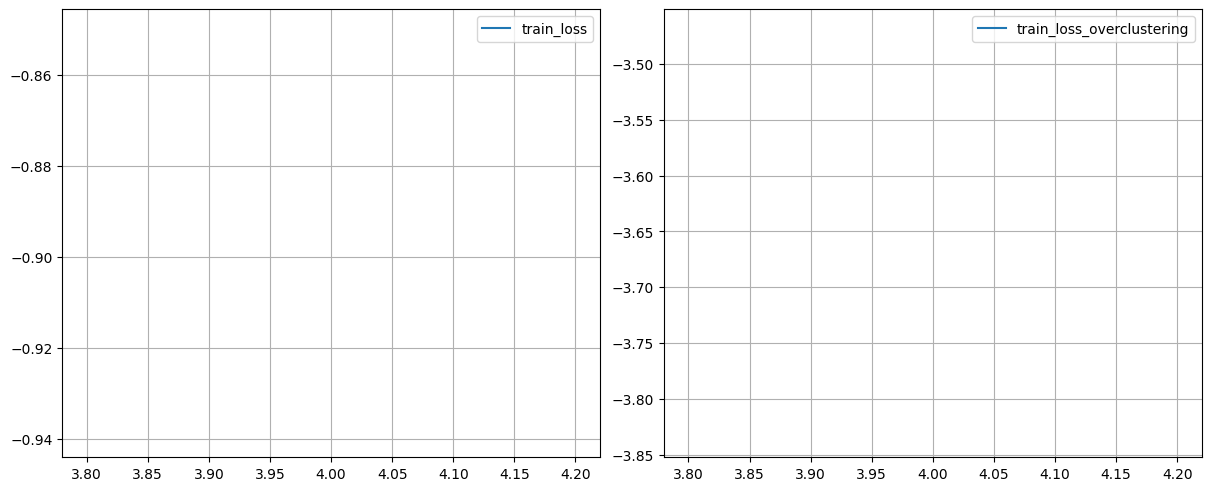

Epoch 6/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988]
[-3.6516407, -3.7362983]


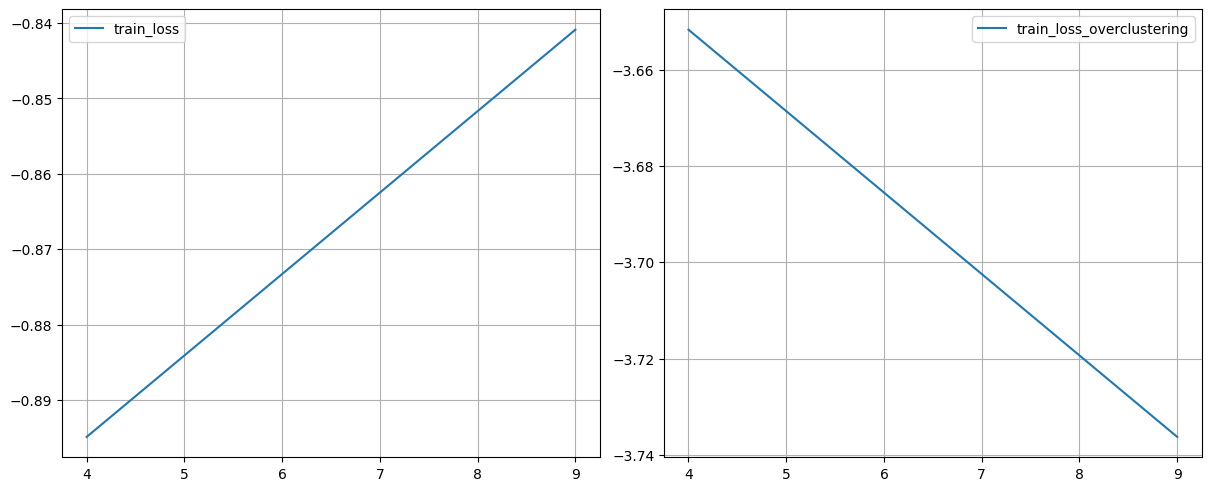

Epoch 11/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988, -2.311004]
[-3.6516407, -3.7362983, -3.4219265]


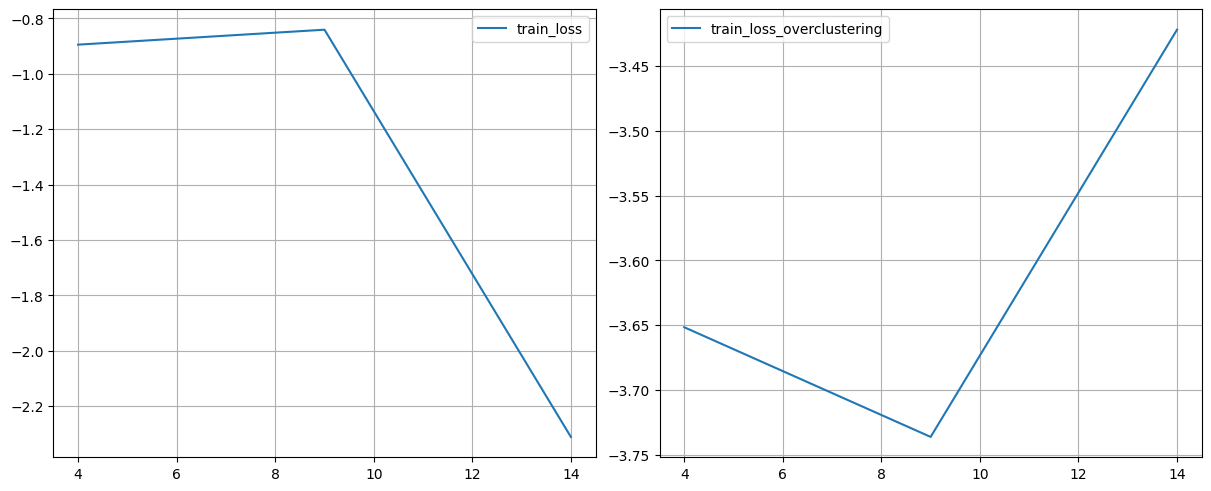

Epoch 16/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 17/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 18/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 19/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 20/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988, -2.311004, -2.3841197]
[-3.6516407, -3.7362983, -3.4219265, -3.48536]


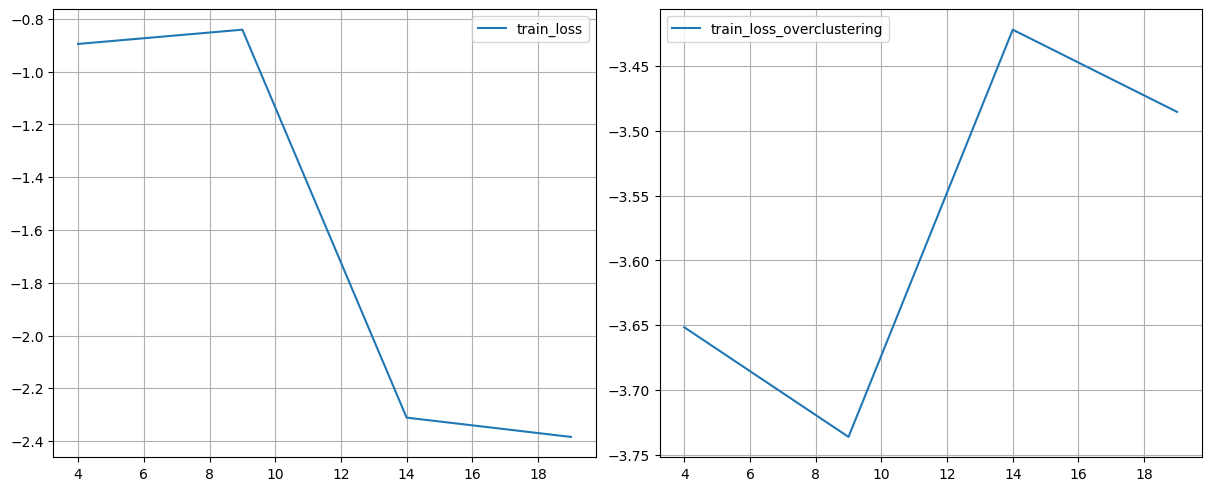

Epoch 21/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 22/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 23/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 24/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 25/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988, -2.311004, -2.3841197, -2.3697033]
[-3.6516407, -3.7362983, -3.4219265, -3.48536, -3.828554]


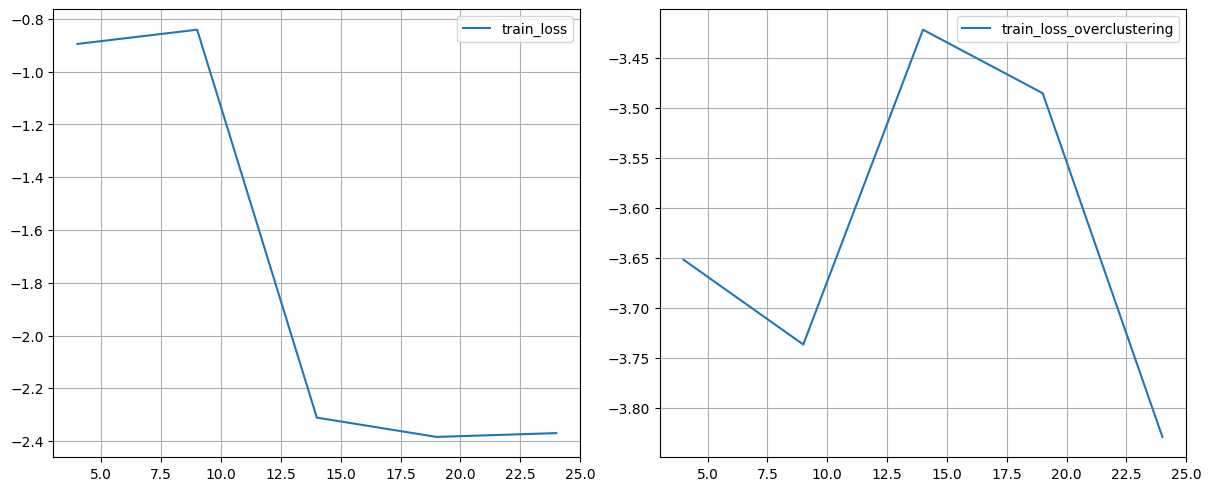

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 26/100:
Epoch 27/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 28/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 29/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 30/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988, -2.311004, -2.3841197, -2.3697033, -2.319981]
[-3.6516407, -3.7362983, -3.4219265, -3.48536, -3.828554, -3.863921]


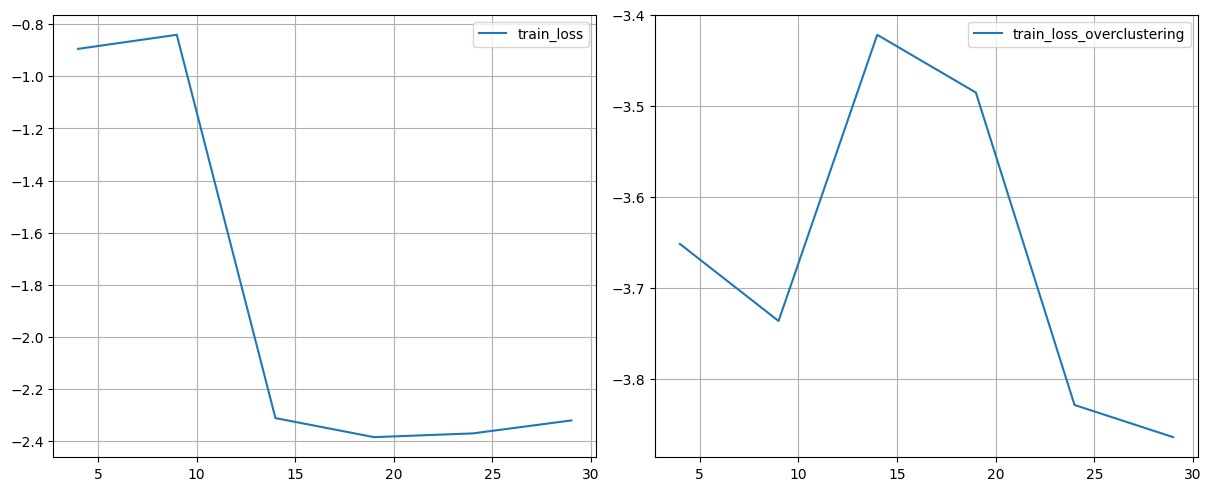

Epoch 31/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 32/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 33/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 34/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 35/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988, -2.311004, -2.3841197, -2.3697033, -2.319981, -2.4313066]
[-3.6516407, -3.7362983, -3.4219265, -3.48536, -3.828554, -3.863921, -3.8642704]


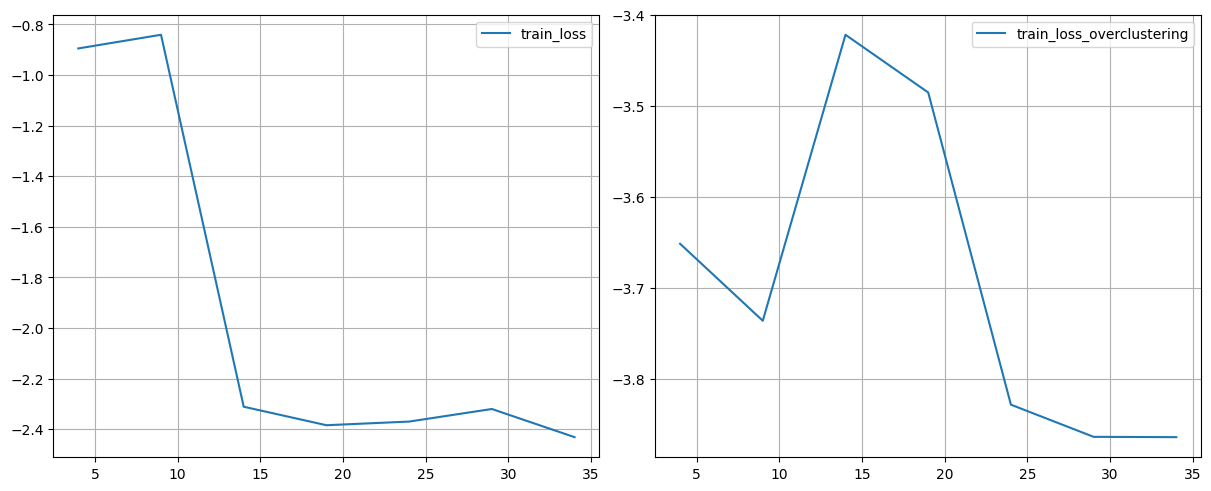

Epoch 36/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 37/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 38/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 39/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 40/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988, -2.311004, -2.3841197, -2.3697033, -2.319981, -2.4313066, -2.3571985]
[-3.6516407, -3.7362983, -3.4219265, -3.48536, -3.828554, -3.863921, -3.8642704, -3.7476673]


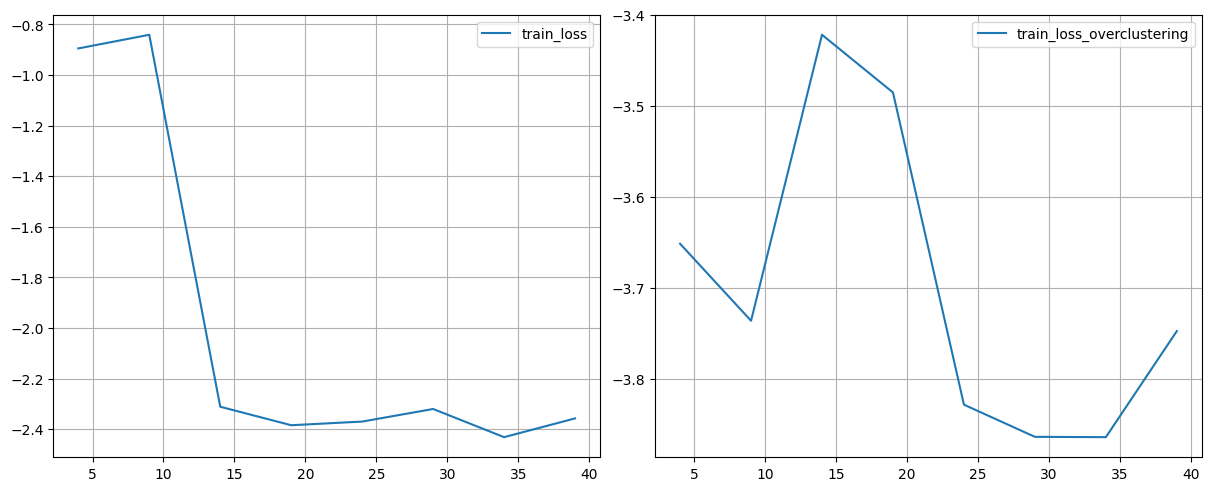

Epoch 41/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 42/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 43/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 44/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 45/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988, -2.311004, -2.3841197, -2.3697033, -2.319981, -2.4313066, -2.3571985, -2.3902726]
[-3.6516407, -3.7362983, -3.4219265, -3.48536, -3.828554, -3.863921, -3.8642704, -3.7476673, -3.954572]


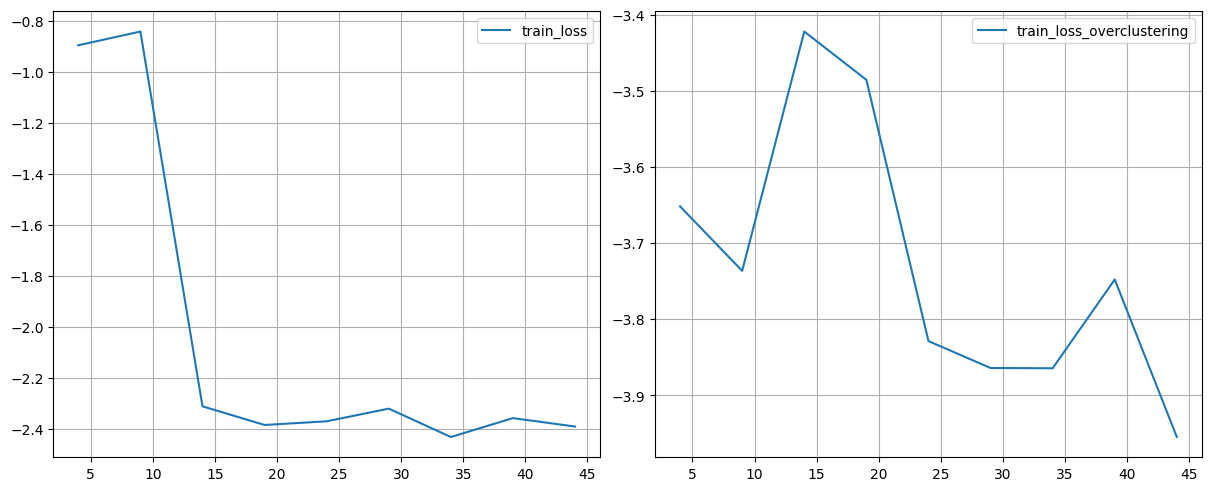

Epoch 46/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 47/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 48/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 49/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 50/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988, -2.311004, -2.3841197, -2.3697033, -2.319981, -2.4313066, -2.3571985, -2.3902726, -2.4568758]
[-3.6516407, -3.7362983, -3.4219265, -3.48536, -3.828554, -3.863921, -3.8642704, -3.7476673, -3.954572, -3.9957085]


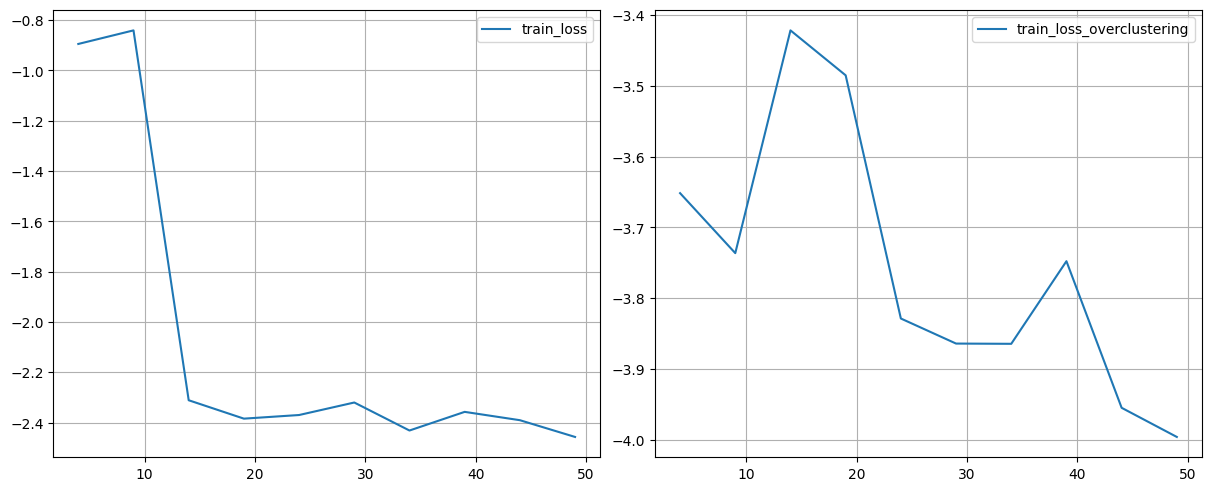

Epoch 51/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 52/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 53/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 54/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 55/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988, -2.311004, -2.3841197, -2.3697033, -2.319981, -2.4313066, -2.3571985, -2.3902726, -2.4568758, -2.4683752]
[-3.6516407, -3.7362983, -3.4219265, -3.48536, -3.828554, -3.863921, -3.8642704, -3.7476673, -3.954572, -3.9957085, -3.9431248]


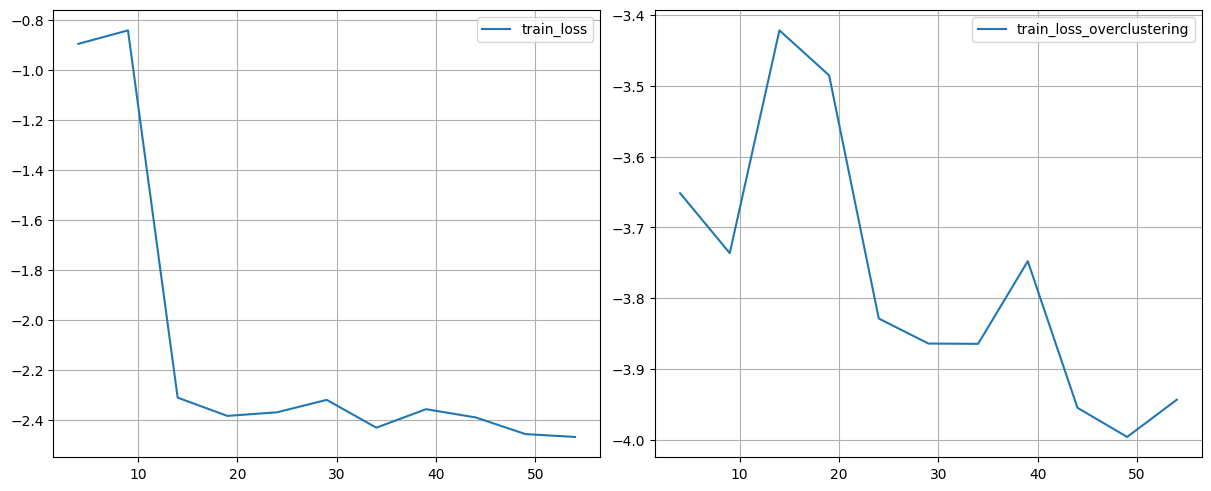

Epoch 56/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 57/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 58/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 59/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 60/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988, -2.311004, -2.3841197, -2.3697033, -2.319981, -2.4313066, -2.3571985, -2.3902726, -2.4568758, -2.4683752, -2.4005516]
[-3.6516407, -3.7362983, -3.4219265, -3.48536, -3.828554, -3.863921, -3.8642704, -3.7476673, -3.954572, -3.9957085, -3.9431248, -3.9133618]


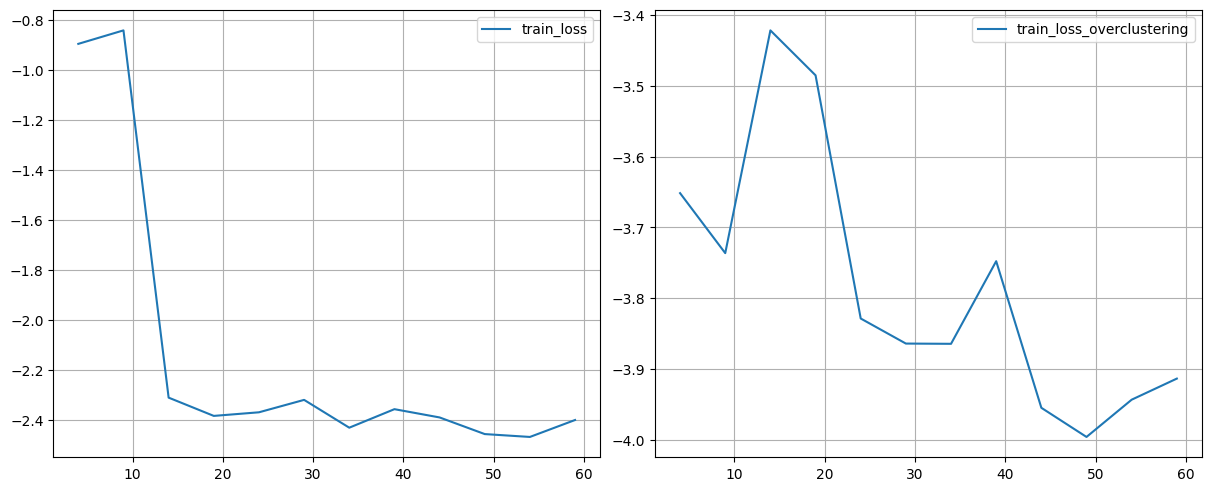

Epoch 61/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 62/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 63/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 64/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 65/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988, -2.311004, -2.3841197, -2.3697033, -2.319981, -2.4313066, -2.3571985, -2.3902726, -2.4568758, -2.4683752, -2.4005516, -2.404702]
[-3.6516407, -3.7362983, -3.4219265, -3.48536, -3.828554, -3.863921, -3.8642704, -3.7476673, -3.954572, -3.9957085, -3.9431248, -3.9133618, -3.941459]


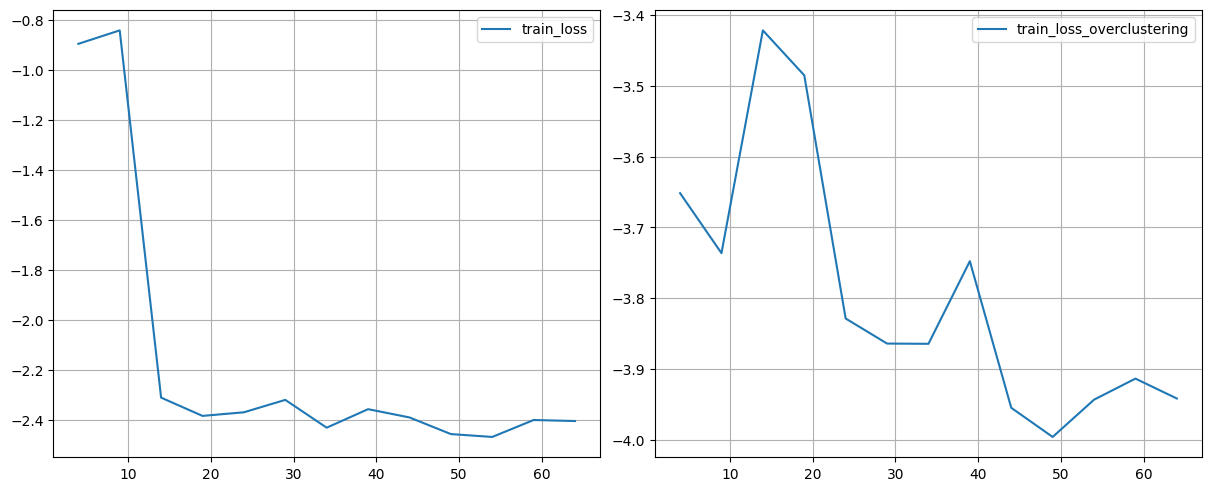

Epoch 66/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 67/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 68/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 69/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 70/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988, -2.311004, -2.3841197, -2.3697033, -2.319981, -2.4313066, -2.3571985, -2.3902726, -2.4568758, -2.4683752, -2.4005516, -2.404702, -2.400297]
[-3.6516407, -3.7362983, -3.4219265, -3.48536, -3.828554, -3.863921, -3.8642704, -3.7476673, -3.954572, -3.9957085, -3.9431248, -3.9133618, -3.941459, -3.9751263]


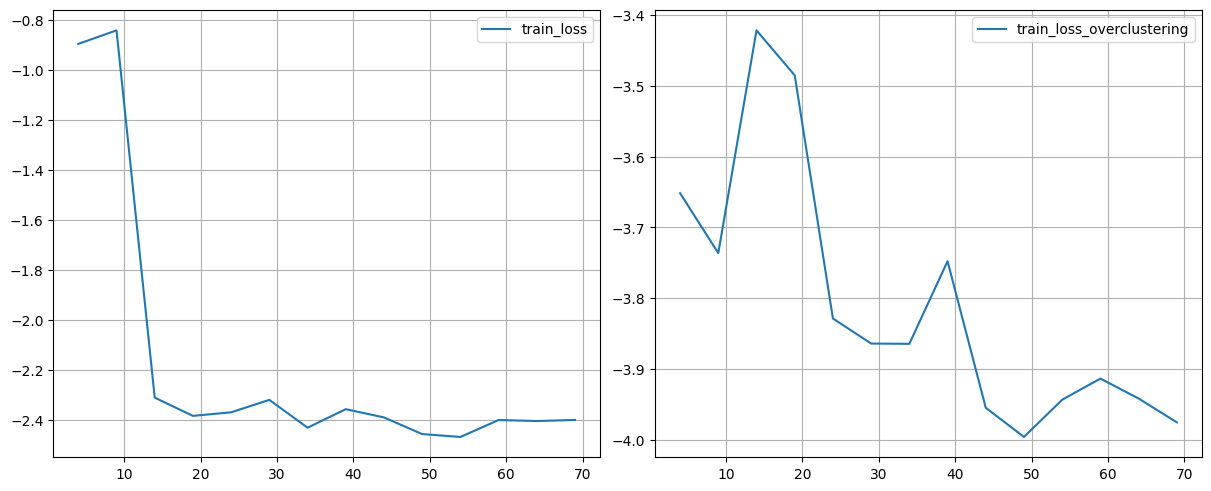

Epoch 71/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 72/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 73/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 74/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 75/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988, -2.311004, -2.3841197, -2.3697033, -2.319981, -2.4313066, -2.3571985, -2.3902726, -2.4568758, -2.4683752, -2.4005516, -2.404702, -2.400297, -2.4887552]
[-3.6516407, -3.7362983, -3.4219265, -3.48536, -3.828554, -3.863921, -3.8642704, -3.7476673, -3.954572, -3.9957085, -3.9431248, -3.9133618, -3.941459, -3.9751263, -4.0170903]


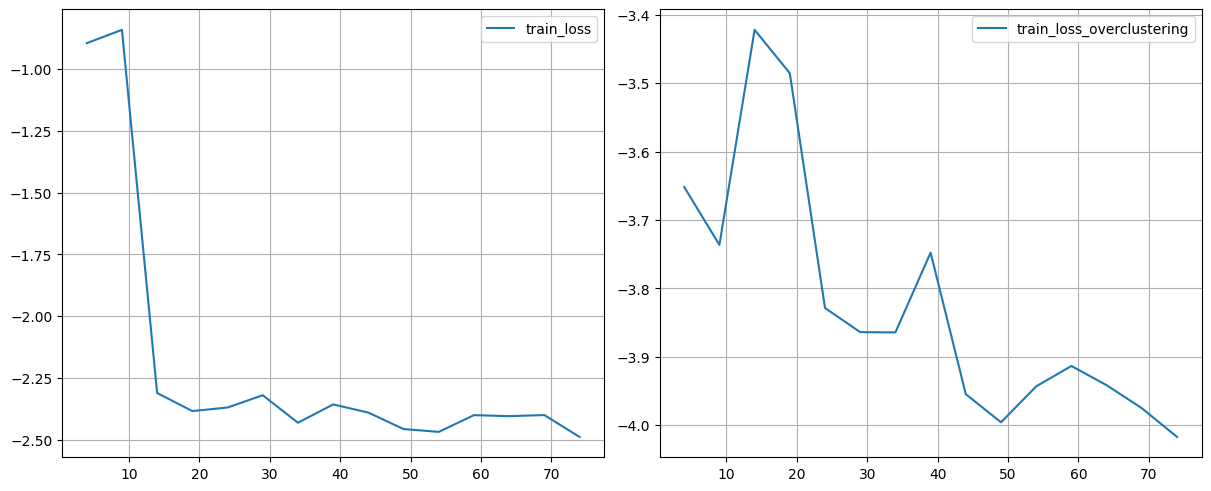

Epoch 76/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 77/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 78/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 79/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 80/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988, -2.311004, -2.3841197, -2.3697033, -2.319981, -2.4313066, -2.3571985, -2.3902726, -2.4568758, -2.4683752, -2.4005516, -2.404702, -2.400297, -2.4887552, -2.457415]
[-3.6516407, -3.7362983, -3.4219265, -3.48536, -3.828554, -3.863921, -3.8642704, -3.7476673, -3.954572, -3.9957085, -3.9431248, -3.9133618, -3.941459, -3.9751263, -4.0170903, -3.990866]


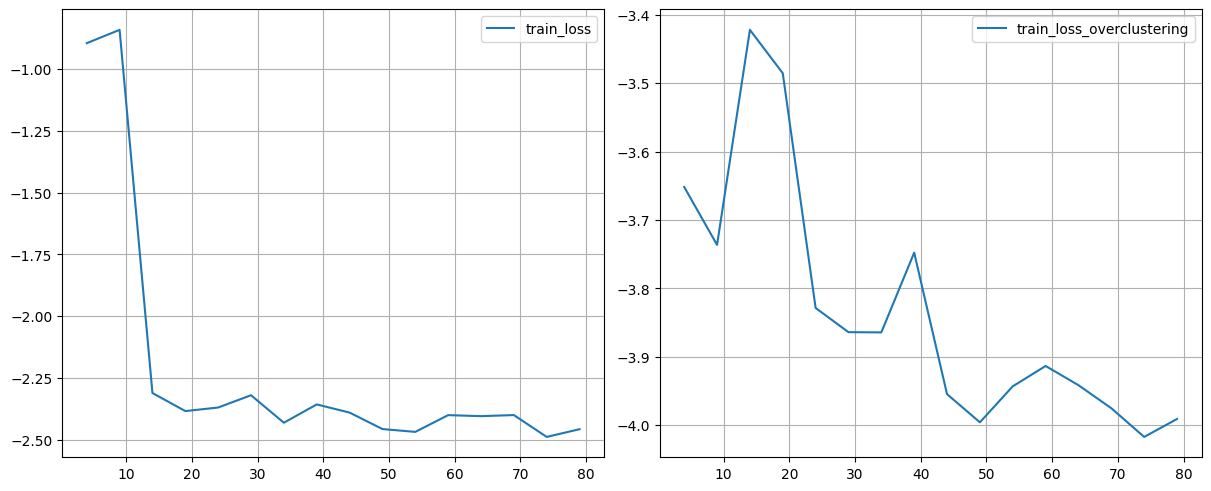

Epoch 81/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 82/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 83/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 84/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 85/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988, -2.311004, -2.3841197, -2.3697033, -2.319981, -2.4313066, -2.3571985, -2.3902726, -2.4568758, -2.4683752, -2.4005516, -2.404702, -2.400297, -2.4887552, -2.457415, -2.4058828]
[-3.6516407, -3.7362983, -3.4219265, -3.48536, -3.828554, -3.863921, -3.8642704, -3.7476673, -3.954572, -3.9957085, -3.9431248, -3.9133618, -3.941459, -3.9751263, -4.0170903, -3.990866, -4.045544]


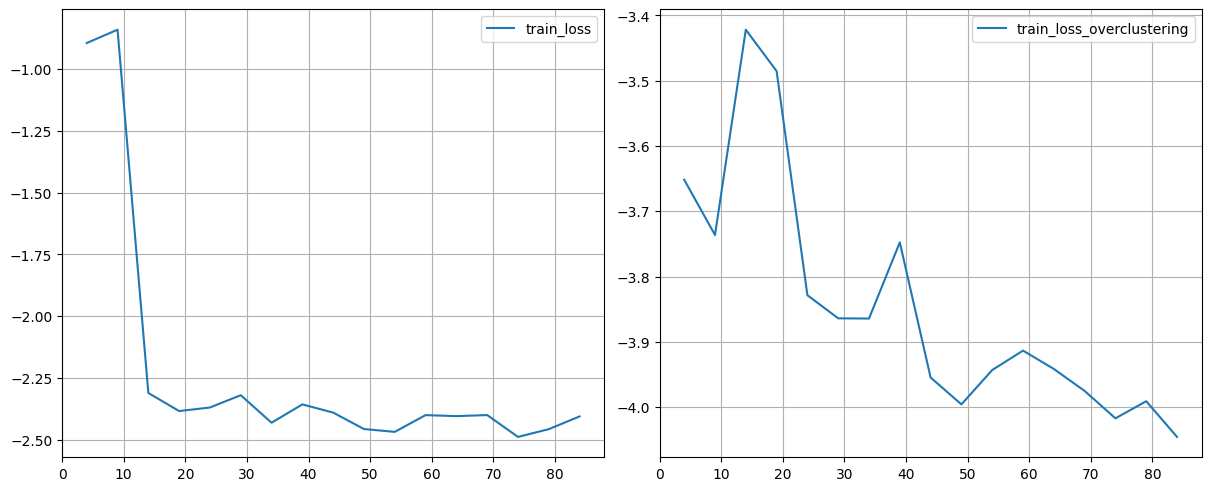

Epoch 86/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 87/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 88/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 89/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 90/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988, -2.311004, -2.3841197, -2.3697033, -2.319981, -2.4313066, -2.3571985, -2.3902726, -2.4568758, -2.4683752, -2.4005516, -2.404702, -2.400297, -2.4887552, -2.457415, -2.4058828, -2.3608027]
[-3.6516407, -3.7362983, -3.4219265, -3.48536, -3.828554, -3.863921, -3.8642704, -3.7476673, -3.954572, -3.9957085, -3.9431248, -3.9133618, -3.941459, -3.9751263, -4.0170903, -3.990866, -4.045544, -3.9678295]


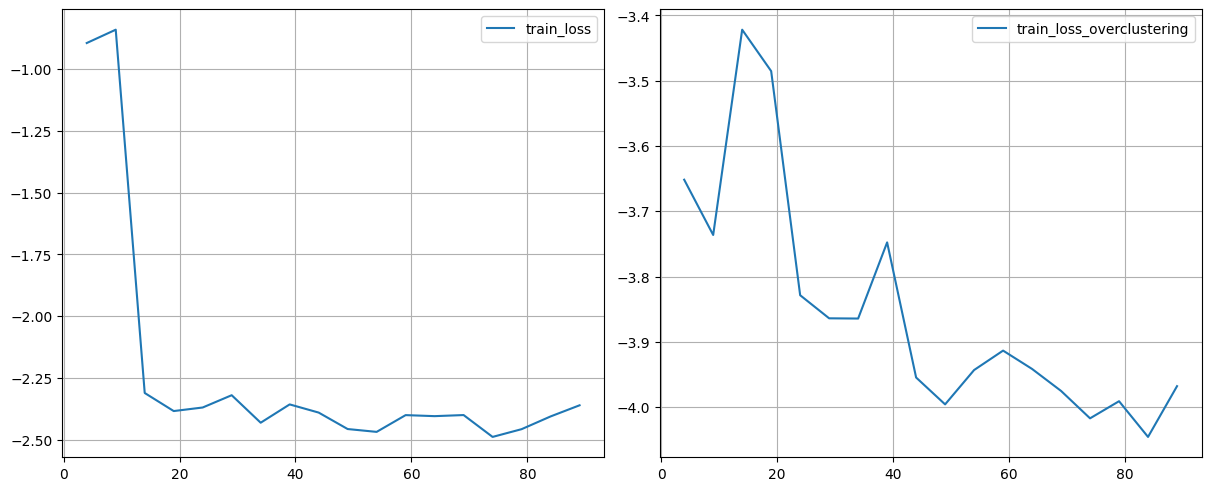

Epoch 91/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 92/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 93/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 94/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 95/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988, -2.311004, -2.3841197, -2.3697033, -2.319981, -2.4313066, -2.3571985, -2.3902726, -2.4568758, -2.4683752, -2.4005516, -2.404702, -2.400297, -2.4887552, -2.457415, -2.4058828, -2.3608027, -2.461361]
[-3.6516407, -3.7362983, -3.4219265, -3.48536, -3.828554, -3.863921, -3.8642704, -3.7476673, -3.954572, -3.9957085, -3.9431248, -3.9133618, -3.941459, -3.9751263, -4.0170903, -3.990866, -4.045544, -3.9678295, -4.0115676]


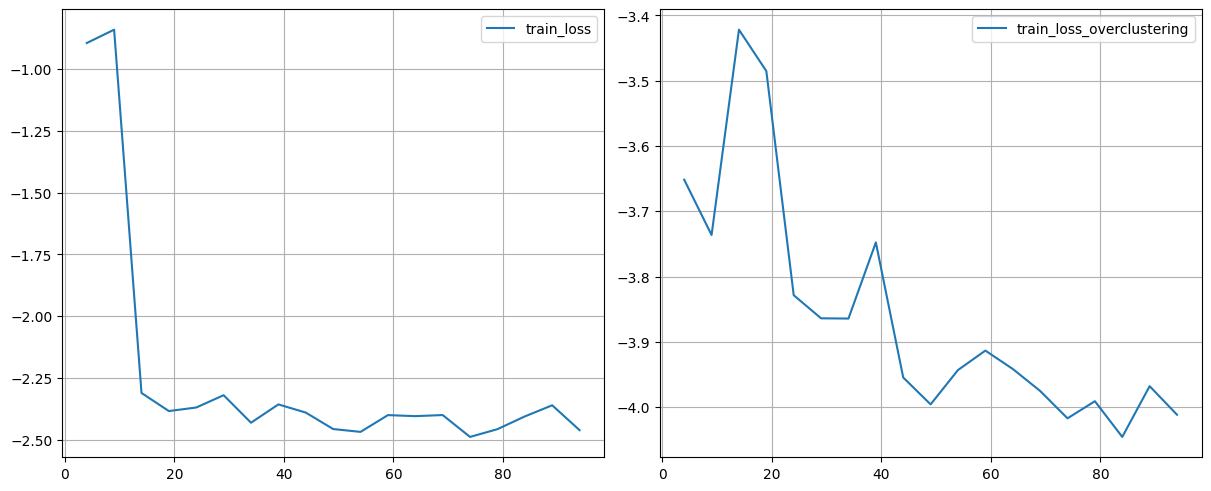

Epoch 96/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 97/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 98/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 99/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 100/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.8948701, -0.8408988, -2.311004, -2.3841197, -2.3697033, -2.319981, -2.4313066, -2.3571985, -2.3902726, -2.4568758, -2.4683752, -2.4005516, -2.404702, -2.400297, -2.4887552, -2.457415, -2.4058828, -2.3608027, -2.461361, -2.490321]
[-3.6516407, -3.7362983, -3.4219265, -3.48536, -3.828554, -3.863921, -3.8642704, -3.7476673, -3.954572, -3.9957085, -3.9431248, -3.9133618, -3.941459, -3.9751263, -4.0170903, -3.990866, -4.045544, -3.9678295, -4.0115676, -4.067266]


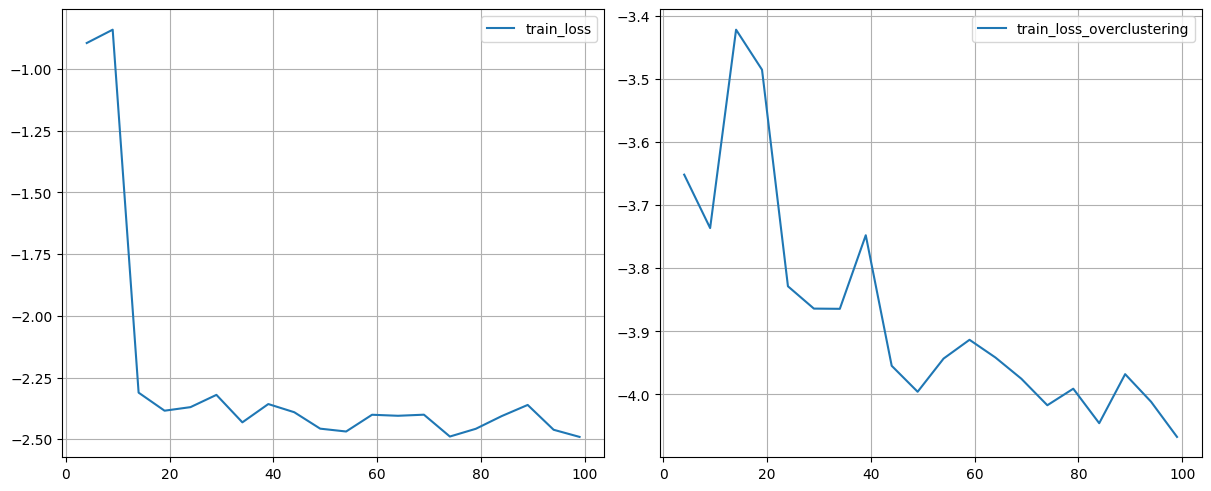

Best Clustering Loss Value: -2.490321


In [ ]:
# training
optimizer = torch.optim.Adam(
    model.parameters(), lr=4e-4, betas=(0.9, 0.999), eps=1e-08,
    weight_decay=0, amsgrad=False)

train( model, dataloader_train, dataloader_val,
    optimizer, device=device, epochs=100, lamb=1.2,
    overcluster_period=20, overcluster_ratio=0.5)

In [ ]:
test_model = VGGClusterisator()
test_model.load_state_dict(torch.load("/content/best_loss_model_cifar10.pth"))
test_model.to(device)

VGGClusterisator(
  (resnet): VGG(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer4): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3)

In [ ]:
# data testing
original_labels, cluster_labels = model_test(
    test_model, dataloader_val, device=device
)

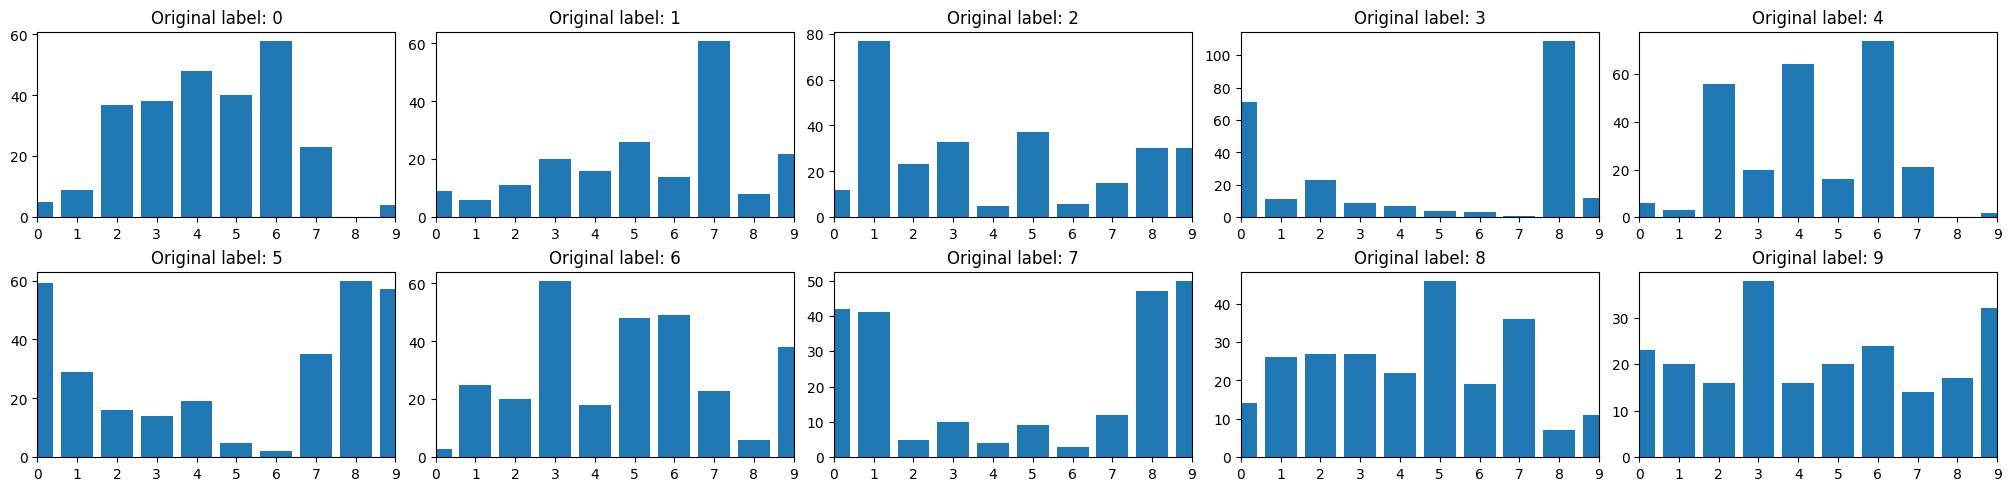

In [ ]:
# visualization
visualise_clusetering_results(original_labels, cluster_labels)

In [ ]:
adj_score = adjusted_rand_score(cluster_labels, original_labels)
hom_score = homogeneity_score(cluster_labels, original_labels)
compl_score = completeness_score(cluster_labels, original_labels)
print("Adjusted rand score: %.3f " % adj_score)
print("Homogeneity score: %.3f " % adj_score)
print("Completeness score: %.3f" % compl_score)

Adjusted rand score: 0.070 
Homogeneity score: 0.070 
Completeness score: 0.136


### **SqueezeNet**

In [ ]:
import torch.nn.init as init

In [ ]:
class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            Fire(64, 16, 64, 64),
            Fire(128, 16, 64, 64),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            Fire(128, 32, 128, 128),
            Fire(256, 32, 128, 128),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            Fire(256, 48, 192, 192)
        )

    def forward(self, x):
        x = self.features(x)
        return x

In [ ]:
inputs = torch.rand(1,3,32,32)
print(inputs.shape)

torch.Size([1, 3, 32, 32])


In [ ]:
model = SqueezeNet()
output = model(inputs)
output.shape

torch.Size([1, 384, 4, 4])

In [ ]:
class SqueezeNetClusterisator(nn.Module):
    def __init__(self):
        super(SqueezeNetClusterisator, self).__init__()
        final_features = 6144
        self.resnet = SqueezeNet()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout()
        self.cluster_head = nn.Linear(final_features, 10)
        self.overcluster_head = nn.Linear(final_features, 50)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x, overclustering=False):
        x = self.resnet(x)
        x = self.flatten(x)
        x = self.dropout(x)
        if overclustering:
            x = self.overcluster_head(x)
        else:
            x = self.cluster_head(x)
        return self.softmax(x)

In [ ]:
# weight initializer
def weight_init(model):
    if isinstance(model, nn.Conv2d):
        nn.init.xavier_normal_(model.weight, gain=nn.init.calculate_gain("relu"))
        if model.bias is not None:
            nn.init.zeros_(model.bias)

    elif isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight)
        if model.bias is not None:
            nn.init.zeros_(model.bias)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)
model = SqueezeNetClusterisator()
model.to(device)
print("The model is transfered to", device)
model.apply(weight_init)
print("The weights are Initialised.")

Using cuda
The model is transfered to cuda
The weights are Initialised.


Epoch 1/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369]
[-0.73772794]


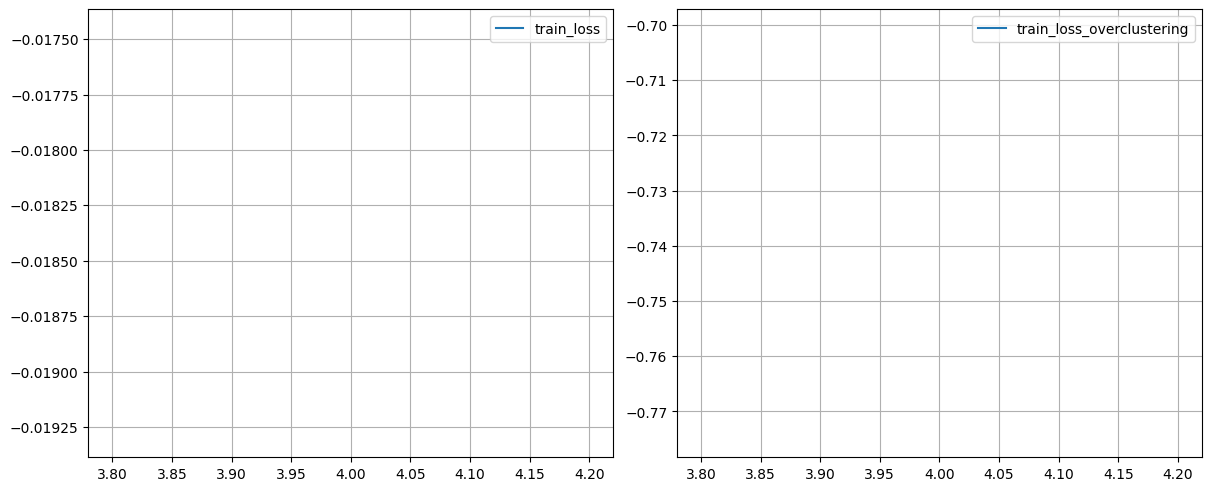

Epoch 6/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405]
[-0.73772794, -0.03148742]


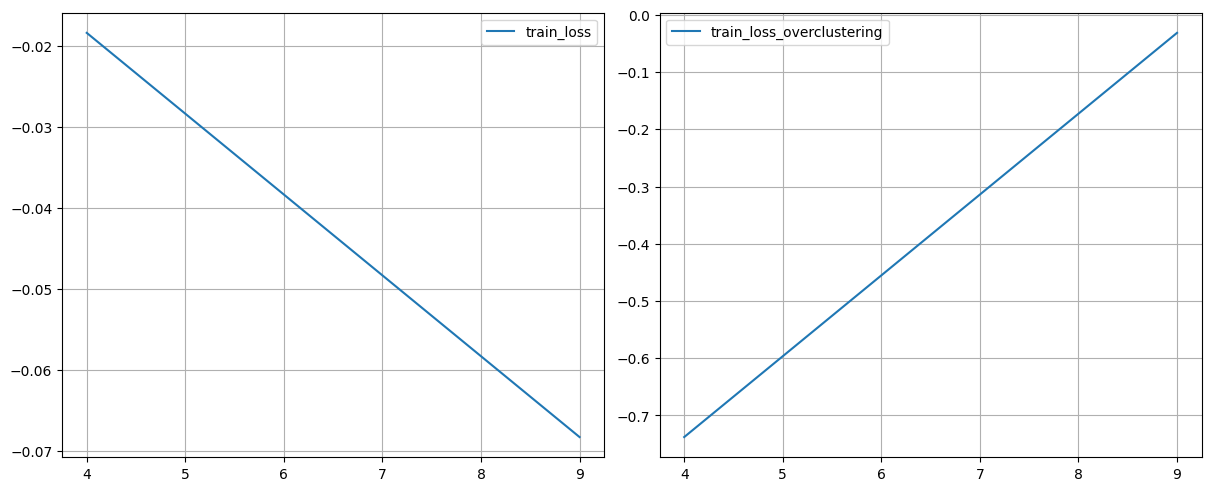

Epoch 11/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405, -0.45761463]
[-0.73772794, -0.03148742, -0.007220248]


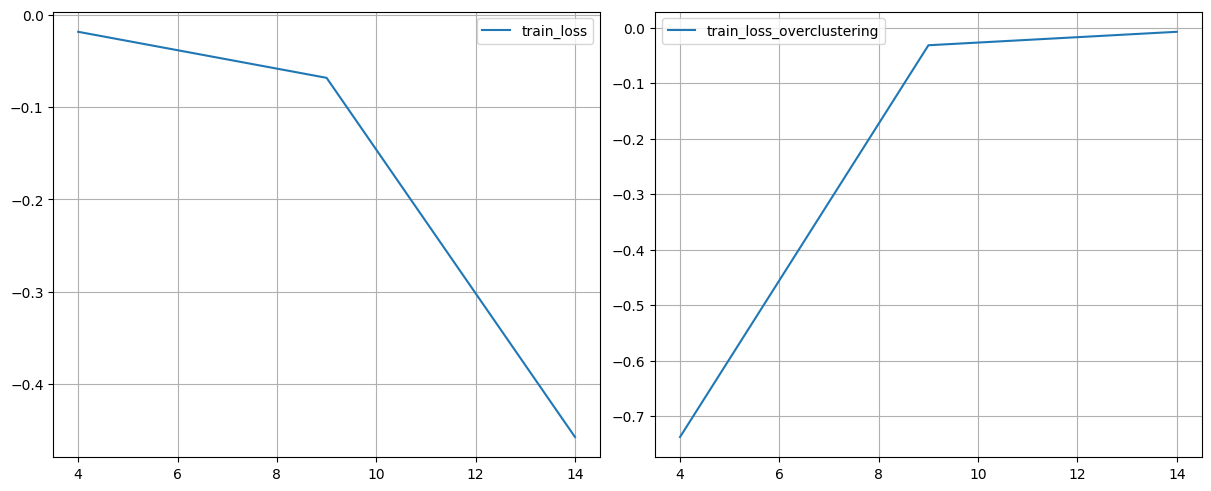

Epoch 16/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 17/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 18/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 19/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 20/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405, -0.45761463, -9.363861e-13]
[-0.73772794, -0.03148742, -0.007220248, -0.002620072]


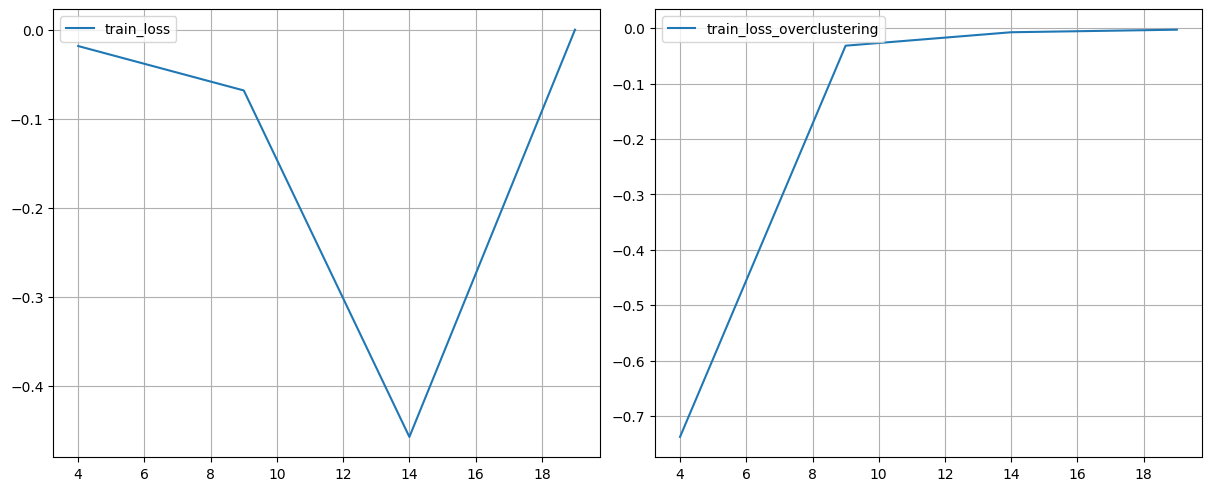

Epoch 21/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 22/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 23/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 24/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 25/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405, -0.45761463, -9.363861e-13, -5.2675576e-11]
[-0.73772794, -0.03148742, -0.007220248, -0.002620072, -0.4375629]


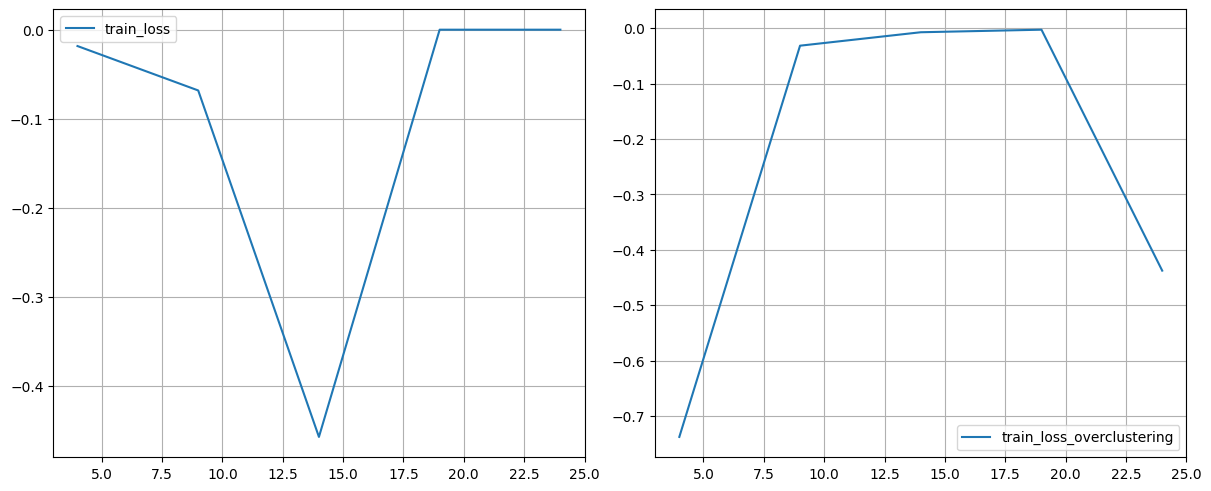

Epoch 26/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 27/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 28/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 29/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 30/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405, -0.45761463, -9.363861e-13, -5.2675576e-11, -4.21044e-06]
[-0.73772794, -0.03148742, -0.007220248, -0.002620072, -0.4375629, -2.7028378e-11]


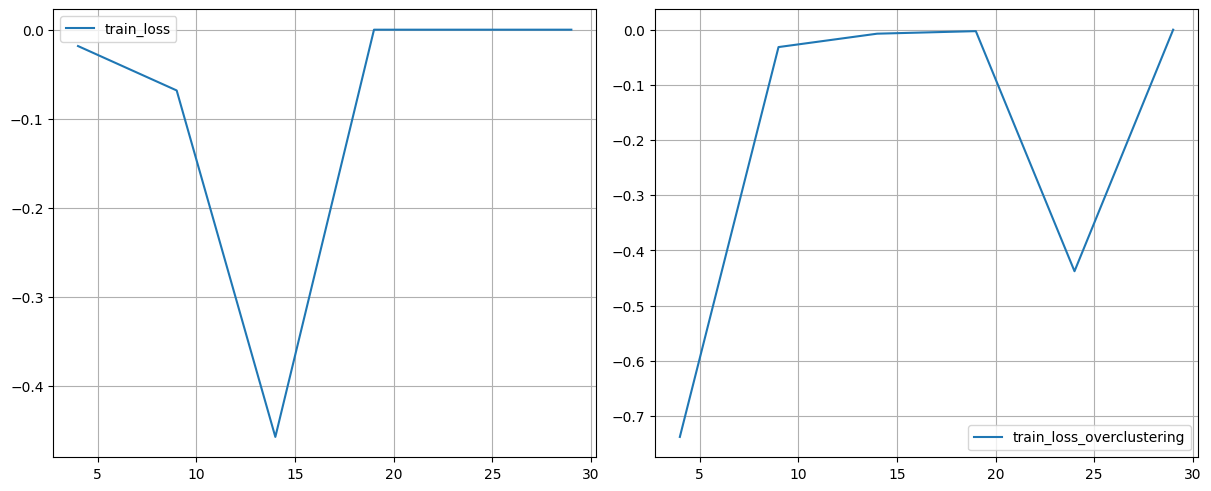

Epoch 31/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 32/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 33/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 34/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 35/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405, -0.45761463, -9.363861e-13, -5.2675576e-11, -4.21044e-06, -0.027764311]
[-0.73772794, -0.03148742, -0.007220248, -0.002620072, -0.4375629, -2.7028378e-11, -0.009422452]


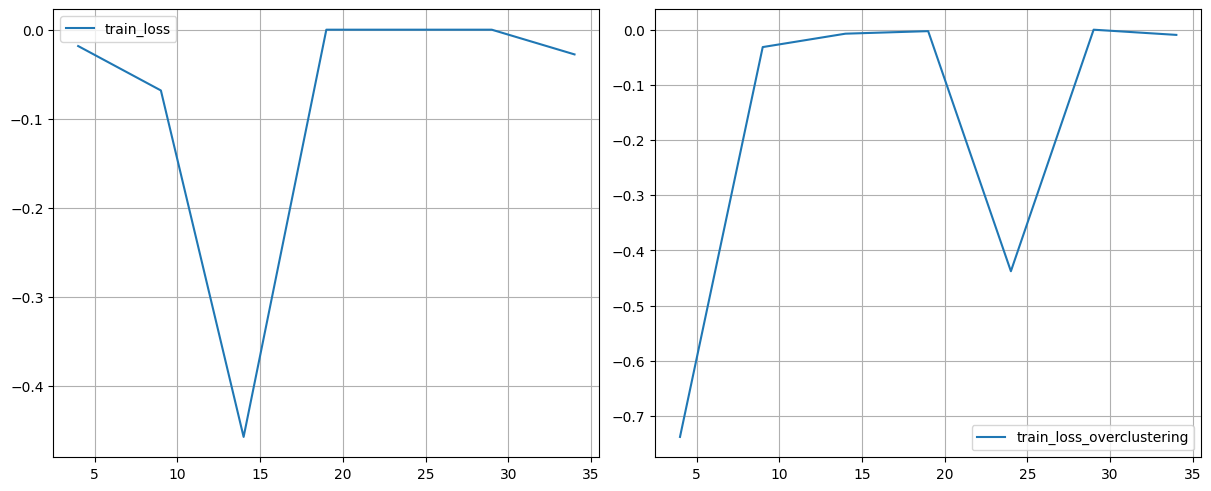

Epoch 36/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 37/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 38/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 39/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 40/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405, -0.45761463, -9.363861e-13, -5.2675576e-11, -4.21044e-06, -0.027764311, -0.019870458]
[-0.73772794, -0.03148742, -0.007220248, -0.002620072, -0.4375629, -2.7028378e-11, -0.009422452, -0.0034373298]


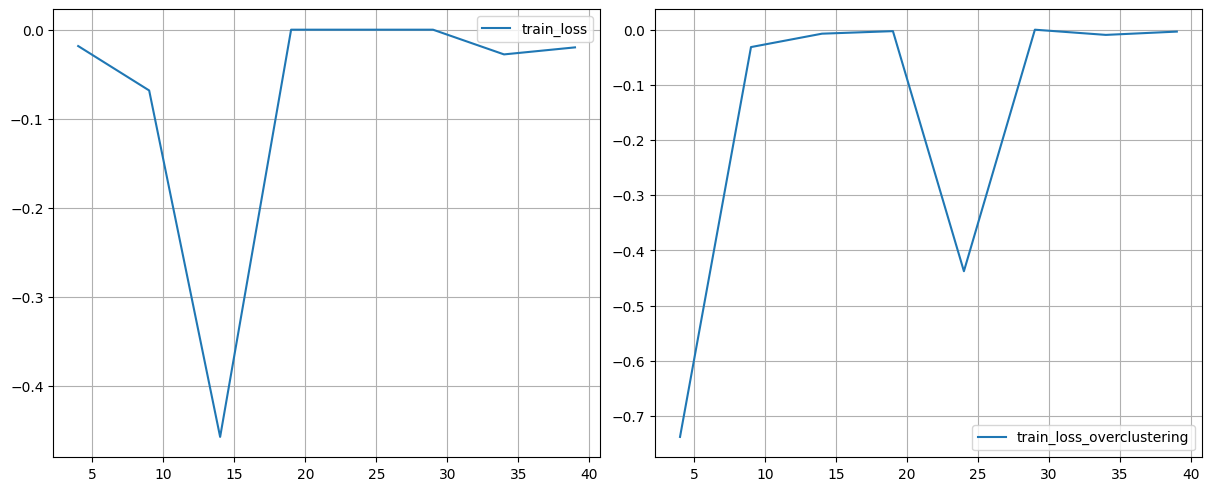

Epoch 41/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 42/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 43/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 44/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 45/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405, -0.45761463, -9.363861e-13, -5.2675576e-11, -4.21044e-06, -0.027764311, -0.019870458, -0.054817546]
[-0.73772794, -0.03148742, -0.007220248, -0.002620072, -0.4375629, -2.7028378e-11, -0.009422452, -0.0034373298, -0.5708825]


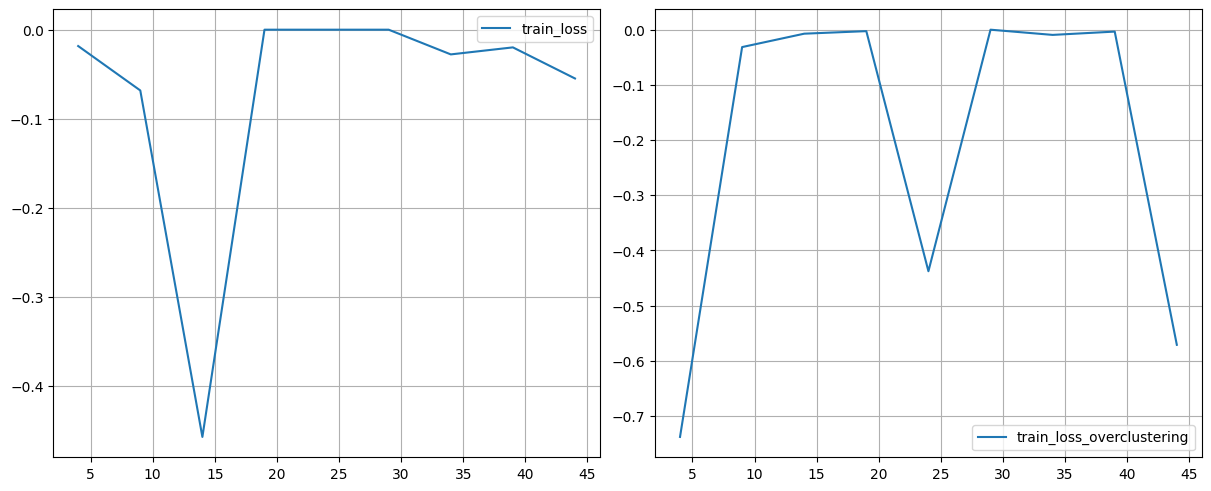

Epoch 46/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 47/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 48/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 49/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 50/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405, -0.45761463, -9.363861e-13, -5.2675576e-11, -4.21044e-06, -0.027764311, -0.019870458, -0.054817546, -0.3832562]
[-0.73772794, -0.03148742, -0.007220248, -0.002620072, -0.4375629, -2.7028378e-11, -0.009422452, -0.0034373298, -0.5708825, -0.60330755]


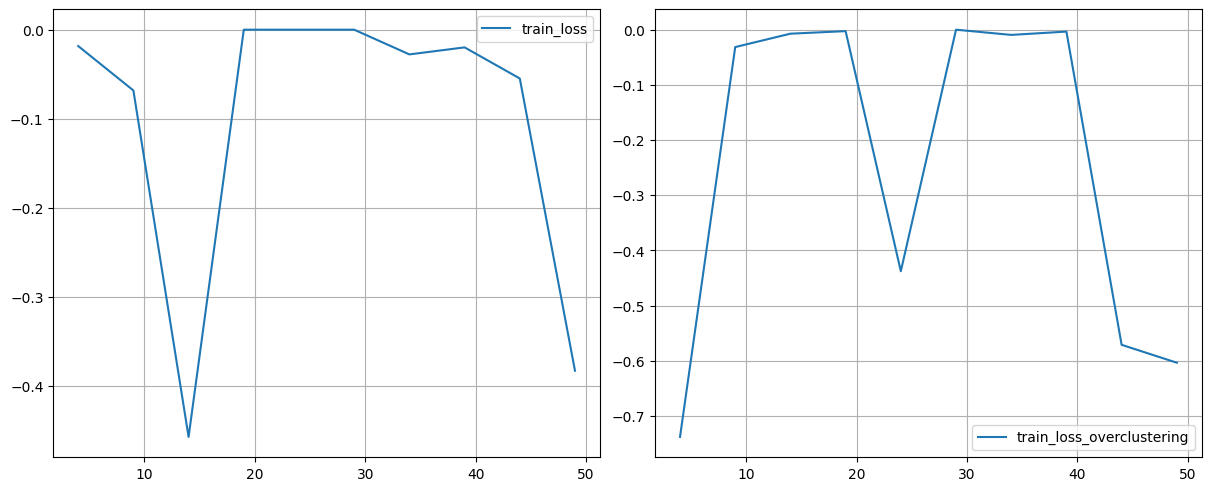

Epoch 51/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 52/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 53/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 54/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 55/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405, -0.45761463, -9.363861e-13, -5.2675576e-11, -4.21044e-06, -0.027764311, -0.019870458, -0.054817546, -0.3832562, -0.03803317]
[-0.73772794, -0.03148742, -0.007220248, -0.002620072, -0.4375629, -2.7028378e-11, -0.009422452, -0.0034373298, -0.5708825, -0.60330755, -0.28748074]


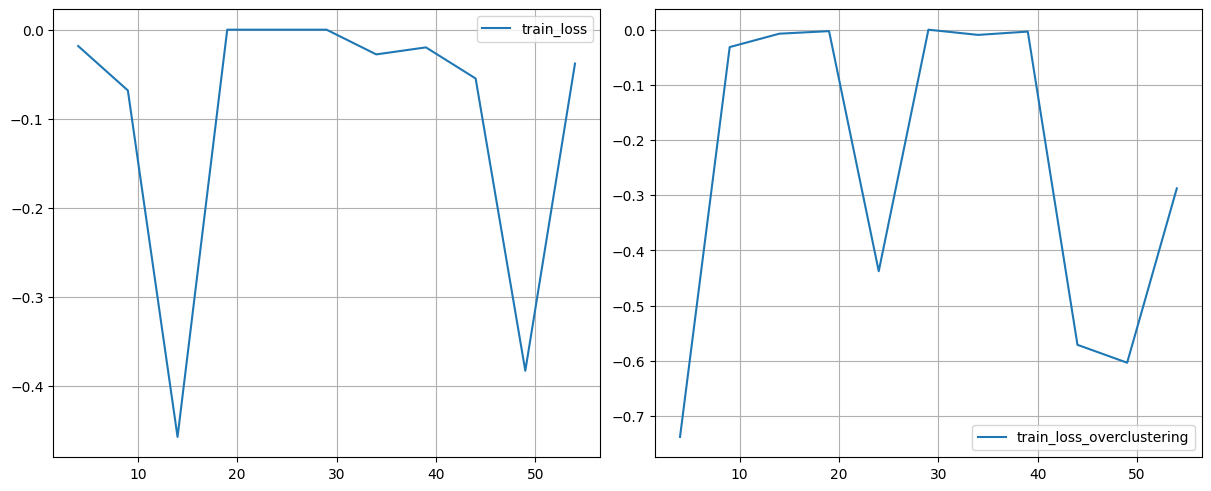

Epoch 56/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 57/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 58/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 59/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 60/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405, -0.45761463, -9.363861e-13, -5.2675576e-11, -4.21044e-06, -0.027764311, -0.019870458, -0.054817546, -0.3832562, -0.03803317, -0.042388707]
[-0.73772794, -0.03148742, -0.007220248, -0.002620072, -0.4375629, -2.7028378e-11, -0.009422452, -0.0034373298, -0.5708825, -0.60330755, -0.28748074, -0.30670866]


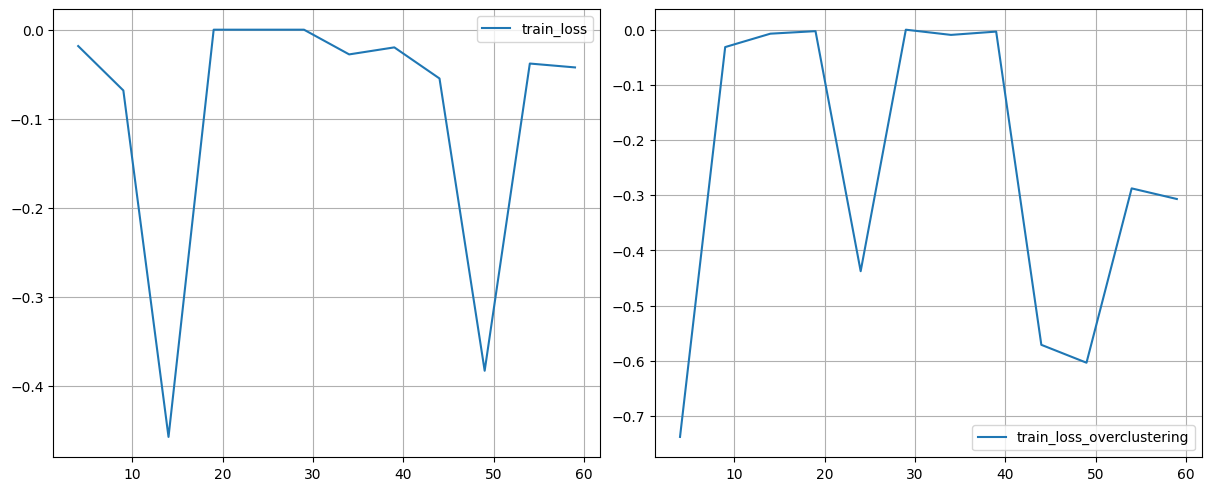

Epoch 61/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 62/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 63/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 64/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 65/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405, -0.45761463, -9.363861e-13, -5.2675576e-11, -4.21044e-06, -0.027764311, -0.019870458, -0.054817546, -0.3832562, -0.03803317, -0.042388707, -0.24977423]
[-0.73772794, -0.03148742, -0.007220248, -0.002620072, -0.4375629, -2.7028378e-11, -0.009422452, -0.0034373298, -0.5708825, -0.60330755, -0.28748074, -0.30670866, -0.2846131]


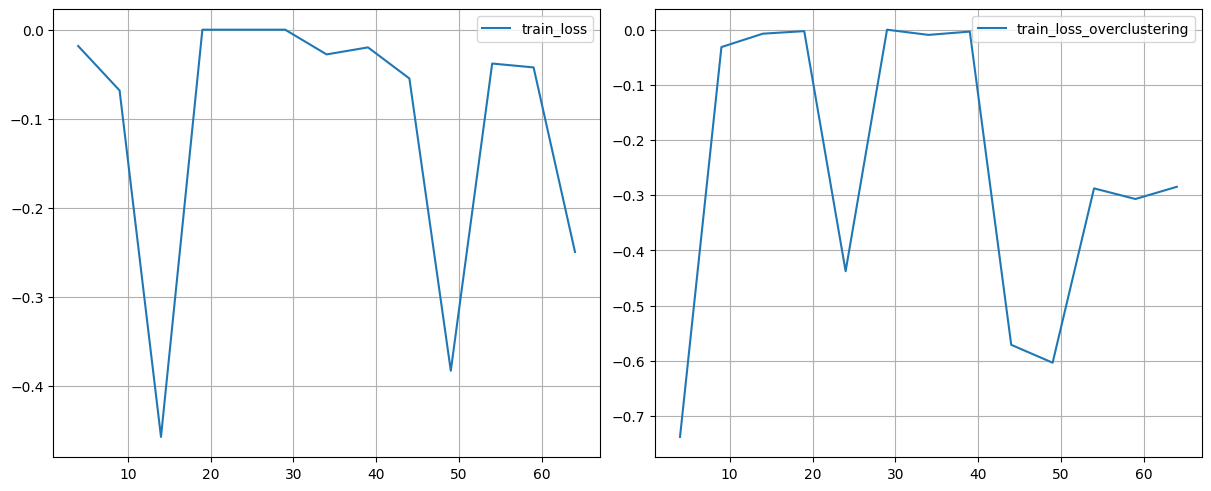

Epoch 66/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 67/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 68/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 69/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 70/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405, -0.45761463, -9.363861e-13, -5.2675576e-11, -4.21044e-06, -0.027764311, -0.019870458, -0.054817546, -0.3832562, -0.03803317, -0.042388707, -0.24977423, -0.02177231]
[-0.73772794, -0.03148742, -0.007220248, -0.002620072, -0.4375629, -2.7028378e-11, -0.009422452, -0.0034373298, -0.5708825, -0.60330755, -0.28748074, -0.30670866, -0.2846131, -0.03421319]


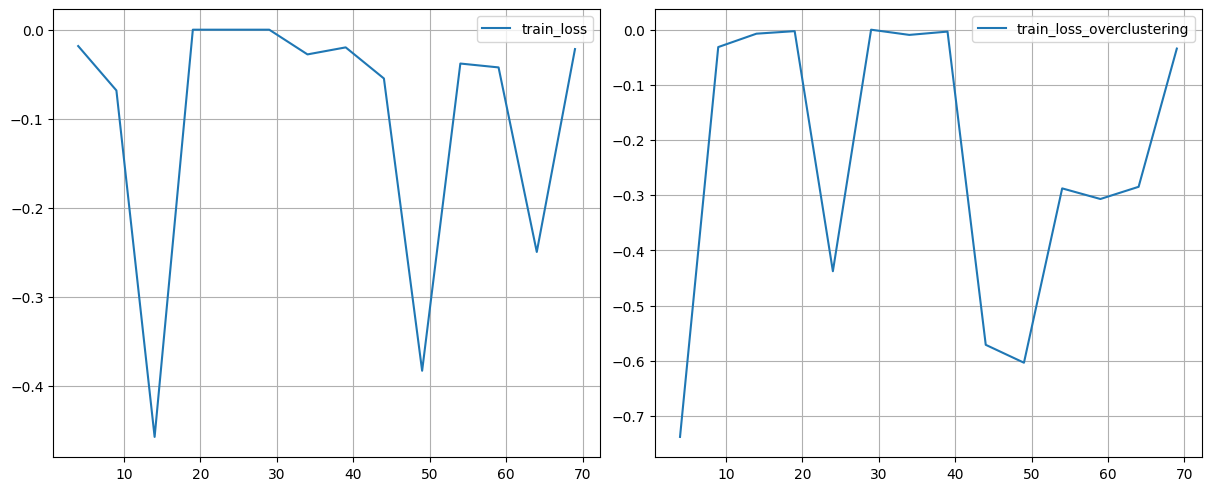

Epoch 71/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 72/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 73/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 74/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 75/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405, -0.45761463, -9.363861e-13, -5.2675576e-11, -4.21044e-06, -0.027764311, -0.019870458, -0.054817546, -0.3832562, -0.03803317, -0.042388707, -0.24977423, -0.02177231, -0.16746564]
[-0.73772794, -0.03148742, -0.007220248, -0.002620072, -0.4375629, -2.7028378e-11, -0.009422452, -0.0034373298, -0.5708825, -0.60330755, -0.28748074, -0.30670866, -0.2846131, -0.03421319, -0.2133507]


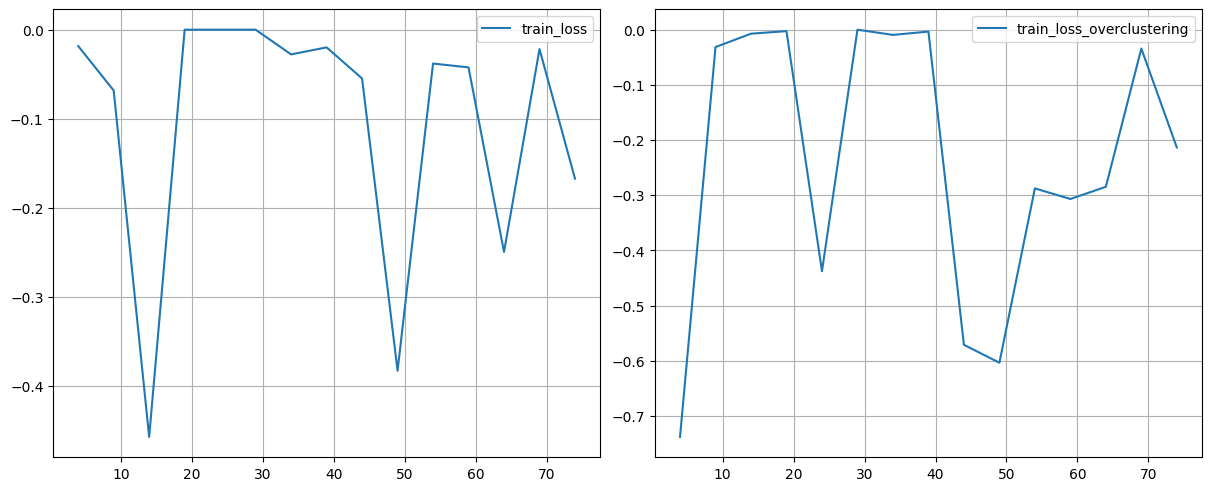

Epoch 76/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 77/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 78/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 79/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 80/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405, -0.45761463, -9.363861e-13, -5.2675576e-11, -4.21044e-06, -0.027764311, -0.019870458, -0.054817546, -0.3832562, -0.03803317, -0.042388707, -0.24977423, -0.02177231, -0.16746564, -0.5758324]
[-0.73772794, -0.03148742, -0.007220248, -0.002620072, -0.4375629, -2.7028378e-11, -0.009422452, -0.0034373298, -0.5708825, -0.60330755, -0.28748074, -0.30670866, -0.2846131, -0.03421319, -0.2133507, -0.93959683]


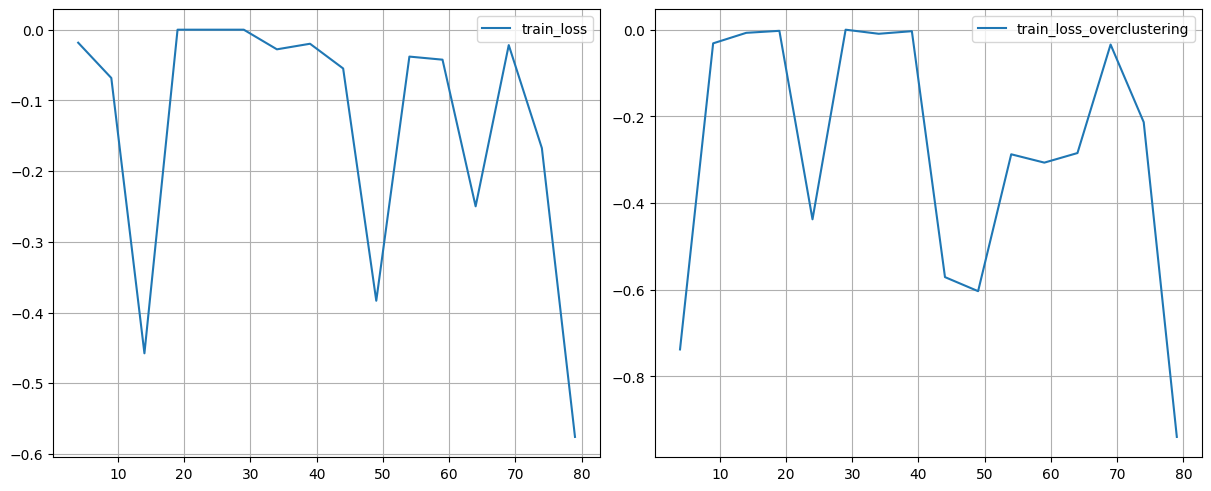

Epoch 81/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 82/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 83/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 84/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 85/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405, -0.45761463, -9.363861e-13, -5.2675576e-11, -4.21044e-06, -0.027764311, -0.019870458, -0.054817546, -0.3832562, -0.03803317, -0.042388707, -0.24977423, -0.02177231, -0.16746564, -0.5758324, -0.5523036]
[-0.73772794, -0.03148742, -0.007220248, -0.002620072, -0.4375629, -2.7028378e-11, -0.009422452, -0.0034373298, -0.5708825, -0.60330755, -0.28748074, -0.30670866, -0.2846131, -0.03421319, -0.2133507, -0.93959683, -0.8160374]


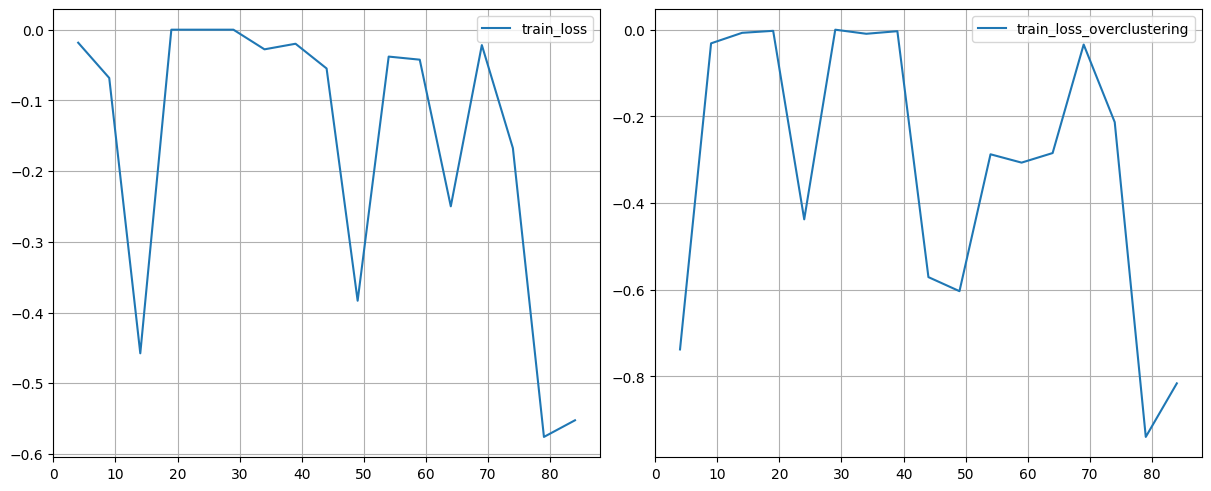

Epoch 86/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 87/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 88/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 89/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 90/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405, -0.45761463, -9.363861e-13, -5.2675576e-11, -4.21044e-06, -0.027764311, -0.019870458, -0.054817546, -0.3832562, -0.03803317, -0.042388707, -0.24977423, -0.02177231, -0.16746564, -0.5758324, -0.5523036, -0.4733084]
[-0.73772794, -0.03148742, -0.007220248, -0.002620072, -0.4375629, -2.7028378e-11, -0.009422452, -0.0034373298, -0.5708825, -0.60330755, -0.28748074, -0.30670866, -0.2846131, -0.03421319, -0.2133507, -0.93959683, -0.8160374, -0.63124794]


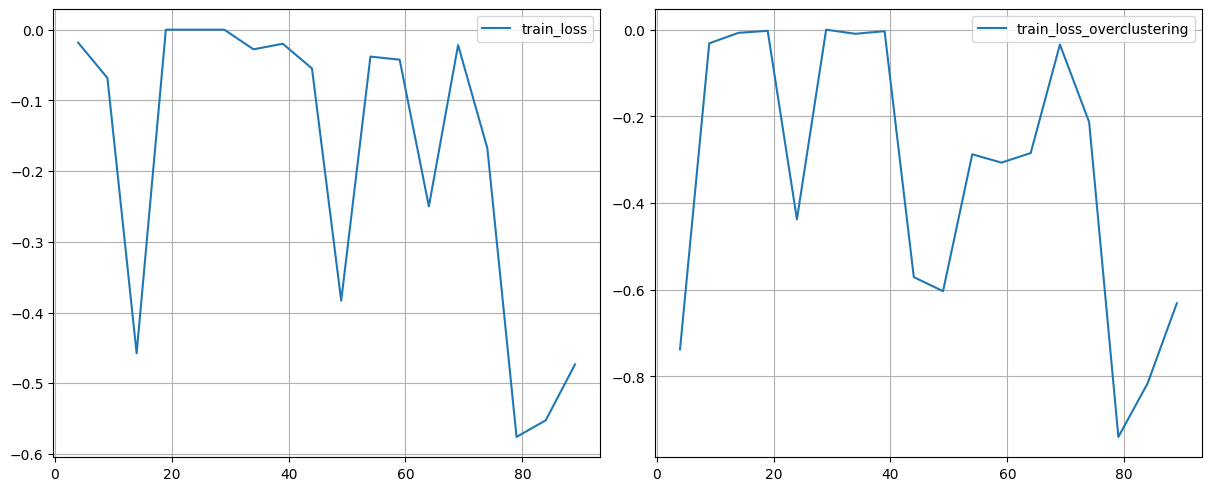

Epoch 91/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 92/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 93/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 94/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 95/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405, -0.45761463, -9.363861e-13, -5.2675576e-11, -4.21044e-06, -0.027764311, -0.019870458, -0.054817546, -0.3832562, -0.03803317, -0.042388707, -0.24977423, -0.02177231, -0.16746564, -0.5758324, -0.5523036, -0.4733084, -0.16992128]
[-0.73772794, -0.03148742, -0.007220248, -0.002620072, -0.4375629, -2.7028378e-11, -0.009422452, -0.0034373298, -0.5708825, -0.60330755, -0.28748074, -0.30670866, -0.2846131, -0.03421319, -0.2133507, -0.93959683, -0.8160374, -0.63124794, -0.705797]


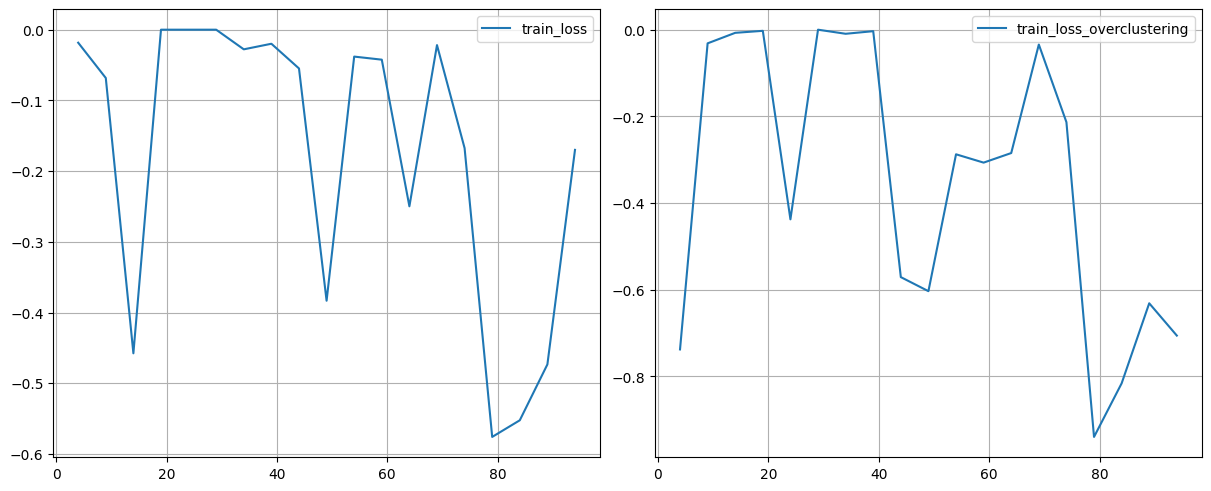

Epoch 96/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 97/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 98/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 99/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 100/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.018376369, -0.068281405, -0.45761463, -9.363861e-13, -5.2675576e-11, -4.21044e-06, -0.027764311, -0.019870458, -0.054817546, -0.3832562, -0.03803317, -0.042388707, -0.24977423, -0.02177231, -0.16746564, -0.5758324, -0.5523036, -0.4733084, -0.16992128, -0.2908155]
[-0.73772794, -0.03148742, -0.007220248, -0.002620072, -0.4375629, -2.7028378e-11, -0.009422452, -0.0034373298, -0.5708825, -0.60330755, -0.28748074, -0.30670866, -0.2846131, -0.03421319, -0.2133507, -0.93959683, -0.8160374, -0.63124794, -0.705797, -0.839034]


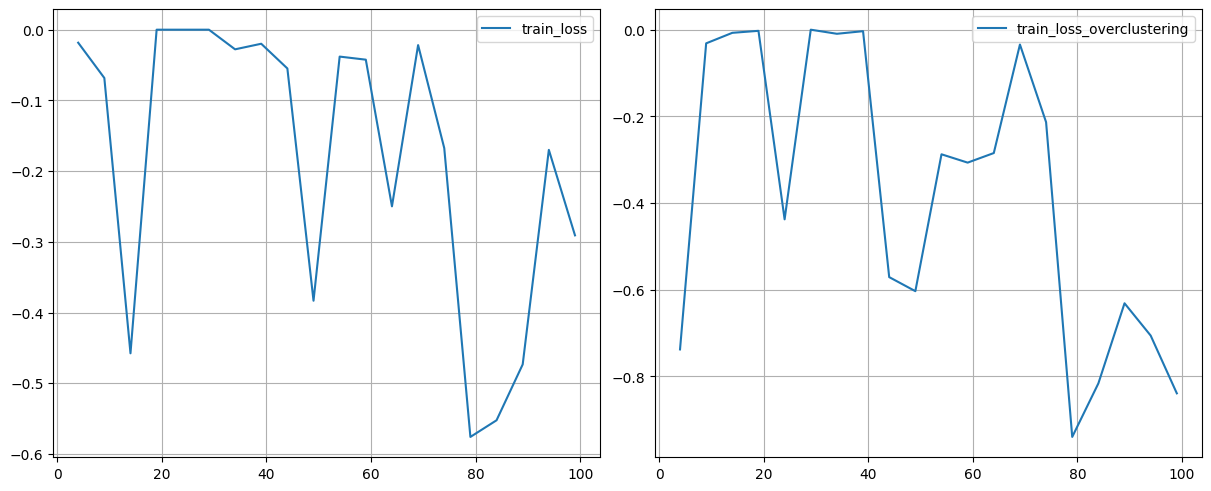

Best Clustering Loss Value: -0.5758324


In [ ]:
# training
optimizer = torch.optim.Adam(
    model.parameters(), lr=4e-4, betas=(0.9, 0.999), eps=1e-08,
    weight_decay=0, amsgrad=False)

train( model, dataloader_train, dataloader_val,
    optimizer, device=device, epochs=100, lamb=1.2,
    overcluster_period=20, overcluster_ratio=0.5)

In [ ]:
test_model = SqueezeNetClusterisator()
test_model.load_state_dict(torch.load("/content/best_loss_model_cifar10.pth"))
test_model.to(device)

SqueezeNetClusterisator(
  (resnet): SqueezeNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
# data testing
original_labels, cluster_labels = model_test(
    test_model, dataloader_val, device=device
)

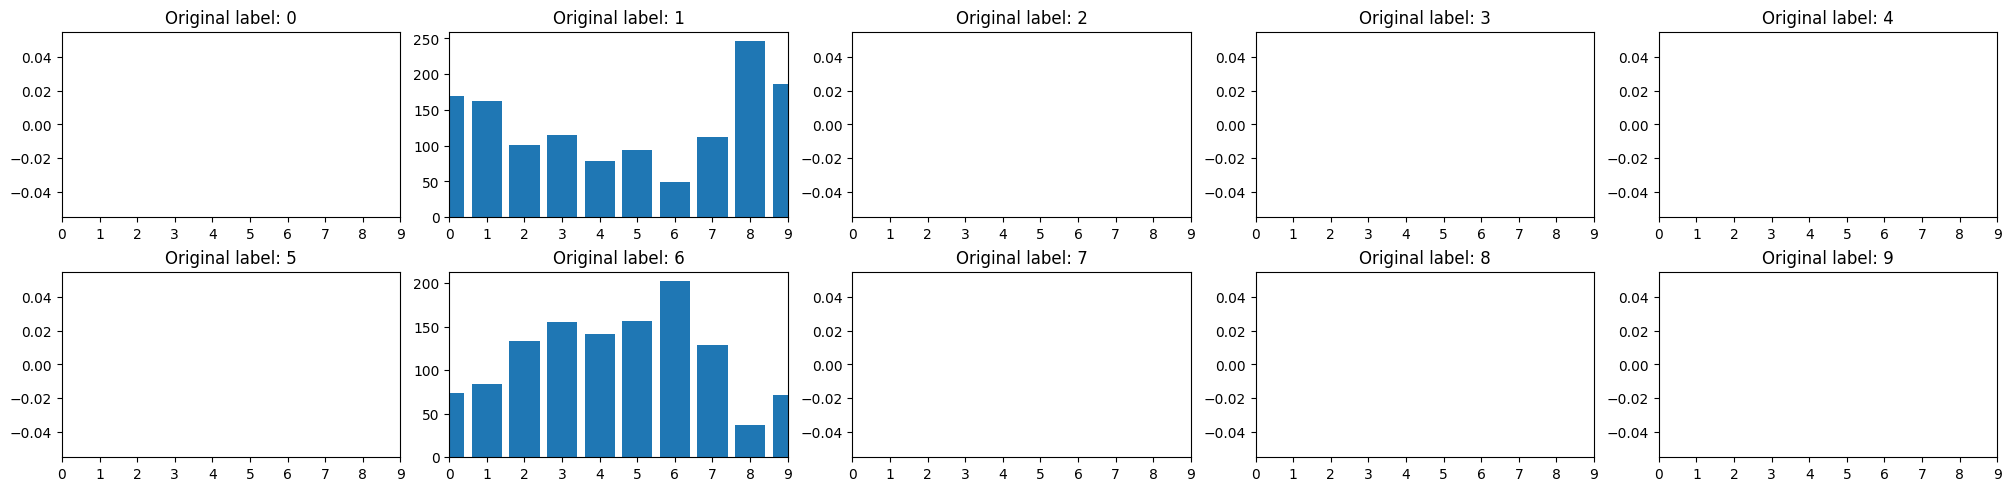

In [ ]:
# visualization
visualise_clusetering_results(original_labels, cluster_labels)

In [ ]:
adj_score = adjusted_rand_score(cluster_labels, original_labels)
hom_score = homogeneity_score(cluster_labels, original_labels)
compl_score = completeness_score(cluster_labels, original_labels)
print("Adjusted rand score: %.3f " % adj_score)
print("Homogeneity score: %.3f " % adj_score)
print("Completeness score: %.3f" % compl_score)

Adjusted rand score: 0.033 
Homogeneity score: 0.033 
Completeness score: 0.037


## **Custom CNN**

In [ ]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.features(x)
        return x

In [ ]:
inputs = torch.rand(3,32,32)
model = CustomModel()
output = model(inputs)
output.shape

torch.Size([64, 5, 5])

In [ ]:
class CustomModelClusterisator(nn.Module):
    def __init__(self):
        super(CustomModelClusterisator, self).__init__()
        final_features = 1600
        self.resnet = CustomModel()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout()
        self.cluster_head = nn.Linear(final_features, 10)
        self.overcluster_head = nn.Linear(final_features, 50)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x, overclustering=False):
        x = self.resnet(x)
        x = self.flatten(x)
        x = self.dropout(x)
        if overclustering:
            x = self.overcluster_head(x)
        else:
            x = self.cluster_head(x)
        return self.softmax(x)

In [ ]:
# weight initializer
def weight_init(model):
    if isinstance(model, nn.Conv2d):
        nn.init.xavier_normal_(model.weight, gain=nn.init.calculate_gain("relu"))
        if model.bias is not None:
            nn.init.zeros_(model.bias)

    elif isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight)
        if model.bias is not None:
            nn.init.zeros_(model.bias)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)
model = CustomModelClusterisator()
model.to(device)
print("The model is transfered to", device)
model.apply(weight_init)
print("The weights are Initialised.")

Using cuda
The model is transfered to cuda
The weights are Initialised.


Epoch 1/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799]
[-1.3549324]


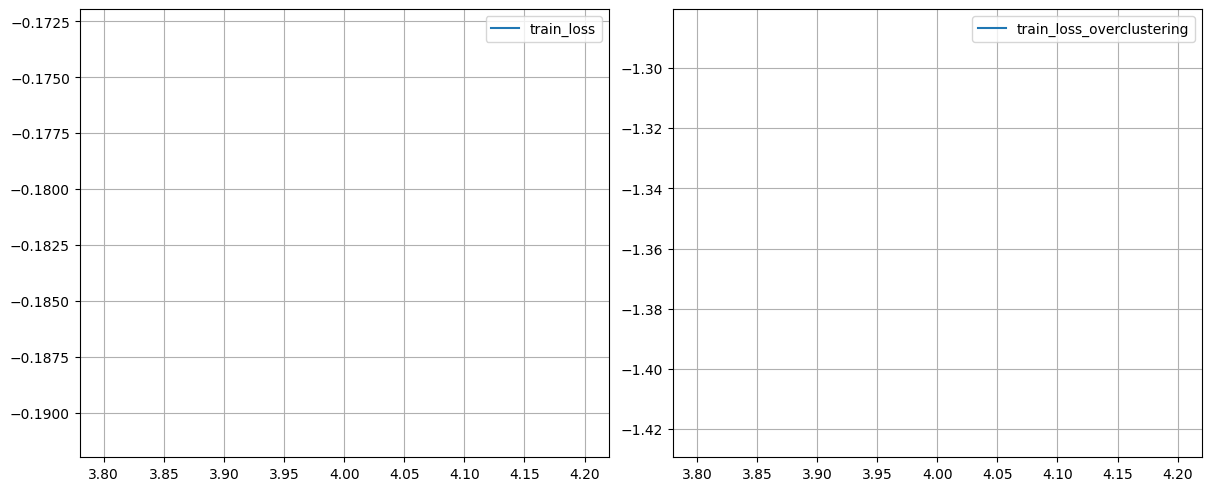

Epoch 6/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416]
[-1.3549324, -1.2566711]


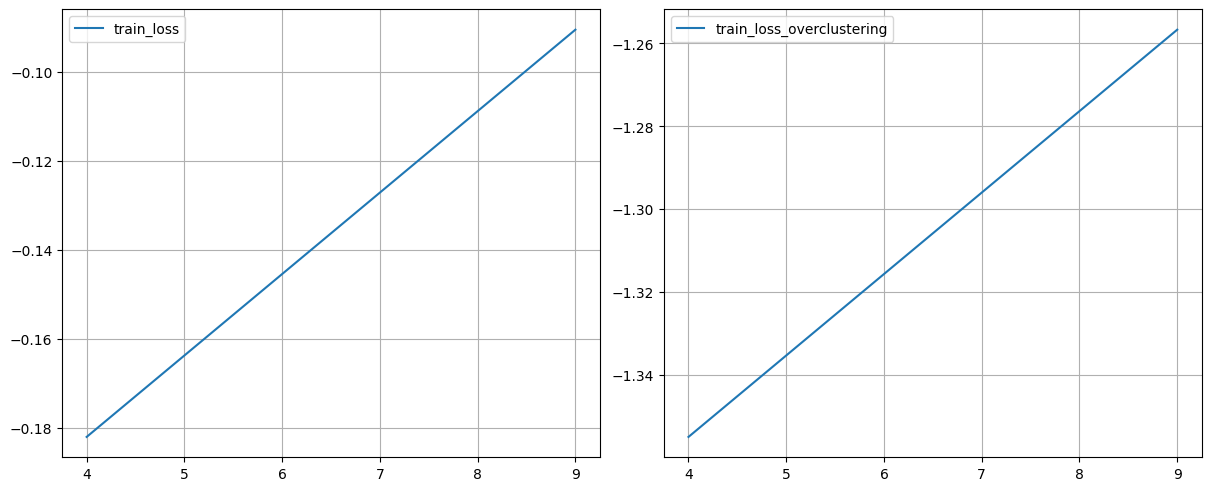

Epoch 11/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416, -1.0543495]
[-1.3549324, -1.2566711, -1.3318707]


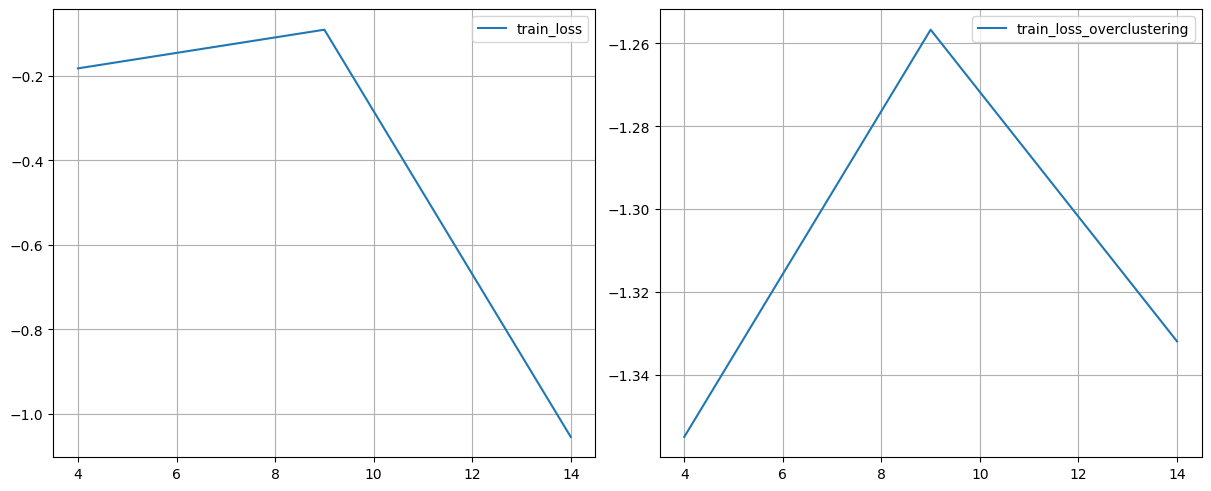

Epoch 16/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 17/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 18/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 19/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 20/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416, -1.0543495, -0.89254475]
[-1.3549324, -1.2566711, -1.3318707, -0.9722884]


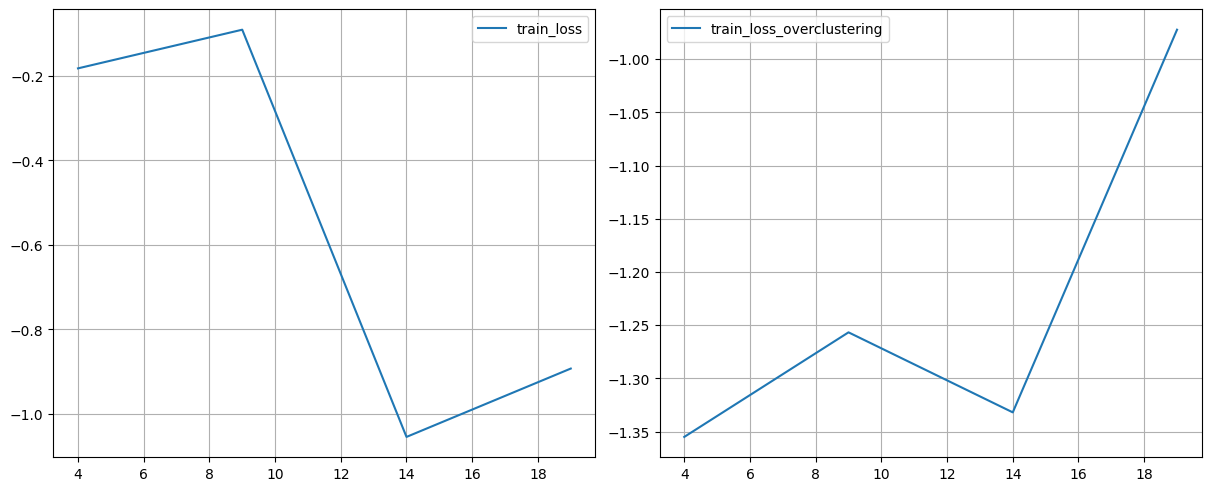

Epoch 21/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 22/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 23/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 24/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 25/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416, -1.0543495, -0.89254475, -1.0231663]
[-1.3549324, -1.2566711, -1.3318707, -0.9722884, -1.0383947]


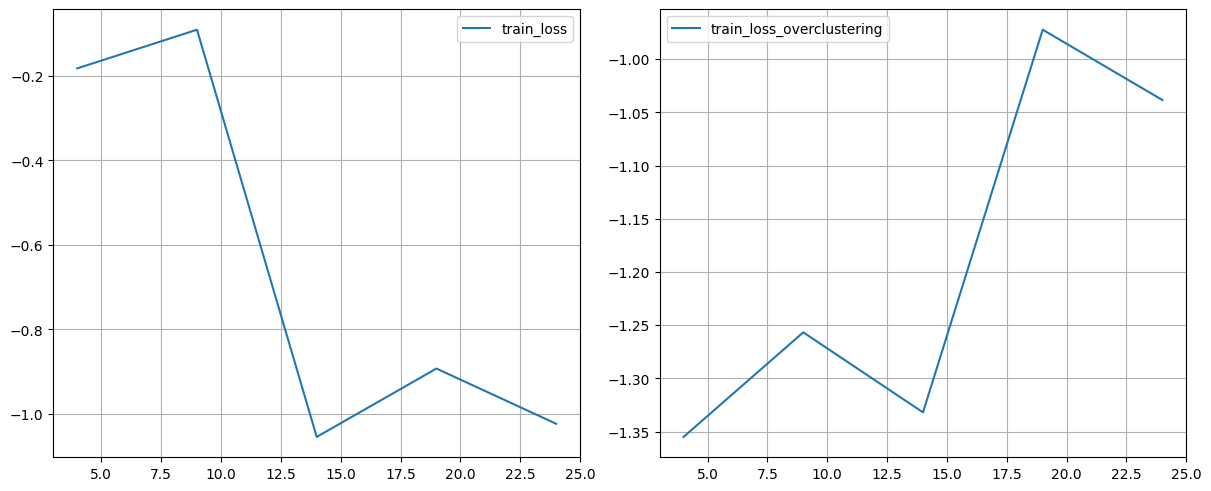

Epoch 26/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 27/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 28/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 29/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 30/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416, -1.0543495, -0.89254475, -1.0231663, -0.40667835]
[-1.3549324, -1.2566711, -1.3318707, -0.9722884, -1.0383947, -1.1127188]


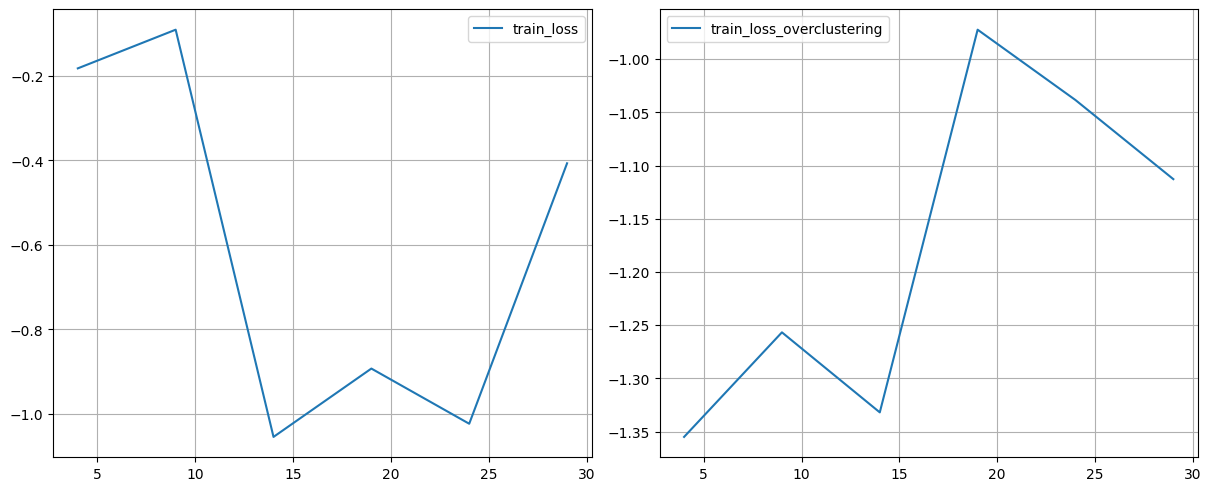

Epoch 31/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 32/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 33/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 34/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 35/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416, -1.0543495, -0.89254475, -1.0231663, -0.40667835, -0.9253451]
[-1.3549324, -1.2566711, -1.3318707, -0.9722884, -1.0383947, -1.1127188, -1.1343035]


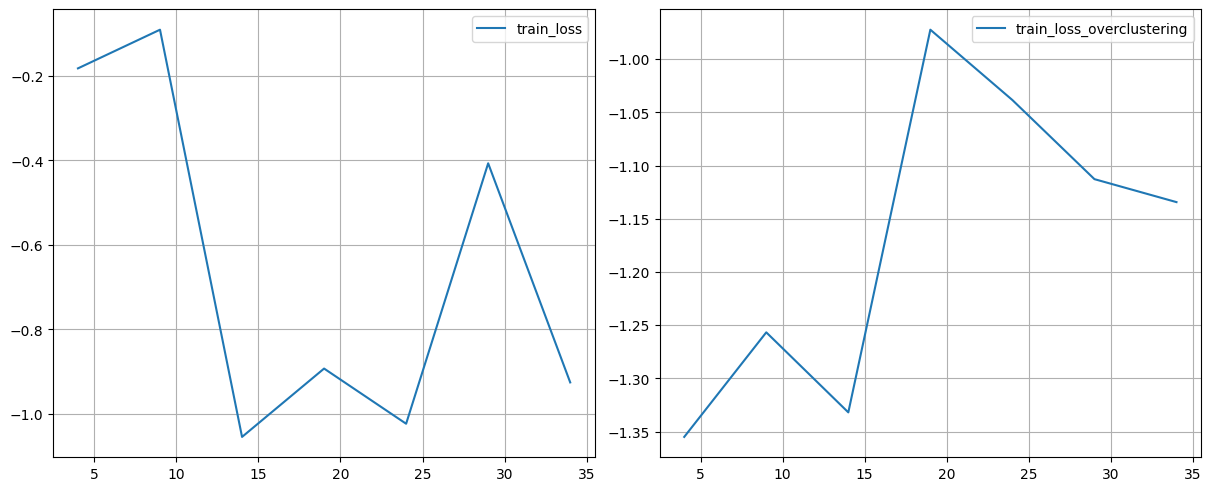

Epoch 36/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 37/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 38/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 39/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 40/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416, -1.0543495, -0.89254475, -1.0231663, -0.40667835, -0.9253451, -0.82863194]
[-1.3549324, -1.2566711, -1.3318707, -0.9722884, -1.0383947, -1.1127188, -1.1343035, -1.0972048]


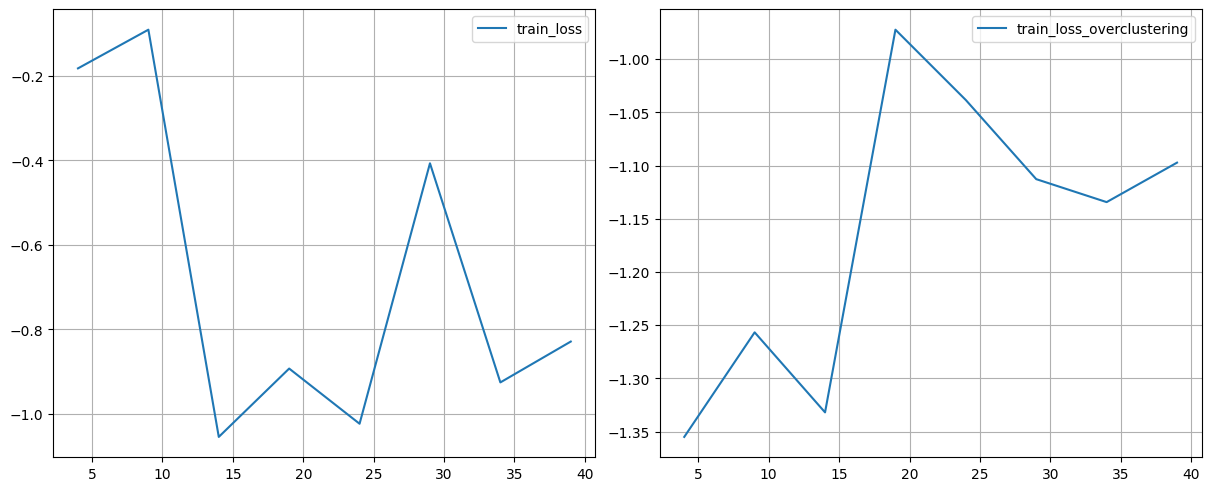

Epoch 41/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 42/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 43/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 44/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 45/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416, -1.0543495, -0.89254475, -1.0231663, -0.40667835, -0.9253451, -0.82863194, -0.7741542]
[-1.3549324, -1.2566711, -1.3318707, -0.9722884, -1.0383947, -1.1127188, -1.1343035, -1.0972048, -0.7995259]


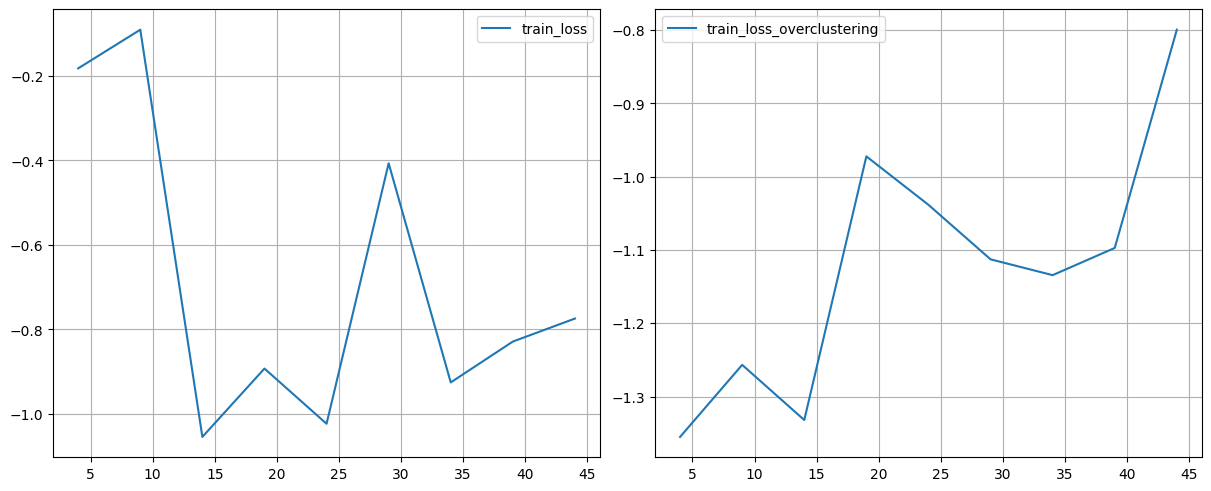

Epoch 46/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 47/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 48/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 49/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 50/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416, -1.0543495, -0.89254475, -1.0231663, -0.40667835, -0.9253451, -0.82863194, -0.7741542, -0.9136786]
[-1.3549324, -1.2566711, -1.3318707, -0.9722884, -1.0383947, -1.1127188, -1.1343035, -1.0972048, -0.7995259, -0.5936545]


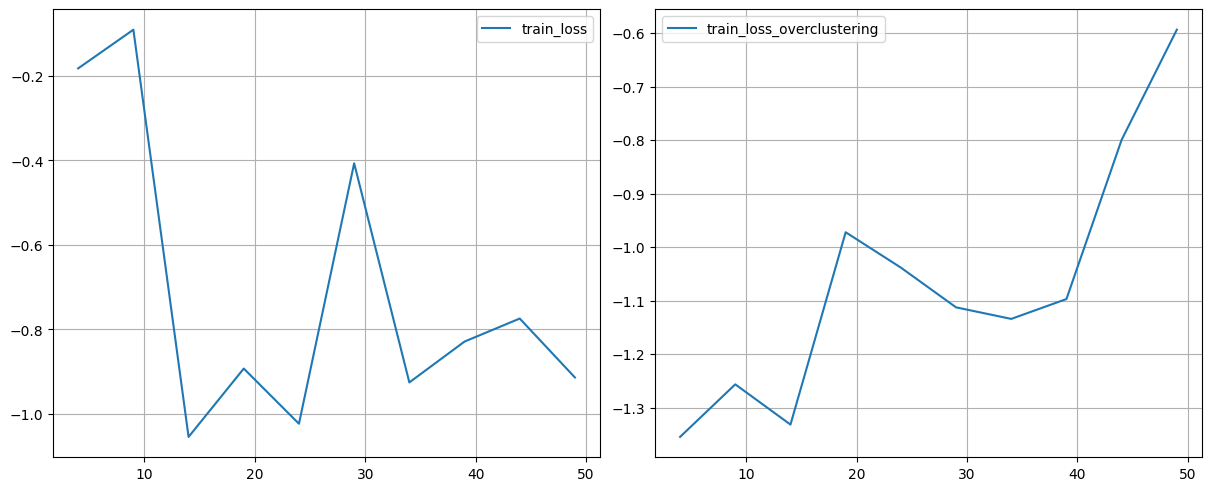

Epoch 51/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 52/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 53/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 54/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 55/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416, -1.0543495, -0.89254475, -1.0231663, -0.40667835, -0.9253451, -0.82863194, -0.7741542, -0.9136786, -0.85396767]
[-1.3549324, -1.2566711, -1.3318707, -0.9722884, -1.0383947, -1.1127188, -1.1343035, -1.0972048, -0.7995259, -0.5936545, -0.7132315]


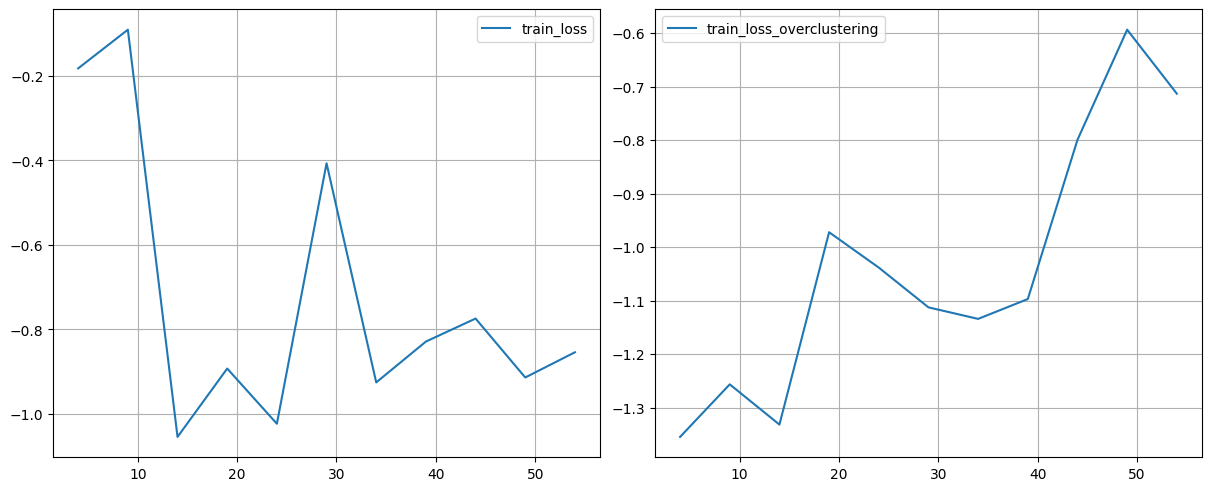

Epoch 56/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 57/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 58/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 59/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 60/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416, -1.0543495, -0.89254475, -1.0231663, -0.40667835, -0.9253451, -0.82863194, -0.7741542, -0.9136786, -0.85396767, -0.9490797]
[-1.3549324, -1.2566711, -1.3318707, -0.9722884, -1.0383947, -1.1127188, -1.1343035, -1.0972048, -0.7995259, -0.5936545, -0.7132315, -0.726504]


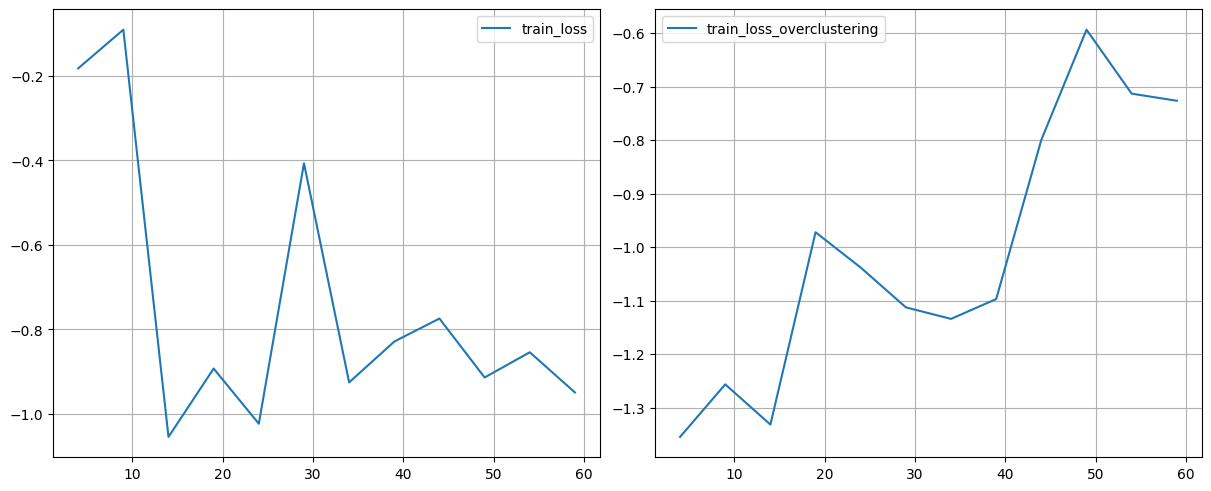

Epoch 61/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 62/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 63/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 64/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 65/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416, -1.0543495, -0.89254475, -1.0231663, -0.40667835, -0.9253451, -0.82863194, -0.7741542, -0.9136786, -0.85396767, -0.9490797, -0.89880973]
[-1.3549324, -1.2566711, -1.3318707, -0.9722884, -1.0383947, -1.1127188, -1.1343035, -1.0972048, -0.7995259, -0.5936545, -0.7132315, -0.726504, -1.2418869]


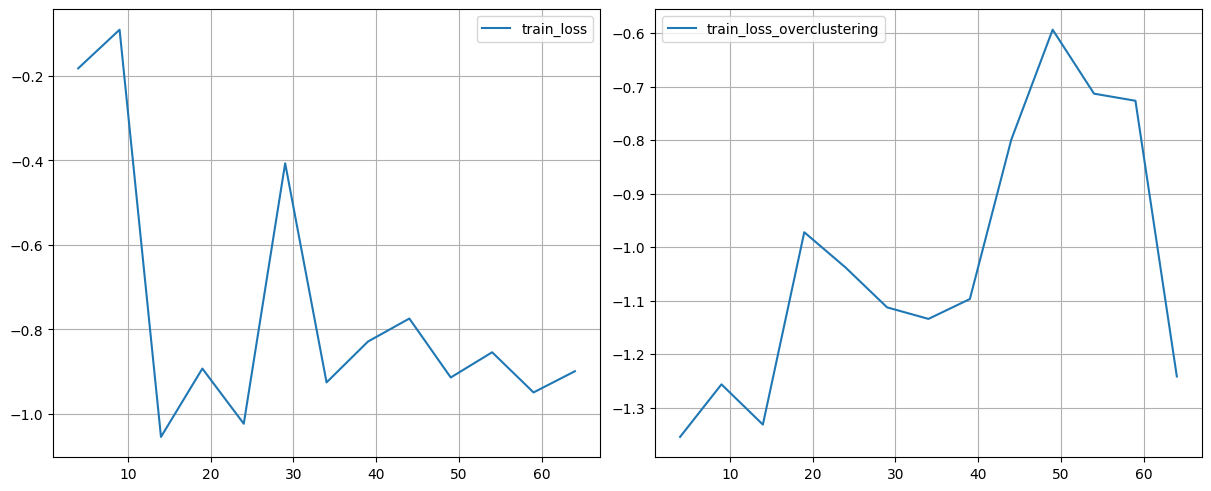

Epoch 66/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 67/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 68/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 69/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 70/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416, -1.0543495, -0.89254475, -1.0231663, -0.40667835, -0.9253451, -0.82863194, -0.7741542, -0.9136786, -0.85396767, -0.9490797, -0.89880973, -1.1620911]
[-1.3549324, -1.2566711, -1.3318707, -0.9722884, -1.0383947, -1.1127188, -1.1343035, -1.0972048, -0.7995259, -0.5936545, -0.7132315, -0.726504, -1.2418869, -0.75731516]


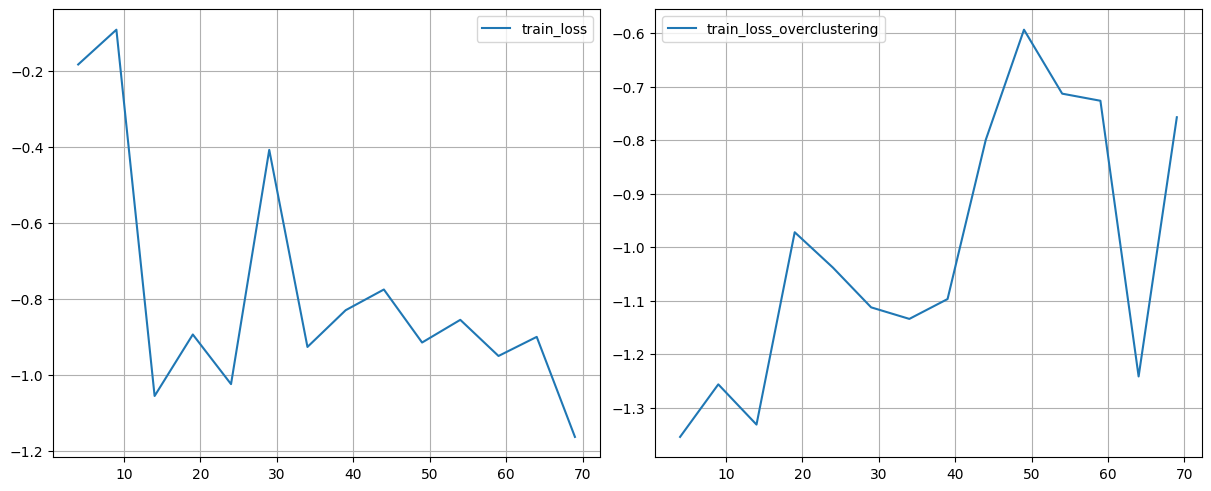

Epoch 71/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 72/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 73/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 74/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 75/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416, -1.0543495, -0.89254475, -1.0231663, -0.40667835, -0.9253451, -0.82863194, -0.7741542, -0.9136786, -0.85396767, -0.9490797, -0.89880973, -1.1620911, -0.9846576]
[-1.3549324, -1.2566711, -1.3318707, -0.9722884, -1.0383947, -1.1127188, -1.1343035, -1.0972048, -0.7995259, -0.5936545, -0.7132315, -0.726504, -1.2418869, -0.75731516, -0.8004427]


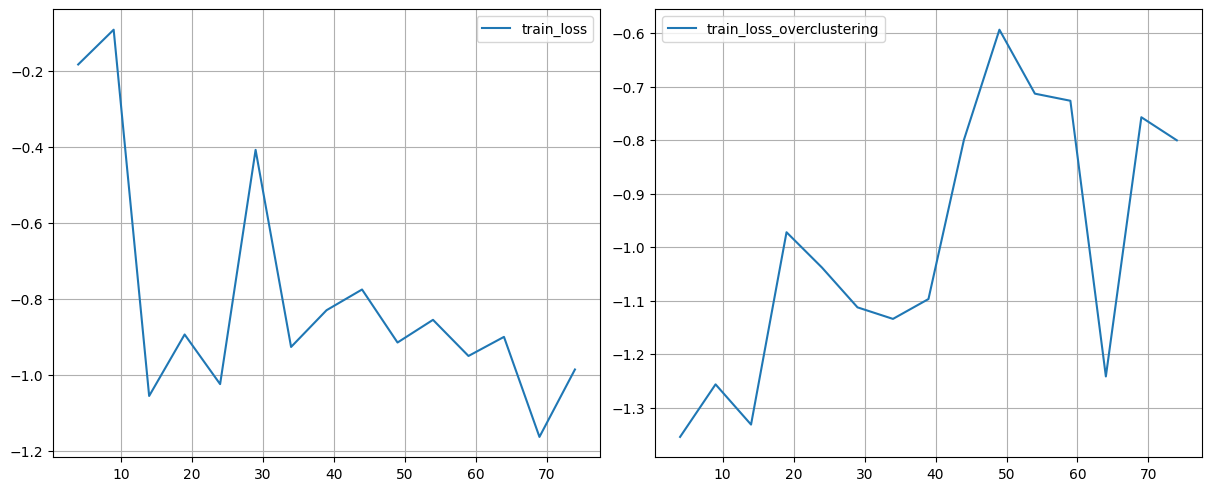

Epoch 76/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 77/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 78/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 79/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 80/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416, -1.0543495, -0.89254475, -1.0231663, -0.40667835, -0.9253451, -0.82863194, -0.7741542, -0.9136786, -0.85396767, -0.9490797, -0.89880973, -1.1620911, -0.9846576, -0.7135264]
[-1.3549324, -1.2566711, -1.3318707, -0.9722884, -1.0383947, -1.1127188, -1.1343035, -1.0972048, -0.7995259, -0.5936545, -0.7132315, -0.726504, -1.2418869, -0.75731516, -0.8004427, -0.7757676]


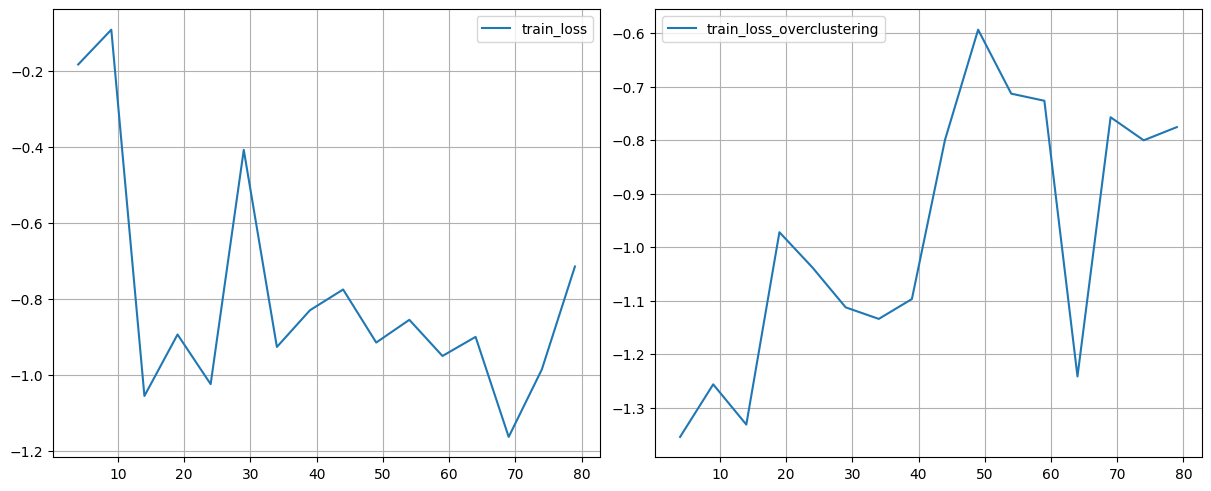

Epoch 81/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 82/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 83/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 84/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 85/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416, -1.0543495, -0.89254475, -1.0231663, -0.40667835, -0.9253451, -0.82863194, -0.7741542, -0.9136786, -0.85396767, -0.9490797, -0.89880973, -1.1620911, -0.9846576, -0.7135264, -0.68664074]
[-1.3549324, -1.2566711, -1.3318707, -0.9722884, -1.0383947, -1.1127188, -1.1343035, -1.0972048, -0.7995259, -0.5936545, -0.7132315, -0.726504, -1.2418869, -0.75731516, -0.8004427, -0.7757676, -0.47591165]


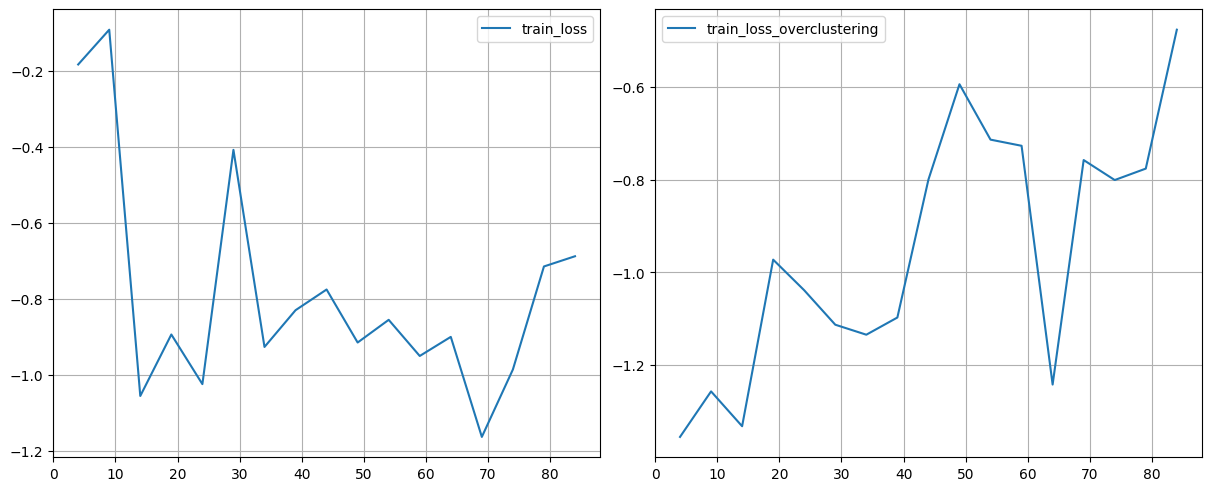

Epoch 86/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 87/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 88/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 89/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 90/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416, -1.0543495, -0.89254475, -1.0231663, -0.40667835, -0.9253451, -0.82863194, -0.7741542, -0.9136786, -0.85396767, -0.9490797, -0.89880973, -1.1620911, -0.9846576, -0.7135264, -0.68664074, -0.7046337]
[-1.3549324, -1.2566711, -1.3318707, -0.9722884, -1.0383947, -1.1127188, -1.1343035, -1.0972048, -0.7995259, -0.5936545, -0.7132315, -0.726504, -1.2418869, -0.75731516, -0.8004427, -0.7757676, -0.47591165, -0.900037]


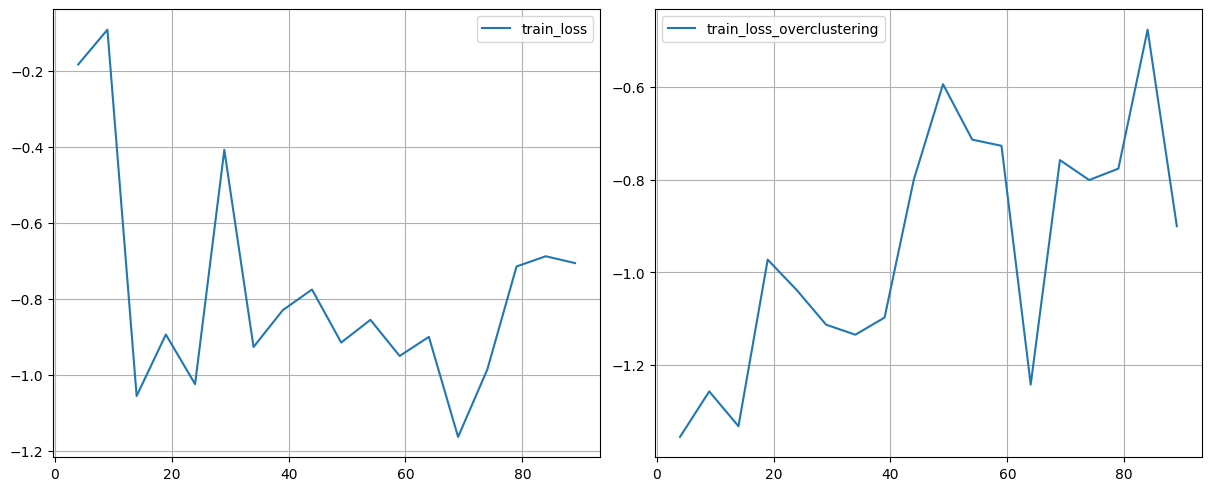

Epoch 91/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 92/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 93/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 94/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 95/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416, -1.0543495, -0.89254475, -1.0231663, -0.40667835, -0.9253451, -0.82863194, -0.7741542, -0.9136786, -0.85396767, -0.9490797, -0.89880973, -1.1620911, -0.9846576, -0.7135264, -0.68664074, -0.7046337, -0.97577214]
[-1.3549324, -1.2566711, -1.3318707, -0.9722884, -1.0383947, -1.1127188, -1.1343035, -1.0972048, -0.7995259, -0.5936545, -0.7132315, -0.726504, -1.2418869, -0.75731516, -0.8004427, -0.7757676, -0.47591165, -0.900037, -0.7333661]


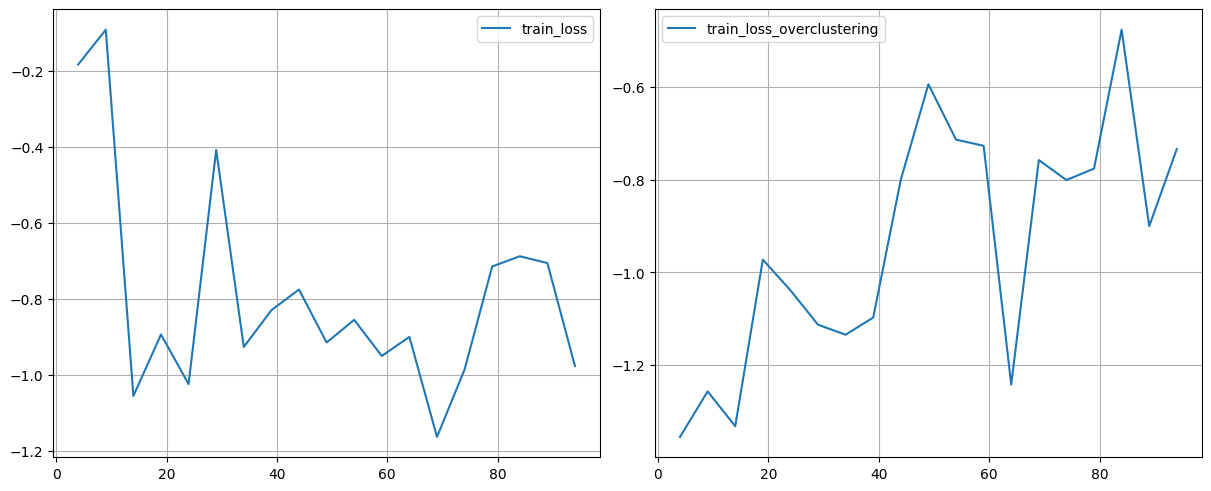

Epoch 96/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 97/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 98/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 99/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 100/100:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.18196799, -0.09042416, -1.0543495, -0.89254475, -1.0231663, -0.40667835, -0.9253451, -0.82863194, -0.7741542, -0.9136786, -0.85396767, -0.9490797, -0.89880973, -1.1620911, -0.9846576, -0.7135264, -0.68664074, -0.7046337, -0.97577214, -0.8683653]
[-1.3549324, -1.2566711, -1.3318707, -0.9722884, -1.0383947, -1.1127188, -1.1343035, -1.0972048, -0.7995259, -0.5936545, -0.7132315, -0.726504, -1.2418869, -0.75731516, -0.8004427, -0.7757676, -0.47591165, -0.900037, -0.7333661, -0.92405176]


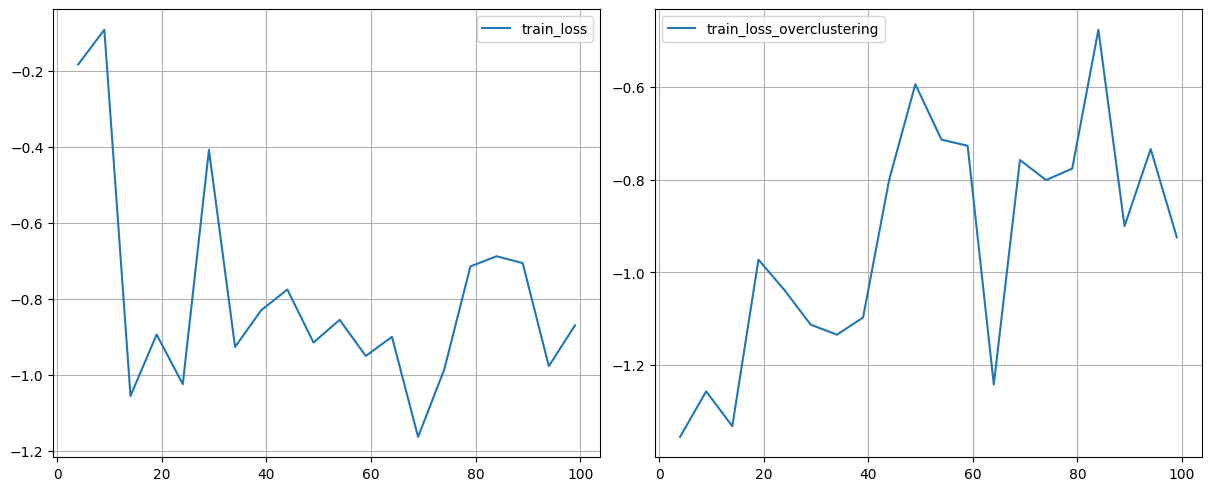

Best Clustering Loss Value: -1.1620911


In [ ]:
# training
optimizer = torch.optim.Adam(
    model.parameters(), lr=4e-4, betas=(0.9, 0.999), eps=1e-08,
    weight_decay=0, amsgrad=False)

train( model, dataloader_train, dataloader_val,
    optimizer, device=device, epochs=100, lamb=1.2,
    overcluster_period=20, overcluster_ratio=0.5)

In [ ]:
test_model = CustomModelClusterisator()
test_model.load_state_dict(torch.load("/content/best_loss_model_cifar10.pth"))
test_model.to(device)

CustomModelClusterisator(
  (resnet): CustomModel(
    (features): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (5): Dropout(p=0.25, inplace=False)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (12): ReLU(inplace=True)
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (cluster_head): Linear(in_features=1600, out_features=10, bias=True)
  (overcluster_head): Linear(in_features=1600, out

In [ ]:
# data testing
original_labels, cluster_labels = model_test(
    test_model, dataloader_val, device=device
)

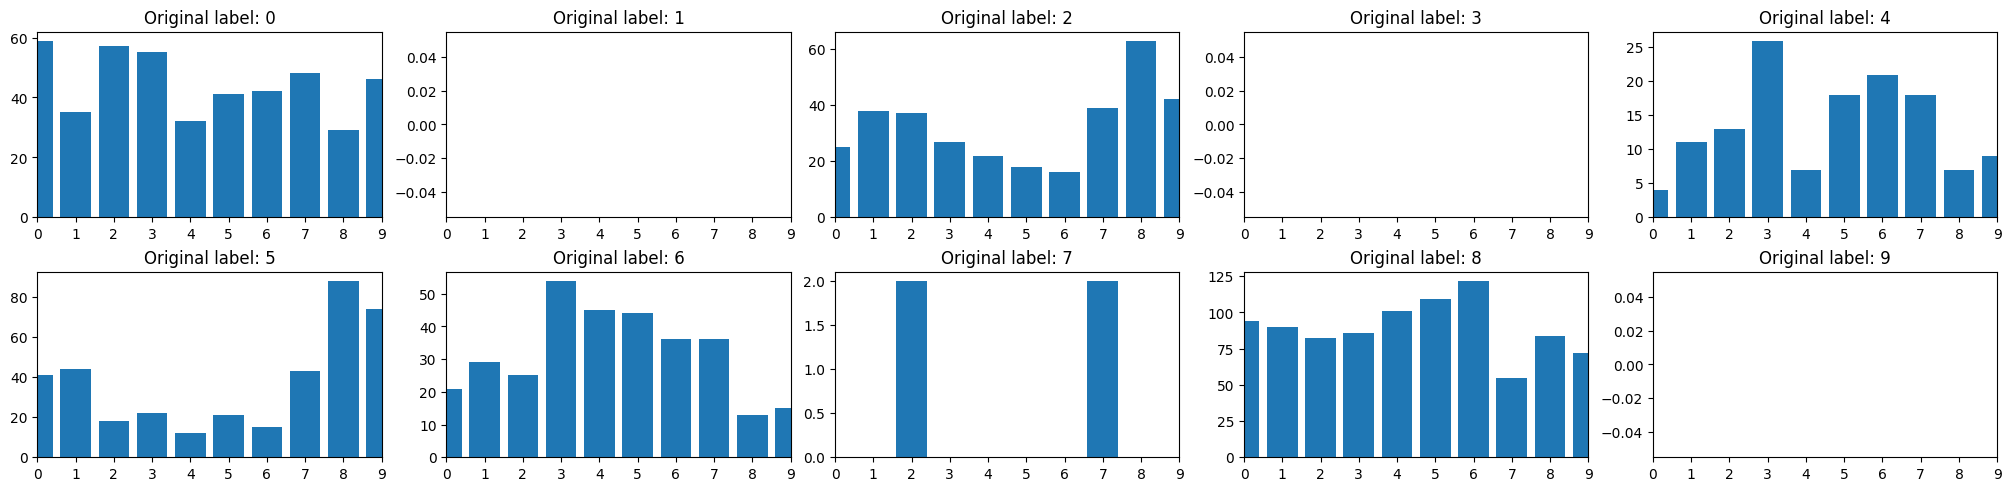

In [ ]:
# visualization
visualise_clusetering_results(original_labels, cluster_labels)

In [ ]:
adj_score = adjusted_rand_score(cluster_labels, original_labels)
hom_score = homogeneity_score(cluster_labels, original_labels)
compl_score = completeness_score(cluster_labels, original_labels)
print("Adjusted rand score: %.3f " % adj_score)
print("Homogeneity score: %.3f " % adj_score)
print("Completeness score: %.3f" % compl_score)

Adjusted rand score: 0.014 
Homogeneity score: 0.014 
Completeness score: 0.030


# Original Paper Model

In [ ]:
class ResNetClusterisator(nn.Module):
    def __init__(self):
        super(ResNetClusterisator, self).__init__()
        final_features = 512
        resnet = models.resnet18(pretrained=False)
        modules = list(resnet.children())[:-2]
        modules[0] = nn.Conv2d(
            3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        modules.append(nn.Flatten())
        self.backbone = nn.Sequential(*modules)
        self.cluster_head = nn.Linear(final_features, 10)
        self.overcluster_head = nn.Linear(final_features, 50)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x, overclustering=False):
        x = self.backbone(x)
        if overclustering:
            x = self.overcluster_head(x)
        else:
            x = self.cluster_head(x)
        return self.softmax(x)

In [ ]:
# weight initializer
def weight_init(model):
    if isinstance(model, nn.Conv2d):
        nn.init.xavier_normal_(model.weight, gain=nn.init.calculate_gain("relu"))
        if model.bias is not None:
            nn.init.zeros_(model.bias)

    elif isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight)
        if model.bias is not None:
            nn.init.zeros_(model.bias)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)
model = ResNetClusterisator()
model.to(device)
print("The model is transfered to", device)
model.apply(weight_init)
print("The weights are Initialised.")

Using cuda
The model is transfered to cuda
The weights are Initialised.


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
val = next(iter(dataloader_train))
input_batch = val[0]
input_batch = input_batch.to(device)
print("Model output shape in clustering mode:", model(input_batch).shape)
print("Model output shape in overclustering mode:", model(input_batch, overclustering=True).shape)

Model output shape in clustering mode: torch.Size([1024, 10])
Model output shape in overclustering mode: torch.Size([1024, 50])


**Loss**

In [ ]:
def IID_loss(x_out, x_tf_out, lamb=1.0, EPS=sys.float_info.epsilon):
    _, num_classes = x_out.size()
    # shape: [1024,10,1] * [1024,1,10] => [1024,10,10]
    p_i_j = x_out.unsqueeze(2) * x_tf_out.unsqueeze(1)
    # shape: [10,10]
    p_i_j = p_i_j.sum(dim=0)
    p_i_j = (p_i_j + p_i_j.t()) / 2.0
    p_i_j = p_i_j / p_i_j.sum() # Normalization
    assert p_i_j.size() == (num_classes, num_classes)
    
    p_i = p_i_j.sum(dim=1).view(num_classes, 1).expand(num_classes, num_classes).clone()
    p_j = p_i_j.sum(dim=0).view(1, num_classes).expand(num_classes, num_classes).clone()
    # avoid NaN losses. Effect will get cancelled out by p_i_j tiny anyway
    p_i_j[(p_i_j < EPS).data] = EPS
    p_j[(p_j < EPS).data] = EPS
    p_i[(p_i < EPS).data] = EPS

    loss = -p_i_j * (torch.log(p_i_j) - lamb * torch.log(p_j) - lamb * torch.log(p_i))
    return loss.sum()

In [ ]:
# loss testing
input_batch = val[0]
input_batch = input_batch.to(device)
aug_image_batch = val[1]
aug_image_batch = aug_image_batch.to(device)

lamb = 1.0
outputs = model(input_batch, overclustering = False)
outputs_tf = model(aug_image_batch, overclustering = False)
loss = IID_loss(outputs, outputs_tf, lamb=lamb)
print("Loss:", loss.data.cpu().numpy())

Loss: -0.0025954507


In [ ]:
del val

**Evaluation Function**

In [ ]:
def evaluate(model, dataloader, overclustering=False, lamb=1.0, 
             device=torch.device("cpu")):
    losses = []
    if overclustering:
      print("Overhead Clustering Evaluation --->")
    else:
      print("Clustering Evaluation --->")
    model.eval()
    for batch in tqdm(dataloader):
        inputs = batch[0]
        inputs_tf = batch[1]
        with torch.no_grad():
            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)
            outputs = model(inputs, overclustering)
            outputs_tf = model(inputs_tf, overclustering)
        loss = IID_loss(outputs, outputs_tf, lamb=lamb)
        losses.append(loss.data.cpu().numpy())
    return np.mean(losses)

**Auxilary Function**

In [ ]:
def choose_clustering_regime(epoch, overcluster_period, overcluster_ratio):
    if (
        overcluster_period is not None
        and epoch % overcluster_period < overcluster_period * overcluster_ratio
    ):
        return True
    else:
        return False

def print_while_trainig(epochs_list, loss_history, loss_history_overclustering):
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
    fig.set_figwidth(12)

    ax1.plot(epochs_list, loss_history, label="train_loss")
    ax1.legend()
    ax1.grid()

    ax2.plot(
        epochs_list, loss_history_overclustering, label="train_loss_overclustering"
    )
    ax2.legend()
    ax2.grid()
    plt.show()

In [ ]:
def model_test(model, dataloader,device=torch.device("cpu")):
    model.eval()
    original_labels = []
    cluster_labels = []
    for batch in dataloader:
        images = batch[0].to(device)
        labels = batch[2].to(device)
        outputs = model(images, False)
        original_labels += labels.tolist()
        cluster_labels += torch.argmax(outputs, dim=1).tolist()
    return original_labels, cluster_labels

def visualise_clusetering_results(original_labels, cluster_labels, figwidth=20):
    original_labels = np.array(original_labels)
    cluster_labels = np.array(cluster_labels)
    class_ids = np.unique(original_labels)
    fig, axes = plt.subplots(2, 5, constrained_layout=True)
    fig.set_figwidth(figwidth)

    for idx, ax in enumerate(axes.reshape(-1)):
        labels_distribution = original_labels[cluster_labels == idx]
        counts = np.array([np.sum(labels_distribution == i) for i in range(10)])
        ax.bar(list(range(10)), counts)
        ax.set_xticks(np.arange(10))
        ax.set_xlim([0, 9])
        ax.set_title("Original label: %i" % idx)

**Training Code**

In [ ]:
def train(modeldataset, dataloader, dataloader_val, optimizer, epochs=100,
    device=torch.device("cpu"), eval_every=5, lamb=1.0,
    overcluster_period=20, overcluster_ratio=0.5):
    
    epochs_list = []
    loss_history = []
    loss_history_overclustering = []
    best_cluster_loss = 0
    best_overcluster_loss = 0
    
    for epoch in range(epochs):
        print("Epoch {}/{}:".format(epoch+1, epochs))
        model.train()
        overclustering = choose_clustering_regime(
            epoch, overcluster_period, overcluster_ratio
        )
        for batch in tqdm(dataloader):
            optimizer.zero_grad()
            inputs = batch[0]
            inputs_tf = batch[1]
            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)
            outputs = model(inputs, overclustering)
            outputs_tf = model(inputs_tf, overclustering)
            loss = IID_loss(outputs, outputs_tf, lamb=lamb)
            loss.backward()
            optimizer.step()
        # evaluation
        if (epoch + 1) % eval_every == 0:
            loss_eval = evaluate(
                model, dataloader_val, overclustering=False, lamb=lamb, device=device
            )
            loss_eval_overclustering = evaluate(
                model, dataloader_val, overclustering=True, lamb=lamb, device=device
            )

            loss_history.append(loss_eval)
            print(loss_history)
            loss_history_overclustering.append(loss_eval_overclustering)
            print(loss_history_overclustering)
            epochs_list.append(epoch)
            if loss_eval < best_cluster_loss:
                best_cluster_loss = loss_eval
                torch.save(model.state_dict(), "/content/best_loss_model_cifar10.pth")
            print_while_trainig(epochs_list, loss_history, loss_history_overclustering)
    print("Best Clustering Loss Value:", best_cluster_loss)

Epoch 1/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995]
[-3.8316643]


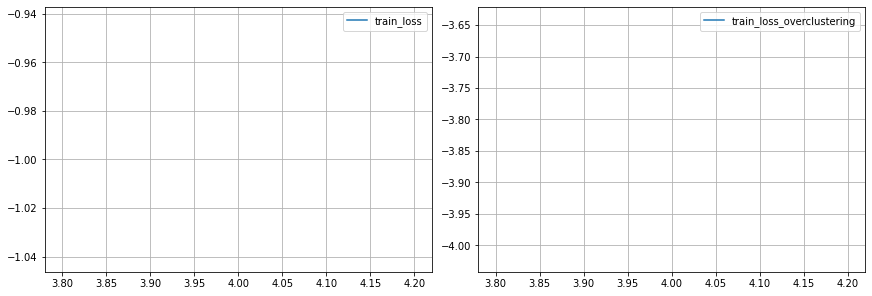

Epoch 6/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149]
[-3.8316643, -3.9757812]


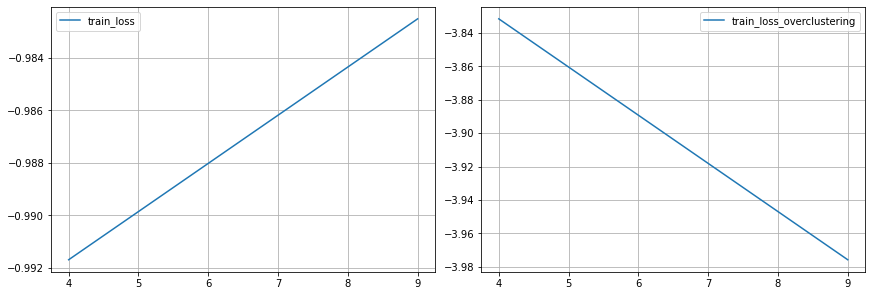

Epoch 11/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408]
[-3.8316643, -3.9757812, -3.043438]


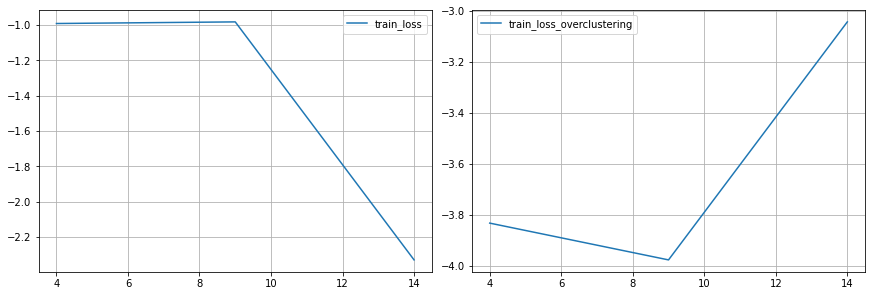

Epoch 16/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 17/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 18/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 19/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 20/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301]
[-3.8316643, -3.9757812, -3.043438, -3.005256]


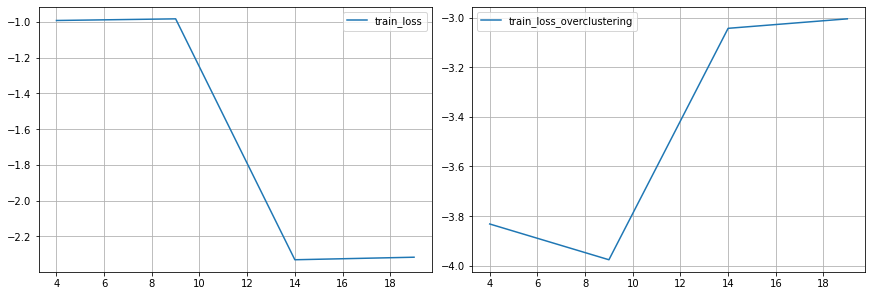

Epoch 21/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 22/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 23/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 24/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 25/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334]


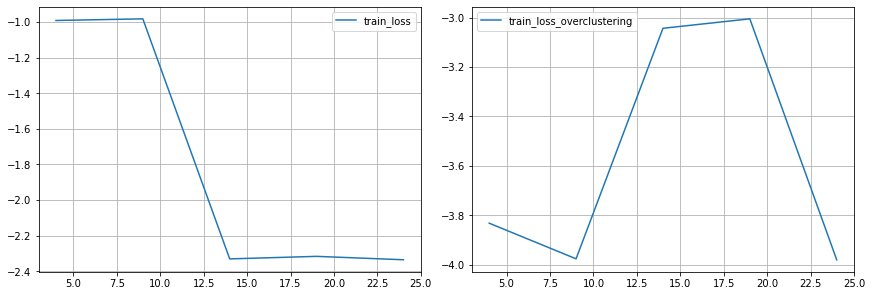

Epoch 26/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 27/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 28/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 29/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 30/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233]


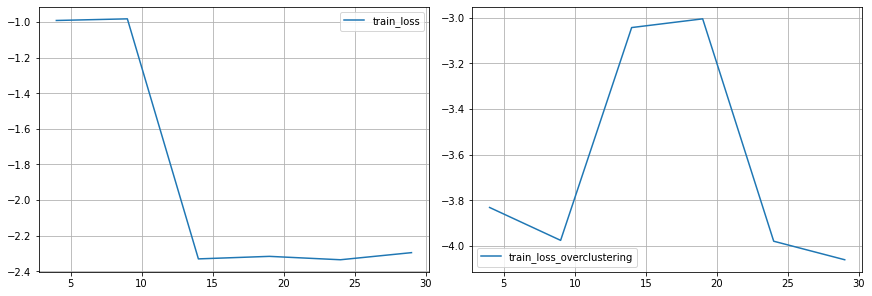

Epoch 31/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 32/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 33/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 34/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 35/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252]


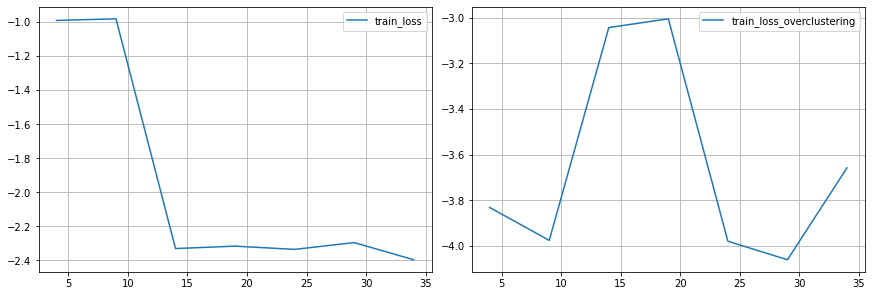

Epoch 36/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 37/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 38/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 39/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 40/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764]


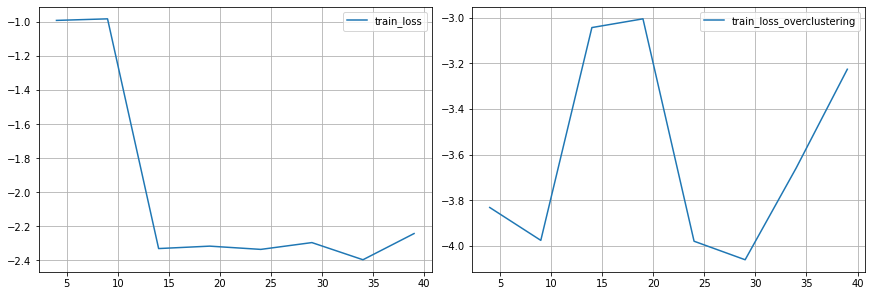

Epoch 41/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 42/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 43/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 44/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 45/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087]


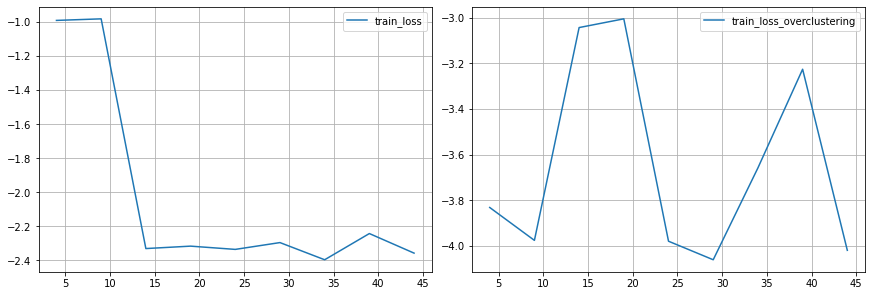

Epoch 46/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 47/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 48/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 49/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 50/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416]


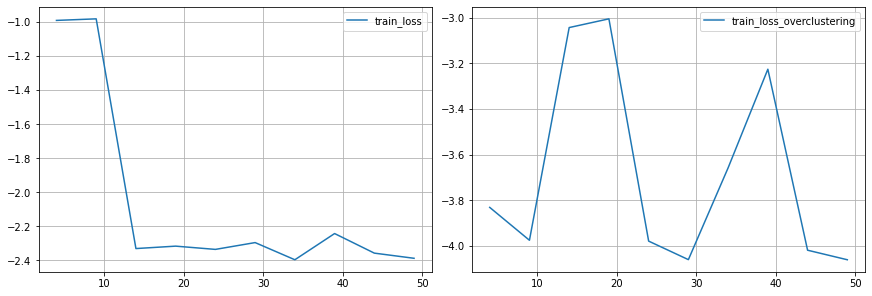

Epoch 51/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 52/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 53/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 54/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 55/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367]


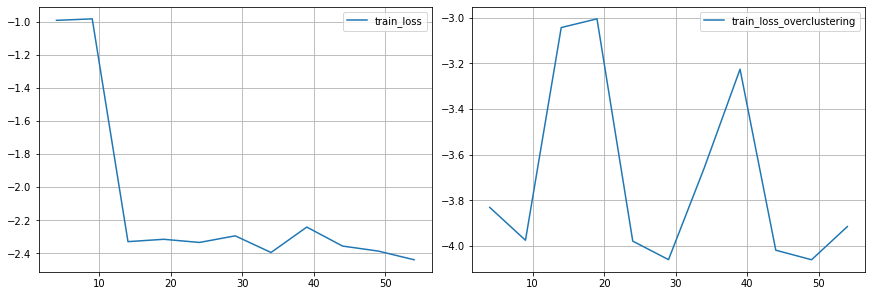

Epoch 56/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 57/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 58/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 59/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 60/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813]


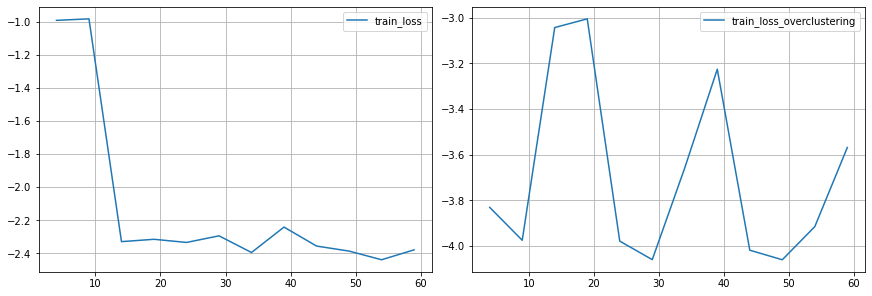

Epoch 61/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 62/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 63/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 64/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 65/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862]


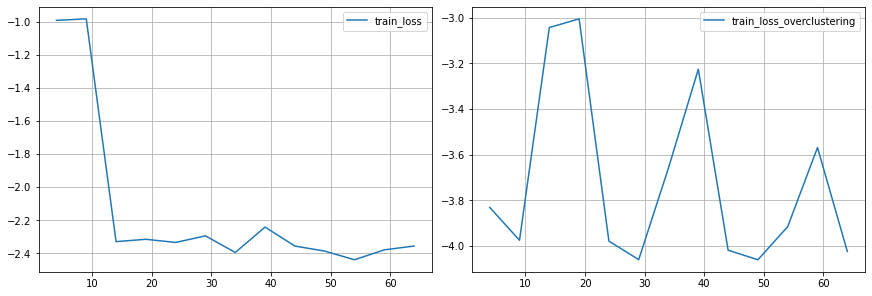

Epoch 66/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 67/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 68/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 69/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 70/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902]


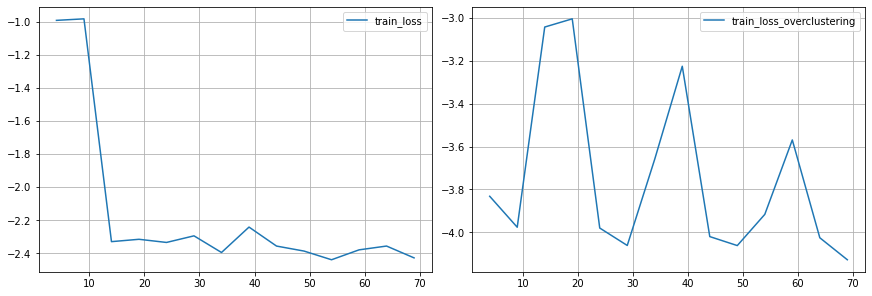

Epoch 71/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 72/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 73/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 74/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 75/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523]


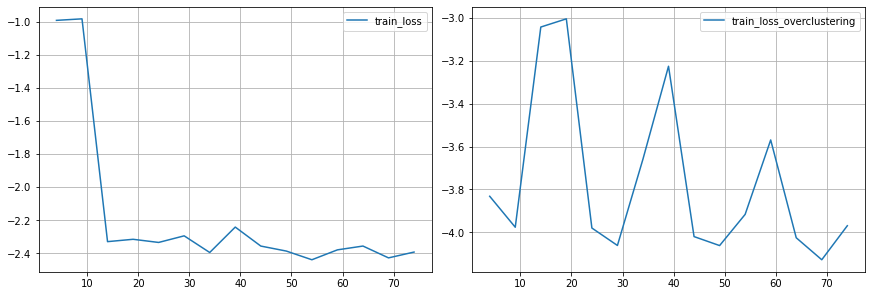

Epoch 76/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 77/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 78/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 79/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 80/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892]


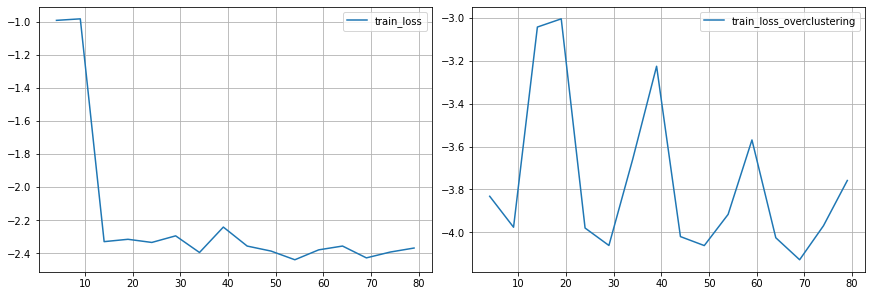

Epoch 81/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 82/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 83/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 84/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 85/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586]


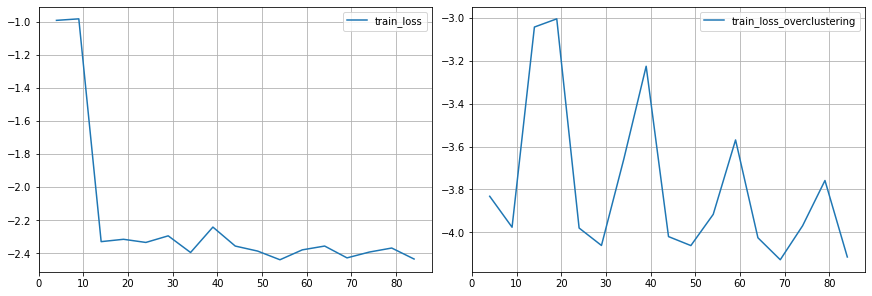

Epoch 86/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 87/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 88/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 89/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 90/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868]


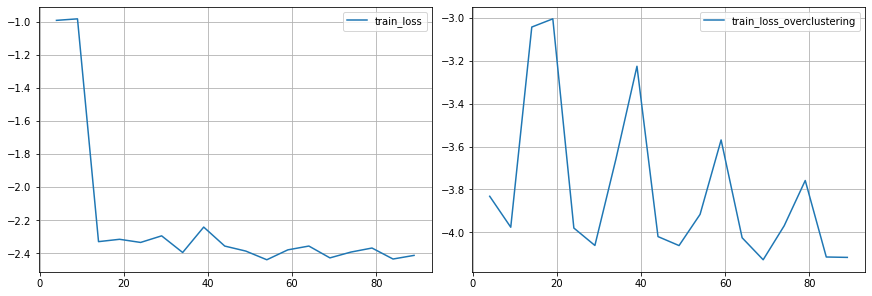

Epoch 91/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 92/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 93/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 94/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 95/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665]


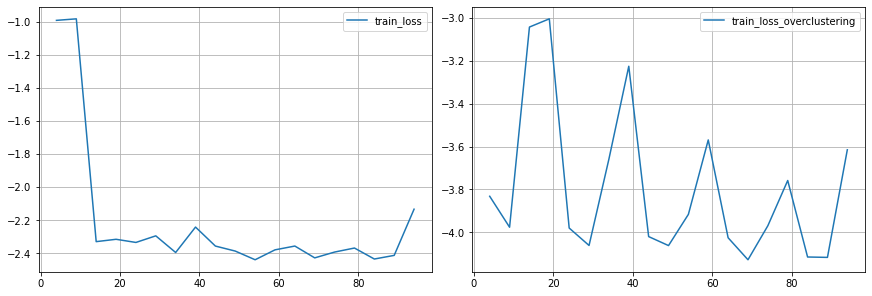

Epoch 96/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 97/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 98/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 99/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 100/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148]


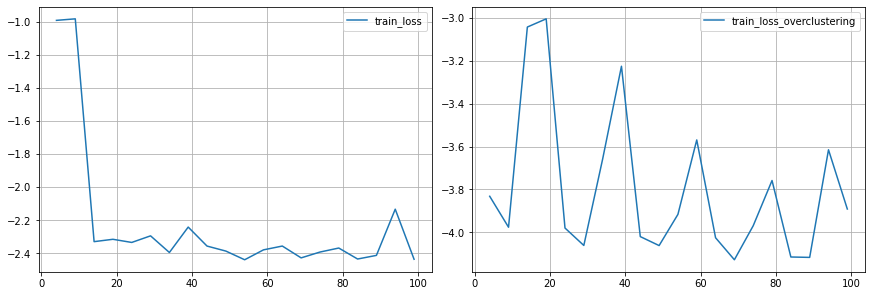

Epoch 101/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 102/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 103/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 104/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 105/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426]


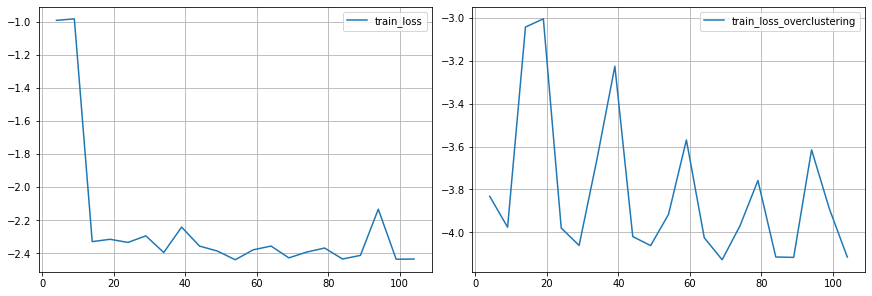

Epoch 106/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 107/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 108/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 109/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 110/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264]


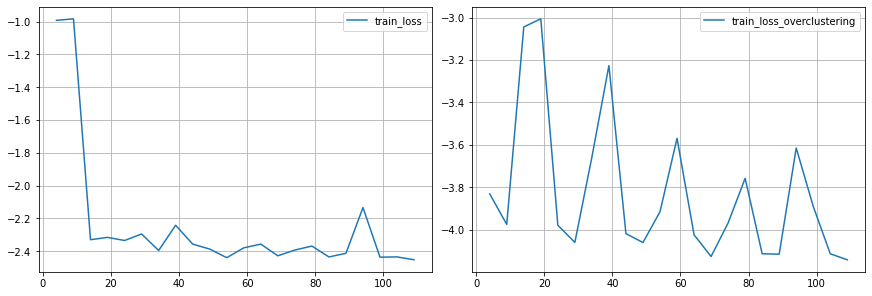

Epoch 111/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 112/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 113/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 114/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 115/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307, -2.3581936]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264, -3.924176]


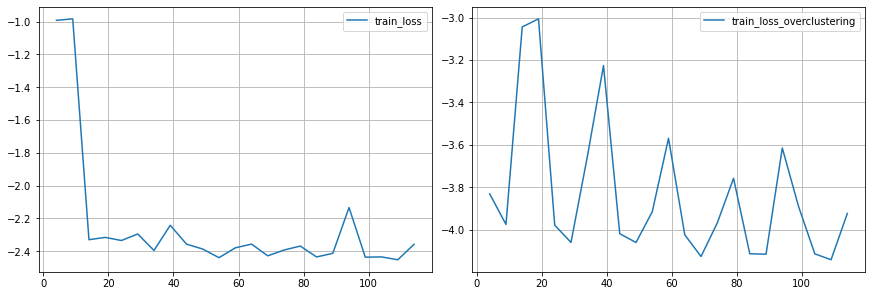

Epoch 116/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 117/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 118/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 119/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 120/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307, -2.3581936, -2.4639752]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264, -3.924176, -3.9823415]


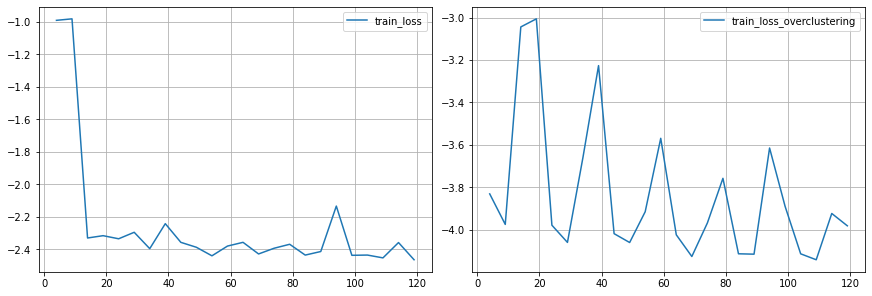

Epoch 121/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 122/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 123/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 124/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 125/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307, -2.3581936, -2.4639752, -2.4664338]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264, -3.924176, -3.9823415, -4.1218524]


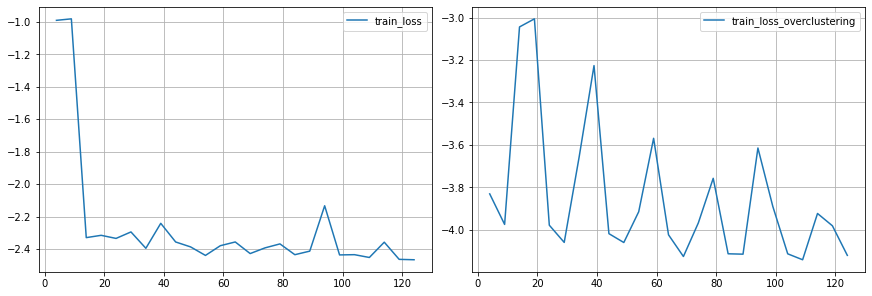

Epoch 126/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 127/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 128/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 129/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 130/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307, -2.3581936, -2.4639752, -2.4664338, -2.4406948]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264, -3.924176, -3.9823415, -4.1218524, -4.089837]


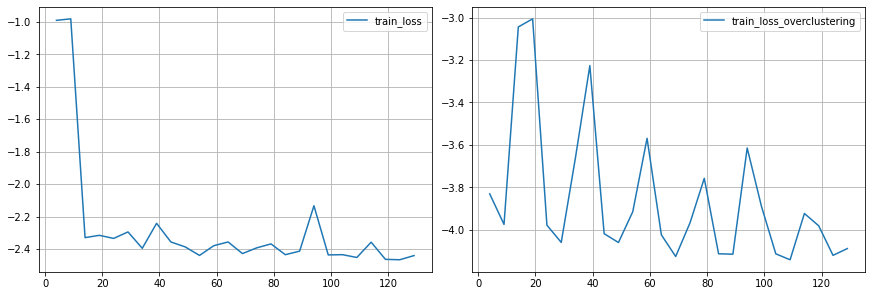

Epoch 131/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 132/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 133/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 134/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 135/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307, -2.3581936, -2.4639752, -2.4664338, -2.4406948, -2.4438288]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264, -3.924176, -3.9823415, -4.1218524, -4.089837, -3.999425]


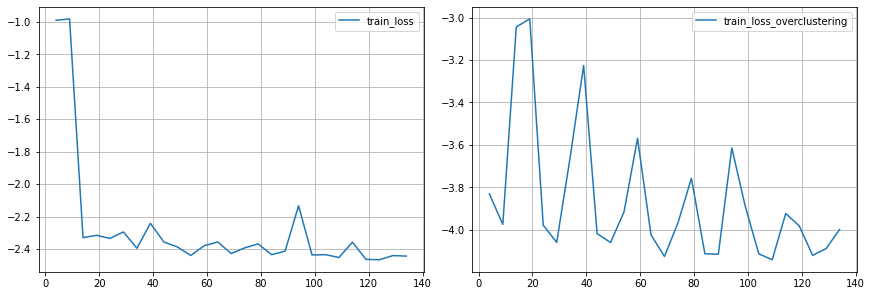

Epoch 136/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 137/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 138/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 139/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 140/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307, -2.3581936, -2.4639752, -2.4664338, -2.4406948, -2.4438288, -2.4358284]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264, -3.924176, -3.9823415, -4.1218524, -4.089837, -3.999425, -3.9900596]


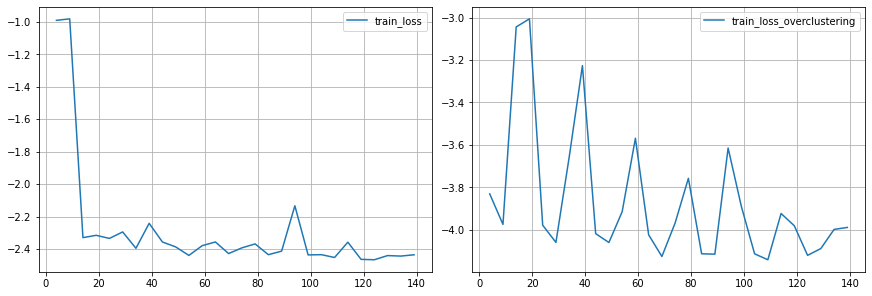

Epoch 141/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 142/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 143/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 144/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 145/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307, -2.3581936, -2.4639752, -2.4664338, -2.4406948, -2.4438288, -2.4358284, -2.4404905]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264, -3.924176, -3.9823415, -4.1218524, -4.089837, -3.999425, -3.9900596, -4.0995426]


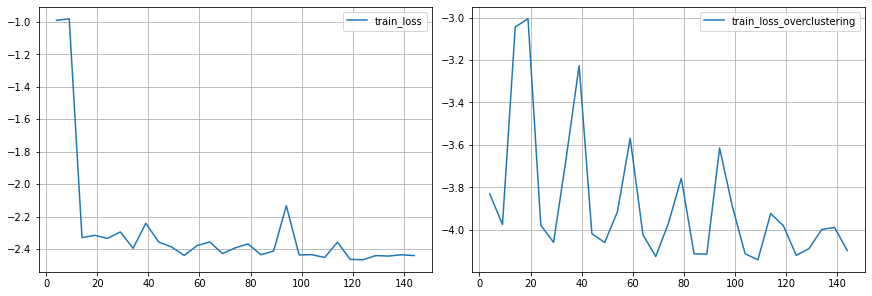

Epoch 146/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 147/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 148/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 149/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 150/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307, -2.3581936, -2.4639752, -2.4664338, -2.4406948, -2.4438288, -2.4358284, -2.4404905, -2.3934104]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264, -3.924176, -3.9823415, -4.1218524, -4.089837, -3.999425, -3.9900596, -4.0995426, -4.1305842]


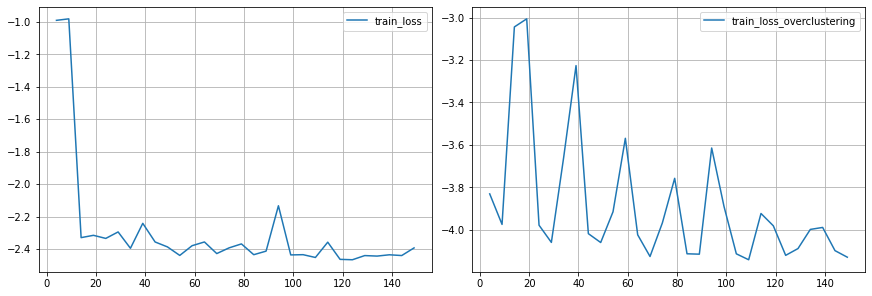

Epoch 151/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 152/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 153/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 154/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 155/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307, -2.3581936, -2.4639752, -2.4664338, -2.4406948, -2.4438288, -2.4358284, -2.4404905, -2.3934104, -2.4829178]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264, -3.924176, -3.9823415, -4.1218524, -4.089837, -3.999425, -3.9900596, -4.0995426, -4.1305842, -4.165746]


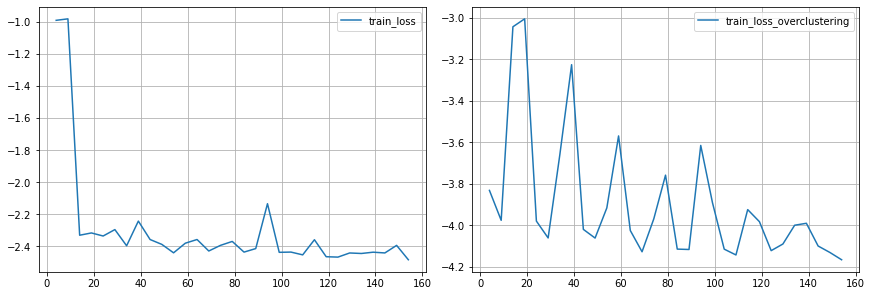

Epoch 156/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 157/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 158/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 159/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 160/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307, -2.3581936, -2.4639752, -2.4664338, -2.4406948, -2.4438288, -2.4358284, -2.4404905, -2.3934104, -2.4829178, -2.394707]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264, -3.924176, -3.9823415, -4.1218524, -4.089837, -3.999425, -3.9900596, -4.0995426, -4.1305842, -4.165746, -3.9892578]


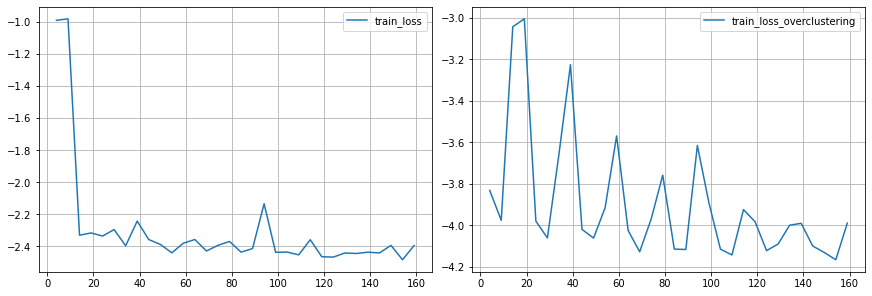

Epoch 161/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 162/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 163/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 164/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 165/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307, -2.3581936, -2.4639752, -2.4664338, -2.4406948, -2.4438288, -2.4358284, -2.4404905, -2.3934104, -2.4829178, -2.394707, -2.438179]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264, -3.924176, -3.9823415, -4.1218524, -4.089837, -3.999425, -3.9900596, -4.0995426, -4.1305842, -4.165746, -3.9892578, -4.1194863]


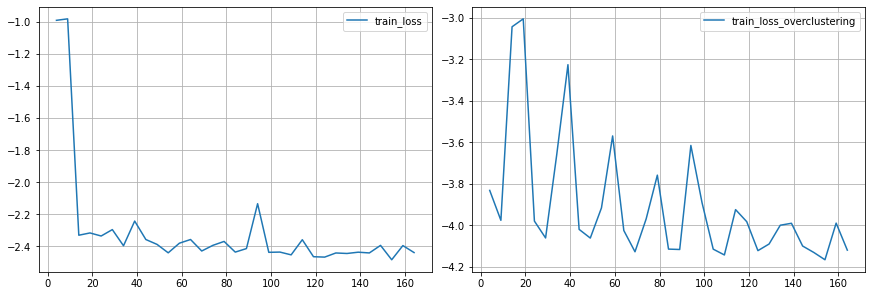

Epoch 166/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 167/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 168/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 169/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 170/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307, -2.3581936, -2.4639752, -2.4664338, -2.4406948, -2.4438288, -2.4358284, -2.4404905, -2.3934104, -2.4829178, -2.394707, -2.438179, -2.4530623]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264, -3.924176, -3.9823415, -4.1218524, -4.089837, -3.999425, -3.9900596, -4.0995426, -4.1305842, -4.165746, -3.9892578, -4.1194863, -4.157093]


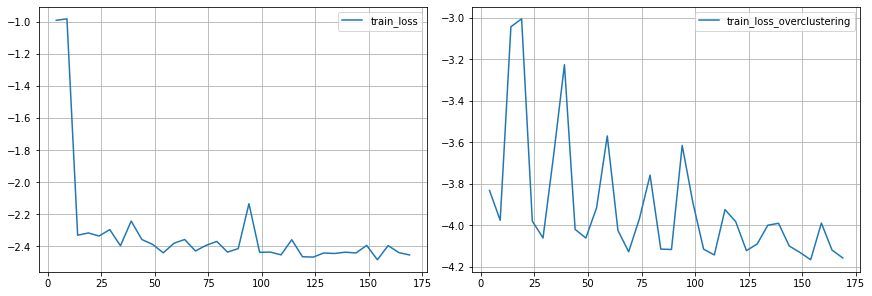

Epoch 171/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 172/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 173/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 174/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 175/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307, -2.3581936, -2.4639752, -2.4664338, -2.4406948, -2.4438288, -2.4358284, -2.4404905, -2.3934104, -2.4829178, -2.394707, -2.438179, -2.4530623, -2.4188025]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264, -3.924176, -3.9823415, -4.1218524, -4.089837, -3.999425, -3.9900596, -4.0995426, -4.1305842, -4.165746, -3.9892578, -4.1194863, -4.157093, -3.992863]


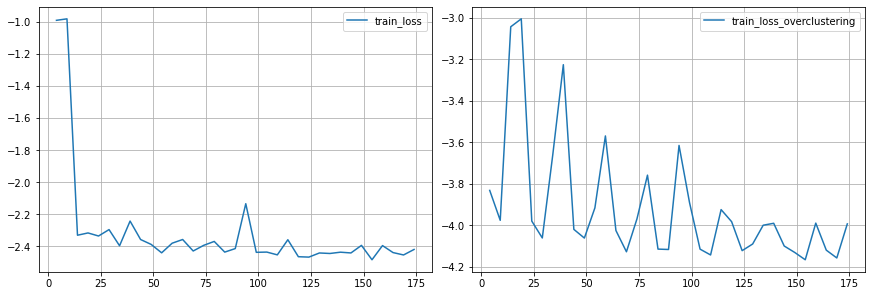

Epoch 176/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 177/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 178/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 179/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 180/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307, -2.3581936, -2.4639752, -2.4664338, -2.4406948, -2.4438288, -2.4358284, -2.4404905, -2.3934104, -2.4829178, -2.394707, -2.438179, -2.4530623, -2.4188025, -2.3408766]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264, -3.924176, -3.9823415, -4.1218524, -4.089837, -3.999425, -3.9900596, -4.0995426, -4.1305842, -4.165746, -3.9892578, -4.1194863, -4.157093, -3.992863, -3.908684]


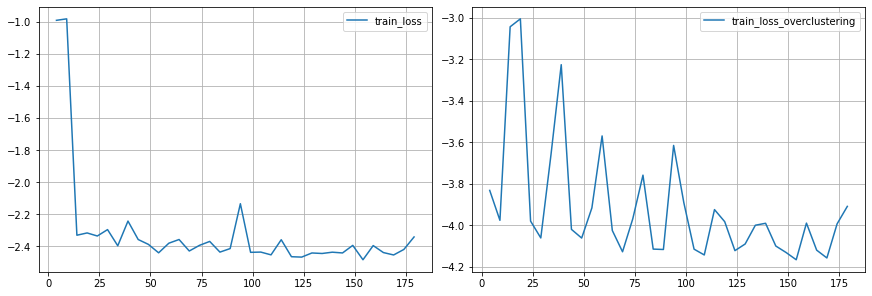

Epoch 181/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 182/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 183/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 184/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 185/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307, -2.3581936, -2.4639752, -2.4664338, -2.4406948, -2.4438288, -2.4358284, -2.4404905, -2.3934104, -2.4829178, -2.394707, -2.438179, -2.4530623, -2.4188025, -2.3408766, -2.425336]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264, -3.924176, -3.9823415, -4.1218524, -4.089837, -3.999425, -3.9900596, -4.0995426, -4.1305842, -4.165746, -3.9892578, -4.1194863, -4.157093, -3.992863, -3.908684, -4.1018605]


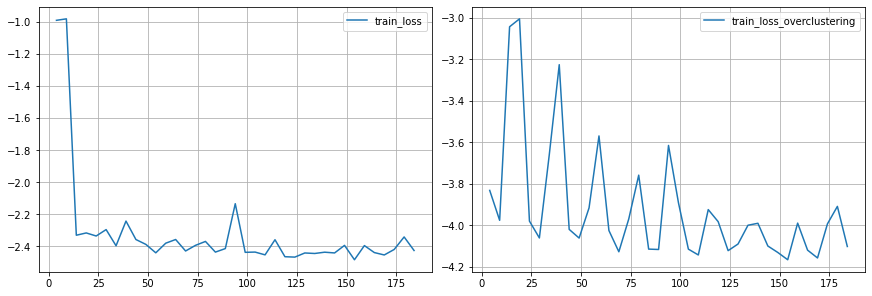

Epoch 186/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 187/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 188/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 189/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 190/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307, -2.3581936, -2.4639752, -2.4664338, -2.4406948, -2.4438288, -2.4358284, -2.4404905, -2.3934104, -2.4829178, -2.394707, -2.438179, -2.4530623, -2.4188025, -2.3408766, -2.425336, -2.4179323]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264, -3.924176, -3.9823415, -4.1218524, -4.089837, -3.999425, -3.9900596, -4.0995426, -4.1305842, -4.165746, -3.9892578, -4.1194863, -4.157093, -3.992863, -3.908684, -4.1018605, -4.1086826]


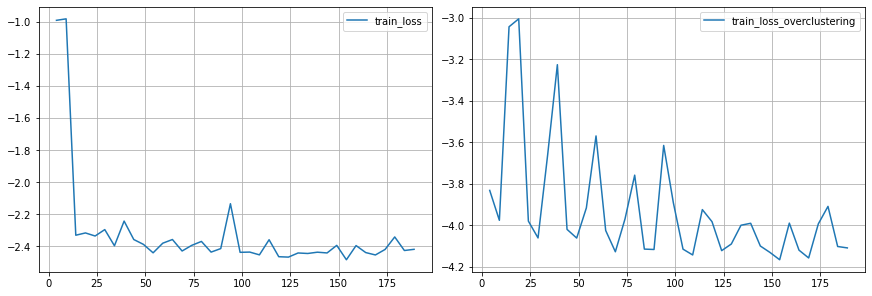

Epoch 191/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 192/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 193/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 194/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 195/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307, -2.3581936, -2.4639752, -2.4664338, -2.4406948, -2.4438288, -2.4358284, -2.4404905, -2.3934104, -2.4829178, -2.394707, -2.438179, -2.4530623, -2.4188025, -2.3408766, -2.425336, -2.4179323, -2.4981568]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264, -3.924176, -3.9823415, -4.1218524, -4.089837, -3.999425, -3.9900596, -4.0995426, -4.1305842, -4.165746, -3.9892578, -4.1194863, -4.157093, -3.992863, -3.908684, -4.1018605, -4.1086826, -4.096761]


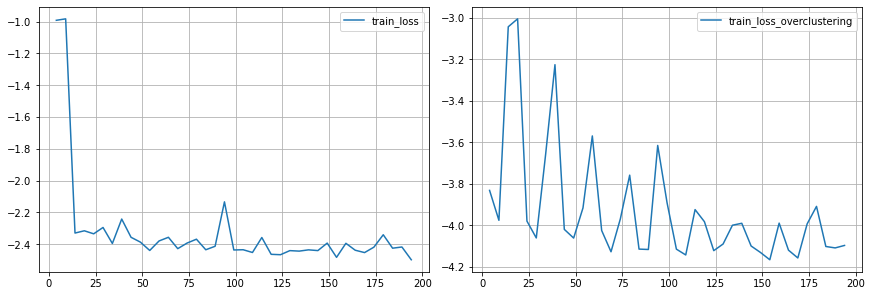

Epoch 196/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 197/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 198/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 199/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 200/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.9916995, -0.9825149, -2.3301408, -2.3159301, -2.334997, -2.2950838, -2.3957982, -2.2420597, -2.3569164, -2.3871973, -2.4397144, -2.3798091, -2.3568218, -2.4283514, -2.3931553, -2.3688037, -2.4352574, -2.413314, -2.1338613, -2.4366343, -2.435129, -2.4524307, -2.3581936, -2.4639752, -2.4664338, -2.4406948, -2.4438288, -2.4358284, -2.4404905, -2.3934104, -2.4829178, -2.394707, -2.438179, -2.4530623, -2.4188025, -2.3408766, -2.425336, -2.4179323, -2.4981568, -2.4517457]
[-3.8316643, -3.9757812, -3.043438, -3.005256, -3.9795334, -4.0607233, -3.6583252, -3.2260764, -4.0194087, -4.0612416, -3.9159367, -3.5692813, -4.024862, -4.1272902, -3.9688523, -3.7581892, -4.1144586, -4.1162868, -3.6150665, -3.8910148, -4.1146426, -4.14264, -3.924176, -3.9823415, -4.1218524, -4.089837, -3.999425, -3.9900596, -4.0995426, -4.1305842, -4.165746, -3.9892578, -4.1194863, -4.157093, -3.992863, -3.908684, -4.1018605, -4.1086826, -4.096761, -4.046993]


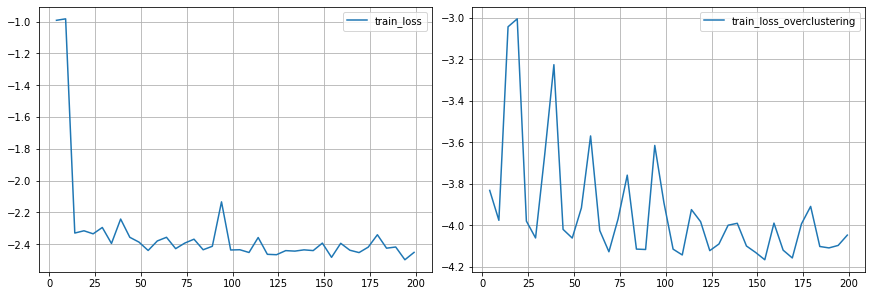

Best Clustering Loss Value: -2.4981568


In [ ]:
# training
optimizer = torch.optim.Adam(
    model.parameters(), lr=4e-4, betas=(0.9, 0.999), eps=1e-08,
    weight_decay=0, amsgrad=False)

train( model, dataloader_train, dataloader_val,
    optimizer, device=device, epochs=200, lamb=1.2,
    overcluster_period=20, overcluster_ratio=0.5)

**Loading best model**

In [ ]:
test_model = ResNetClusterisator()
test_model.load_state_dict(torch.load("/content/best_loss_model_cifar10.pth"))
test_model.to(device)

ResNetClusterisator(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
# data testing
original_labels, cluster_labels = model_test(
    test_model, dataloader_val, device=device
)

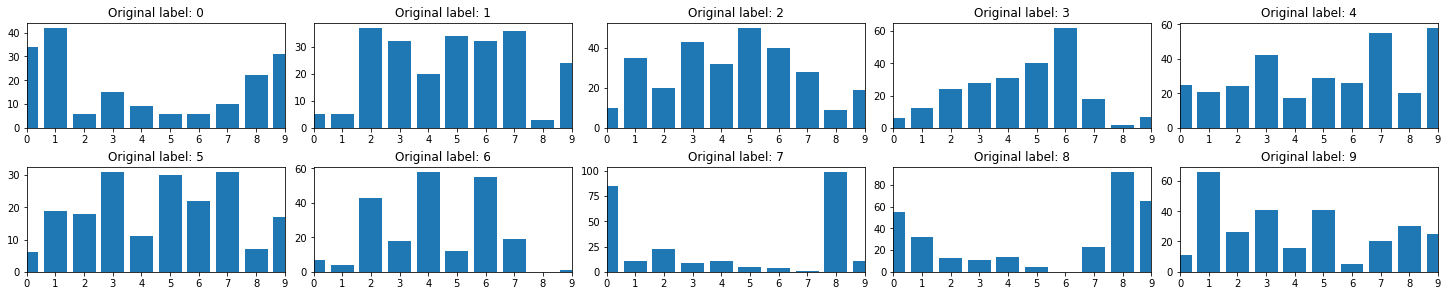

In [ ]:
# visualization
visualise_clusetering_results(original_labels, cluster_labels)

In [ ]:
adj_score = adjusted_rand_score(cluster_labels, original_labels)
hom_score = homogeneity_score(cluster_labels, original_labels)
compl_score = completeness_score(cluster_labels, original_labels)
print("Adjusted rand score: %.3f " % adj_score)
print("Homogeneity score: %.3f " % adj_score)
print("Completeness score: %.3f" % compl_score)

Adjusted rand score: 0.062 
Homogeneity score: 0.062 
Completeness score: 0.121


In [ ]:
accuracy_score(original_labels, cluster_labels)

0.1228